In [1]:
# core 3rd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# our library
from vizard_utils import functional
from vizard_utils import constant
from vizard_utils import logic
from vizard_utils import PDFIO
from vizard_utils import preprocessor

# MLOps
import dvc.api
import mlflow

# other
import time

<span style="color:gold">See #9 issue.</span>

In [2]:
s0 = time.process_time_ns()

## Reproducibility


In [3]:
SEED = 322
np.random.seed(SEED)
rng = np.random.default_rng(SEED)
print('SEED={}'.format(SEED))

SEED=322


## General Functions For All Sections

In [4]:
def detect_outliers(df,features):
    from collections import Counter

    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indices
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indices
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

## Loading Data


### Setup DVC experiment and configs

In [5]:
# main path
SRC_DIR = '/mnt/e/dataset/processed/all/'  # path to source encrypted pdf
DST_DIR = 'raw-dataset/all/'  # path to decrypted pdf

# MLFlow configs
# data versioning config
PATH = DST_DIR[:-1] + '.pkl'  # path to source data, e.g. data.pkl file
REPO = '/home/nik/visaland-visa-form-utility'
VERSION = 'v1.0.2.1'  # use latest using `git tag`

# experiment configs
MLFLOW_EXPERIMENT_NAME = 'exploratory data analysis - jupyter lab'
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
MLFLOW_TAGS = {
    'stage': 'dev'  # dev, beta, production
}
mlflow.set_tags(MLFLOW_TAGS)


### Set global options for the notebook

In [6]:
# pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# matplotlib
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('fivethirtyeight')
import mplcyberpunk
plt.style.use('cyberpunk')
%matplotlib inline

### Import data from DVC storage

In [7]:
# get url data from DVC data storage
data_url = dvc.api.get_url(path=PATH, repo=REPO, rev=VERSION)
# read dataset from remote (local) data storage
data = pd.read_pickle(data_url)

### Getting to know the data

In [8]:
data.head()

,P1.AdultFlag,P1.PD.ServiceIn.ServiceIn,P1.PD.VisaType.VisaType,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.PlaceBirthCity,P1.PD.PlaceBirthCountry,P1.PD.Citizenship.Citizenship,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.CurrCOR.Row2.Other,P1.PD.PCRIndicator,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row2.Status,P1.PD.PrevCOR.Row3.Country,P1.PD.PrevCOR.Row3.Status,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaRe

In [9]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [10]:
data.isnull().sum()[data.isnull().sum() != 0] #checking for total null values

P1.AdultFlag                                              3
P1.PD.ServiceIn.ServiceIn                                 3
P1.PD.VisaType.VisaType                                   3
P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator     3
P1.PD.Sex.Sex                                             3
                                                         ..
p1.SecC.Chd.[2].ChdDOB.Period                            26
p1.SecC.Chd.[3].ChdDOB.Period                            26
p1.SecC.Chd.[4].ChdDOB.Period                            26
p1.SecC.Chd.[5].ChdDOB.Period                            26
p1.SecC.Chd.[6].ChdDOB.Period                            26
Length: 154, dtype: int64

it seems we have 4 rows with no information (empty forms) but the flag exists. There is nothing we can do except deleting them.

In [11]:
data[data['P1.PD.VisaType.VisaType'].isna()]

,P1.AdultFlag,P1.PD.ServiceIn.ServiceIn,P1.PD.VisaType.VisaType,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.PlaceBirthCity,P1.PD.PlaceBirthCountry,P1.PD.Citizenship.Citizenship,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.CurrCOR.Row2.Other,P1.PD.PCRIndicator,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row2.Status,P1.PD.PrevCOR.Row3.Country,P1.PD.PrevCOR.Row3.Status,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaRe

In [12]:
data = data.drop(data[data['P1.PD.VisaType.VisaType'].isna()].index)
data.isnull().sum()[data.isnull().sum() != 0]

P3.Edu.Edu_Row1.FieldOfStudy     97
p1.SecA.Sps.SpsCOB               70
p1.SecA.Mo.MoCOB                  8
p1.SecA.Fa.FaCOB                  8
p1.SecB.Chd.[0].ChdDOB.Period     5
p1.SecB.Chd.[1].ChdDOB.Period     3
p1.SecC.Chd.[0].ChdDOB.Period    23
p1.SecC.Chd.[1].ChdDOB.Period    23
p1.SecC.Chd.[2].ChdDOB.Period    23
p1.SecC.Chd.[3].ChdDOB.Period    23
p1.SecC.Chd.[4].ChdDOB.Period    23
p1.SecC.Chd.[5].ChdDOB.Period    23
p1.SecC.Chd.[6].ChdDOB.Period    23
dtype: int64

We can see the only two type of data are missing:
1. COB: country of birth
2. Period: age of sibling and kids (probably because the person does not have any kid or sibling to fill)

| Feature | Fill | Desc |
| --- | --- | --- |
| COB | str: same as applicant's COB for ghost spouse | If all SpsCOB are the same, just drop the entire column, so no differentiation between ghost spouse or missed one.  
| Period | int: 0 | prob only ghost cases, otherwise, should be filled statistically 

In [13]:
spouse_fields = [c for c in data.columns.values if 'Sps' in c]
spouse_fields

['p1.SecA.Sps.SpsCOB',
 'p1.SecA.Sps.SpsOcc',
 'p1.SecA.Sps.SpsAccomp',
 'p1.SecA.Sps.SpsDOB.Period']

In [14]:
data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields]

,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Sps.SpsDOB.Period
8,None,OTHER,False,0.0
15,None,OTHER,False,0.0
25,None,OTHER,False,0.0
27,None,HOUSEWIFE,True,10368.0
29,None,HOUSEWIFE,True,10368.0
...,...,...,...,...
288,None,OTHER,False,0.0
290,None,OTHER,False,0.0
291,None,OTHER,False,0.0
294,None,OTHER,False,0.0


In [15]:
print(data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields].__len__())
print(data[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna())][spouse_fields].__len__())

70
67


There are 70-67 cases where the person has job title but no COB, which means that only 3 cases are not ghost cases and we can fill their COB using their spouse's COB.
For all other cases (ghosts), we just use the dominant case, IRAN. 

In [16]:
# fill ghost cases' COB with 'IRAN'
data.loc[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna()), ['p1.SecA.Sps.SpsCOB']] = 'IRAN'

In [17]:
print(data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields].__len__())
print(data[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna())][spouse_fields].__len__())

3
0


In [18]:
# fill non-filled spouse COB cases' with their spouses' COB
data.loc[data['p1.SecA.Sps.SpsCOB'].isna(), ['p1.SecA.Sps.SpsCOB']] = data['P1.PD.PlaceBirthCountry']

In [19]:
print(data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields].__len__())
print(data[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna())][spouse_fields].__len__())

0
0


## Analyzing the features

### Ground truth

In [20]:
data.loc[data['VisaResult'] == 1, ['VisaResult']] = 'acc'  # 1 -> accepted
data.loc[data['VisaResult'] == 2, ['VisaResult']] = 'rej'  # 2 -> rejected
data.loc[data['VisaResult'] == 3, ['VisaResult']] = 'w-acc'  # 3 -> allegedly accepted
data.loc[data['VisaResult'] == 4, ['VisaResult']] = 'w-rej'  # 4 -> allegedly rejected
data.loc[data['VisaResult'] == 5, ['VisaResult']] = 'no idea'  # 5 -> no idea
output_hue_order = ['acc', 'rej', 'w-rej', 'w-acc', 'no idea']


/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


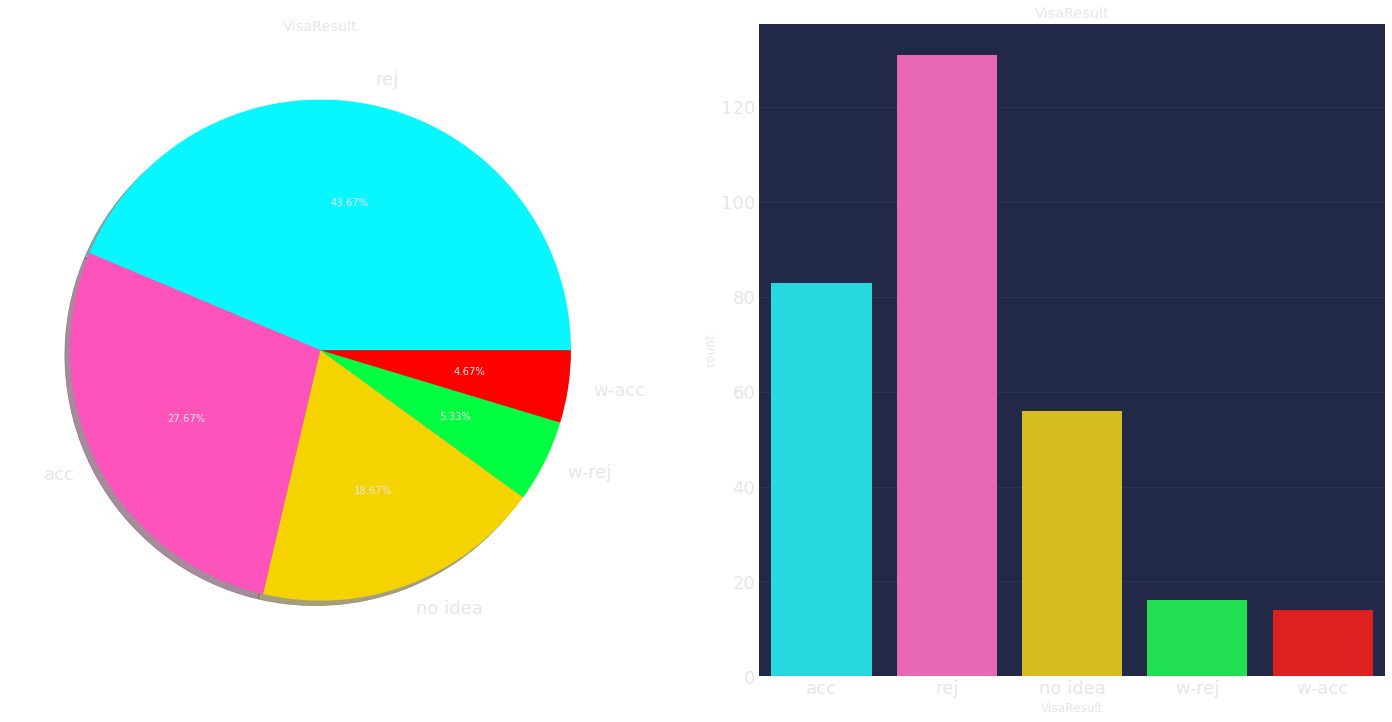

In [21]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data['VisaResult'].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True)
ax[0].set_title('VisaResult')
ax[0].set_ylabel('')
sns.countplot('VisaResult', data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('VisaResult')
plt.show()

We don't have the labels for %18 of our data, but we have weak labels for around %10. In this way, we can revive 80% of labels by doing weak supervised learning. Check [Snorkel](https://www.snorkel.org/get-started/) for more information. 

### P1.AdultFlag -> categorical

In [22]:
data.groupby(['P1.AdultFlag','VisaResult'])['VisaResult'].count()

P1.AdultFlag  VisaResult
False         acc             1
              rej             1
True          acc            82
              no idea        56
              rej           130
              w-acc          14
              w-rej          16
Name: VisaResult, dtype: int64

In [23]:
data[data['P1.AdultFlag'] == False]

,P1.AdultFlag,P1.PD.ServiceIn.ServiceIn,P1.PD.VisaType.VisaType,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.PlaceBirthCity,P1.PD.PlaceBirthCountry,P1.PD.Citizenship.Citizenship,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.CurrCOR.Row2.Other,P1.PD.PCRIndicator,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row2.Status,P1.PD.PrevCOR.Row3.Country,P1.PD.PrevCOR.Row3.Status,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaRe

Ok, useless kids, dropping all of them, and hence, the entire `P1.AdultFlag` flag

In [24]:
data.drop('P1.AdultFlag', axis=1, inplace=True)

### P1.PD.ServiceIn.ServiceIn -> categorical

In [25]:
data.groupby(['P1.PD.ServiceIn.ServiceIn','VisaResult'])['VisaResult'].count()

P1.PD.ServiceIn.ServiceIn  VisaResult
1.0                        acc            83
                           no idea        56
                           rej           131
                           w-acc          14
                           w-rej          16
Name: VisaResult, dtype: int64

In [26]:
# drop useless
data.drop('P1.PD.ServiceIn.ServiceIn', axis=1, inplace=True)

### P1.PD.ServiceIn.ServiceIn -> categorical

In [27]:
data.groupby(['P1.PD.VisaType.VisaType','VisaResult'])['VisaResult'].count()

P1.PD.VisaType.VisaType  VisaResult
VisitorVisa              acc            83
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

In [28]:
# drop useless
data.drop('P1.PD.VisaType.VisaType', axis=1, inplace=True)

### P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator -> categorical

In [29]:
output_name = 'VisaResult'
feature_name = 'P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  VisaResult
False                                                  acc            76
                                                       no idea        54
                                                       rej           118
                                                       w-acc          12
                                                       w-rej          16
True                                                   acc             7
                                                       no idea         2
                                                       rej            13
                                                       w-acc           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


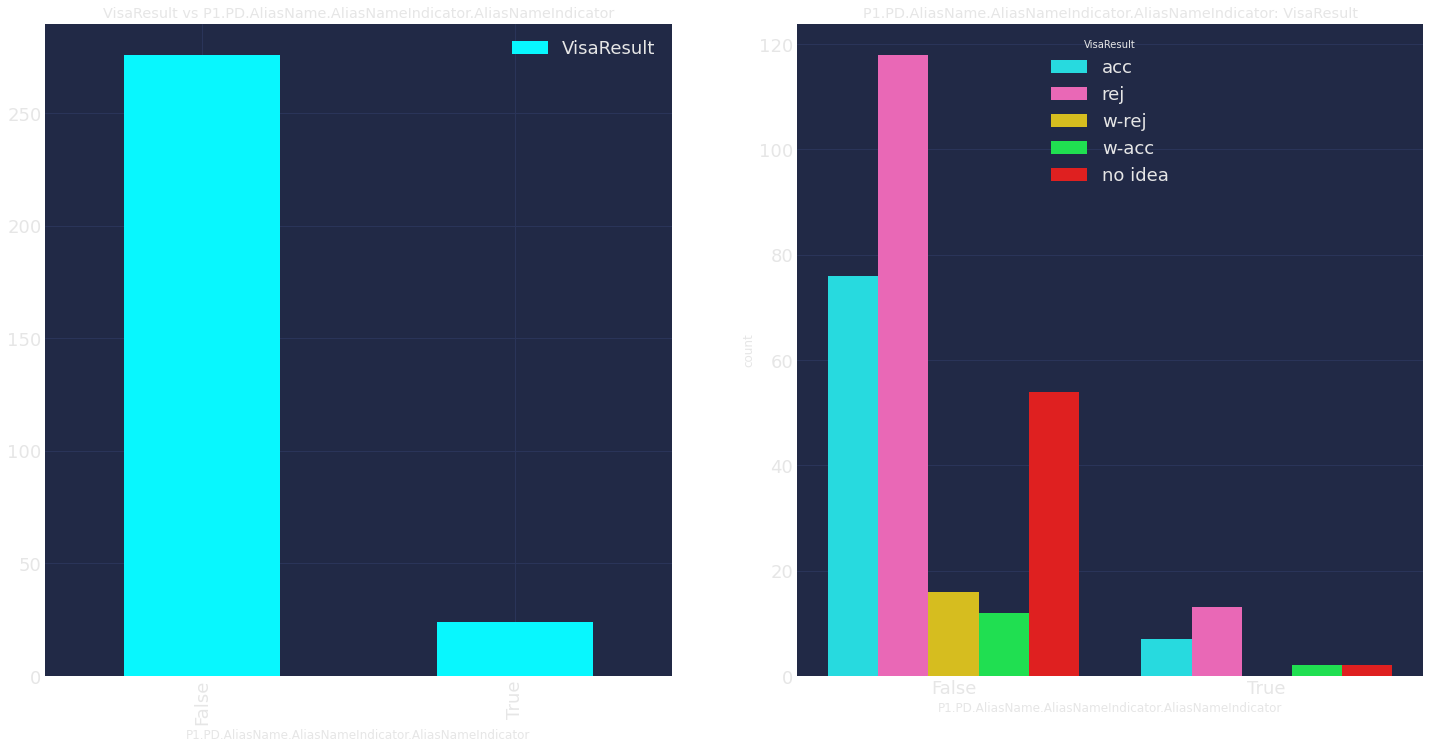

In [30]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

TODO: They seem proportional, for now, we skip it, but if after modeling, we didn't find any improvement by including this feature, we must remove it.

### P1.PD.Sex.Sex -> categorical

In [31]:
output_name = 'VisaResult'
feature_name = 'P1.PD.Sex.Sex'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.Sex.Sex  VisaResult
Female         acc           47
               no idea       28
               rej           60
               w-acc          6
               w-rej          9
Male           acc           36
               no idea       28
               rej           71
               w-acc          8
               w-rej          7
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


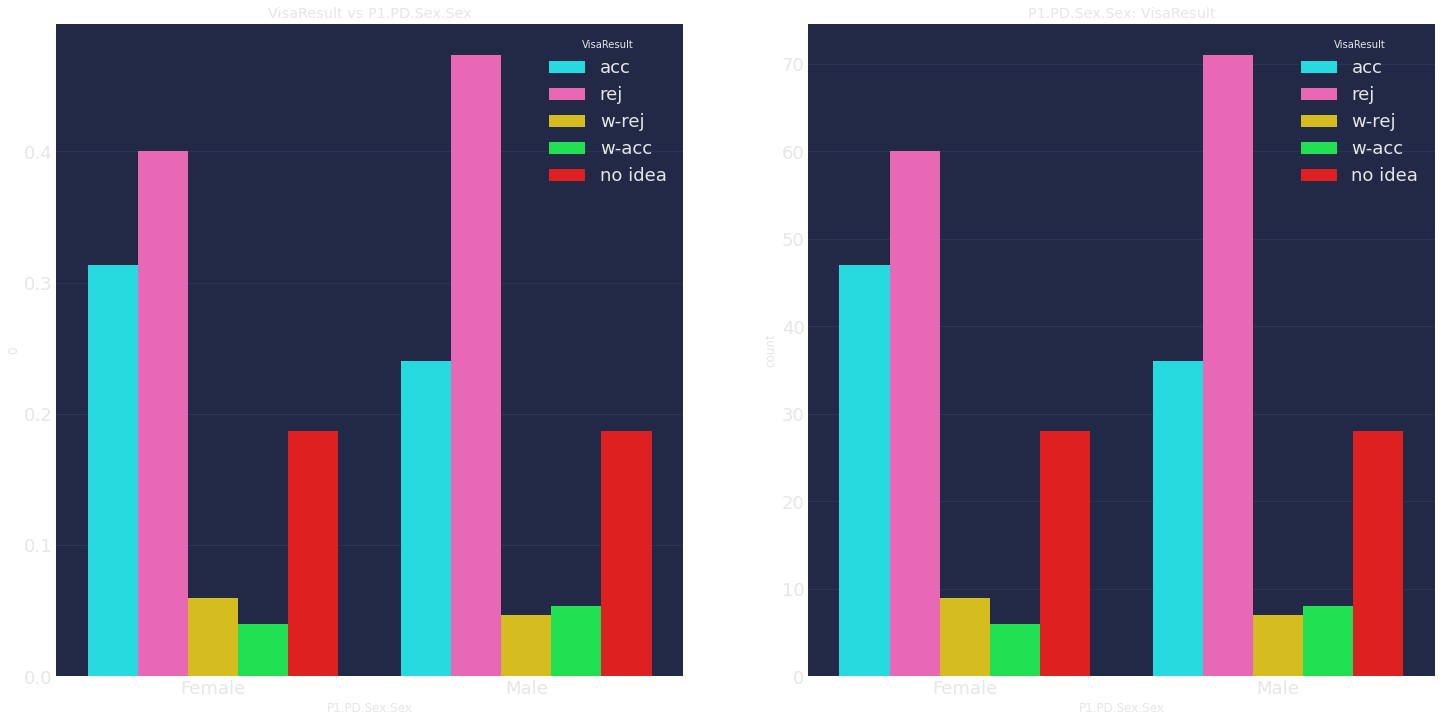

In [32]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
z = data[[feature_name, output_name]].groupby(
    [feature_name]).value_counts(normalize=True).reset_index()
sns.barplot(x=feature_name, y=0, hue=output_name, data=z, ax=ax[0], hue_order=output_hue_order)
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

**It seems that women are getting more visas than man, even though the number of applicants in term of gender are almost equal.**

### P1.PD.PlaceBirthCity -> categorical

In [33]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PlaceBirthCity'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PlaceBirthCity  VisaResult
ABADAN                acc           2
                      no idea       1
AHVAZ                 acc           1
                      rej           2
                      w-acc         2
                                   ..
Tehran                rej           4
VARAMIN               no idea       1
ZANJAN                acc           2
                      no idea       2
esfahan               no idea       1
Name: VisaResult, Length: 118, dtype: int64

In [34]:
pd.crosstab(data[feature_name], data[output_name],
            margins=True).style.background_gradient(cmap='summer_r')

VisaResult,acc,no idea,rej,w-acc,w-rej,All
P1.PD.PlaceBirthCity,,,,,,
ABADAN,2,1,0,0,0,3
AHVAZ,1,0,2,2,0,5
AMOL,0,1,0,0,0,1
ANDIMESHK,1,0,1,0,0,2
ARAK,0,0,2,0,0,2
ARDEBIL,4,0,2,0,0,6
Abadan,0,0,1,0,0,1
BABOL,1,1,1,2,0,5
BAFGH,0,0,1,0,0,1


The data fro other cities except Tehran, Karaj and Shiraz is too small to matter. At the end of the day, the value of land is summarized into assets, so no point in this, hence deleted.

In [35]:
# drop useless
data.drop('P1.PD.PlaceBirthCity', axis=1, inplace=True)

### P1.PD.PlaceBirthCountry -> categorical

In [36]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PlaceBirthCountry'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PlaceBirthCountry  VisaResult
059                      rej             1
226                      no idea         1
IRAN                     acc            83
                         no idea        55
                         rej           130
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

Well, all are from damned Iran, so let's drop it.

In [37]:
# drop useless
data.drop('P1.PD.PlaceBirthCountry', axis=1, inplace=True)

### P1.PD.Citizenship.Citizenship -> categorical

In [38]:
output_name = 'VisaResult'
feature_name = 'P1.PD.Citizenship.Citizenship'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.Citizenship.Citizenship  VisaResult
IRAN                           acc            83
                               no idea        56
                               rej           129
                               w-acc          14
                               w-rej          16
TURKEY                         rej             2
Name: VisaResult, dtype: int64

In [39]:
# drop useless
data.drop('P1.PD.Citizenship.Citizenship', axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Country -> categorical

In [40]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CurrCOR.Row2.Country  VisaResult
280                         acc             1
511                         acc             1
IRAN                        acc            81
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

511 is Canada and someone who has residency of Canada absolutely needs to be excluded as an anomaly.

In [41]:
data.drop(data[data[feature_name] == '511'].index, inplace=True)

In [42]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


In [43]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [44]:
data[feature_name].unique()

array([1.10715442, 2.33984284])

It is hard to say that how having different country of residence than IRAN effects the output variable. So know more about it, especially if it is **anomaly** or not, we currently skip it and after having a clean data, we use visualization, statistical or ML methods to figure this out. [See this for more information](https://www.analyticsvidhya.com/blog/2021/04/dealing-with-anomalies-in-the-data/)

We can also make this into categorical, [`IRAN`, `OTHER`] and simplify things, but if it's anomaly, I prefer fixing it.

TODO: last priority but mandatory

### P1.PD.CurrCOR.Row2.Status -> categorical

In [45]:
data[data['P1.PD.CurrCOR.Row2.Country'] != 'IRAN']['P1.PD.CurrCOR.Row2.Status']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
300    1.0
301    1.0
302    1.0
303    1.0
304    1.0
Name: P1.PD.CurrCOR.Row2.Status, Length: 299, dtype: float64

Similar as [P1.PD.CurrCOR.Row2.Country](#P1.PD.CurrCOR.Row2.Country)

### P1.PD.CurrCOR.Row2.Other -> categorical

In [46]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Other'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CurrCOR.Row2.Other  VisaResult
False                     acc            82
                          no idea        56
                          rej           131
                          w-acc          14
                          w-rej          16
Name: VisaResult, dtype: int64

In [47]:
# drop useless
data.drop('P1.PD.CurrCOR.Row2.Other', axis=1, inplace=True)

### P1.PD.PCRIndicator -> categorical

In [48]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PCRIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PCRIndicator  VisaResult
False               acc            76
                    no idea        56
                    rej           128
                    w-acc          14
                    w-rej          12
True                acc             6
                    rej             3
                    w-rej           4
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


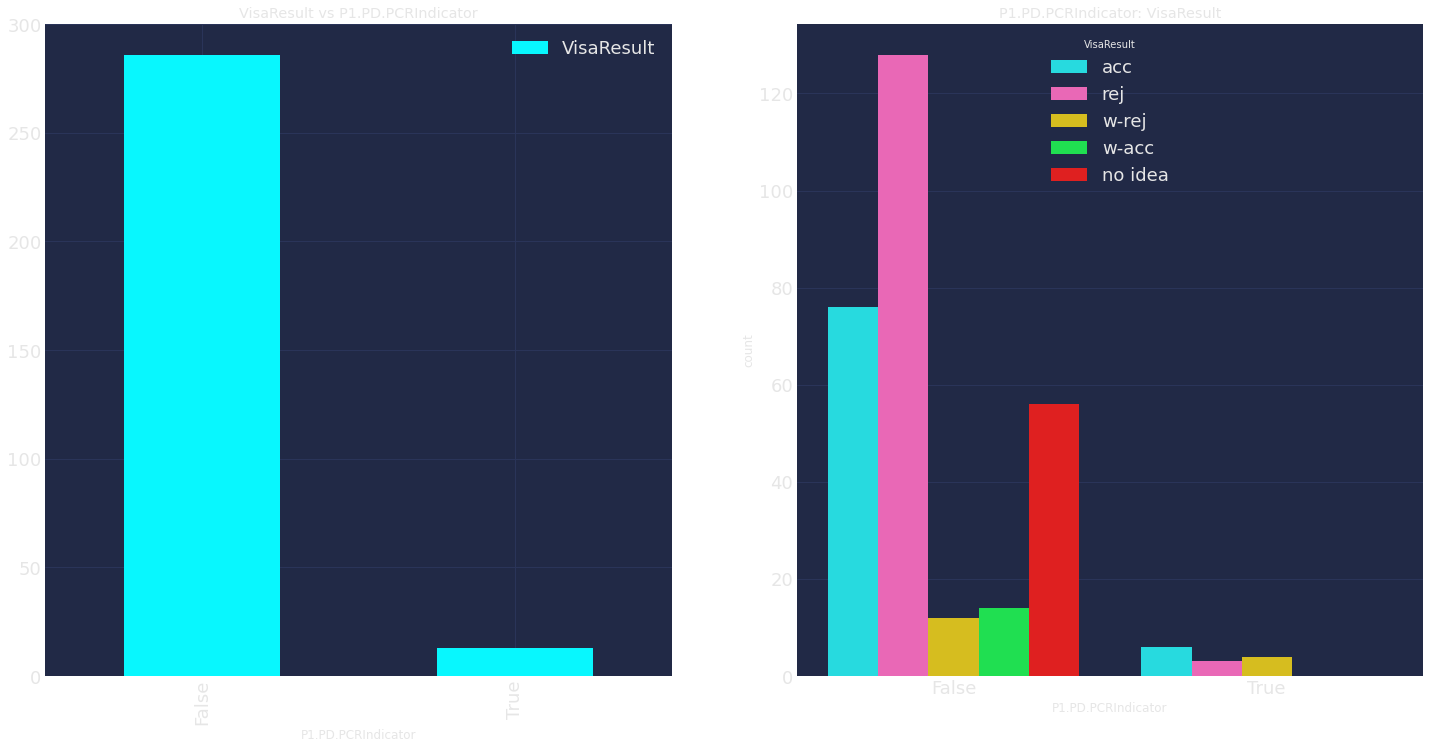

In [49]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

It is hard to say, but having previous country of residence has higher acceptance rate than none ones. Well, this is maybe the case, because they showed that they have resided in third-party countries and went back to their home country.

### P1.PD.PrevCOR.Row[i].\* -> categorical

In [50]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

Ok, we have good amount of examples that cannot be ignored or labeled as anomaly.

The main issue here is that the countries are so diverse that cannot be considered. To fix this, we consider label feature `P1.PD.PCRIndicator` which is a binary variable indicating if the candidate has had previous country of residence or not. The below cell confirms this, so we drop this column and second row of the same info, i.e. `P1.PD.PrevCOR.Row2.Country`, `P1.PD.PrevCOR.Row2.Status`, `P1.PD.PrevCOR.Row3.Country`, `P1.PD.PrevCOR.Row3.Status`.

All these columns can be integrated into another column, aggregating all of these into sum of non-`OTHER` status for PrevCOR, simply put, the count of previous countries of residence. In this case, `0` means no PCR, so we can get rid of `P1.PD.PCRIndicator` too.

In [51]:
data[data['P1.PD.PCRIndicator'] == True].groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej         2
028                         acc           1
                            rej           2
034                         acc           1
052                         acc           2
202                         w-rej         1
224                         w-rej         1
226                         rej           1
280                         acc           1
TURKEY                      acc           1
Name: VisaResult, dtype: int64

In [52]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

In [53]:
output_name = 'VisaResult'
data.groupby(['P1.PD.PrevCOR.Row2.Status', 'P1.PD.PrevCOR.Row3.Status']).size()

P1.PD.PrevCOR.Row2.Status  P1.PD.PrevCOR.Row3.Status
2.0                        6.0                            1
3.0                        3.0                            1
                           6.0                            1
4.0                        6.0                            3
5.0                        6.0                            3
6.0                        6.0                          290
dtype: int64

In [54]:
from functools import reduce
import re
r = re.compile('P1.PD.PrevCOR.Row..Period')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_names = list(data.columns.values[mask])


def previous_residency_country_count(series: pd.Series):
    # 6 means no previous country of residency
    return reduce(lambda x, y: 2 - np.sum(np.isin([x, y], [0])), series)


# replace rows of previous country of residency to count of them
data['P1.PD.PrevCOR.Row.Count'] = data[feature_names].agg([previous_residency_country_count], axis=1)
data = data.rename(
    columns={previous_residency_country_count.__name__: 'P1.PD.PrevCOR.Row.Count'})

# delete redundant columns tnx to newly created 'P1.PD.PrevCOR.Row.Count'
data.drop(['P1.PD.PrevCOR.Row2.Status', 'P1.PD.PrevCOR.Row3.Status', 'P1.PD.PCRIndicator'], axis=1, inplace=True)

In [55]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Period', 'P1.PD.PrevCOR.Row3.Period', 'P1.PD.PrevCOR.Row.Count'
data.groupby([*feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Period  P1.PD.PrevCOR.Row3.Period  P1.PD.PrevCOR.Row.Count  VisaResult
0.0                        0.0                        0                        acc            76
                                                                               no idea        56
                                                                               rej           128
                                                                               w-acc          14
                                                                               w-rej          12
140.0                      0.0                        1                        w-rej           1
163.0                      0.0                        1                        rej             1
183.0                      0.0                        1                        acc             1
208.0                      0.0                        1                        acc             1
303.0                      0.0       

In [56]:
data.head()

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
0,False,Female,1.107154,1.0,OTHER,OTHER,True,OTHER,6.0,False,01,False,OTHER,IRAN,IRAN,Neither,False,True,IRAN,False,False,False,8.0,False,10000.0,SON,OTHER,False,<NA>,IRAN,PERSIAN/PICTURE CARPET WEAVER,IRA

#### P1.PD.PrevCOR.Row[i].Country -> categorical -> continuous

In [57]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

In [58]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


In [59]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [60]:
data[feature_name].unique()

array([1.42985636, 1.75289541, 1.32752412, 1.14233002, 2.33984284,
       2.09999266, 1.        , 1.97140976, 1.16178083, 1.30392442])

In [61]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row3.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row3.Country  VisaResult
280                         acc             1
OTHER                       acc            81
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

In [62]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


In [63]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [64]:
data[feature_name].unique()

array([1.42985636, 2.33984284])

### P1.PD.SameAsCORIndicator -> categorical

In [65]:
output_name = 'VisaResult'
feature_name = 'P1.PD.SameAsCORIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.SameAsCORIndicator  VisaResult
False                     acc            75
                          no idea        56
                          rej           126
                          w-acc          14
                          w-rej          13
True                      acc             7
                          rej             5
                          w-rej           3
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


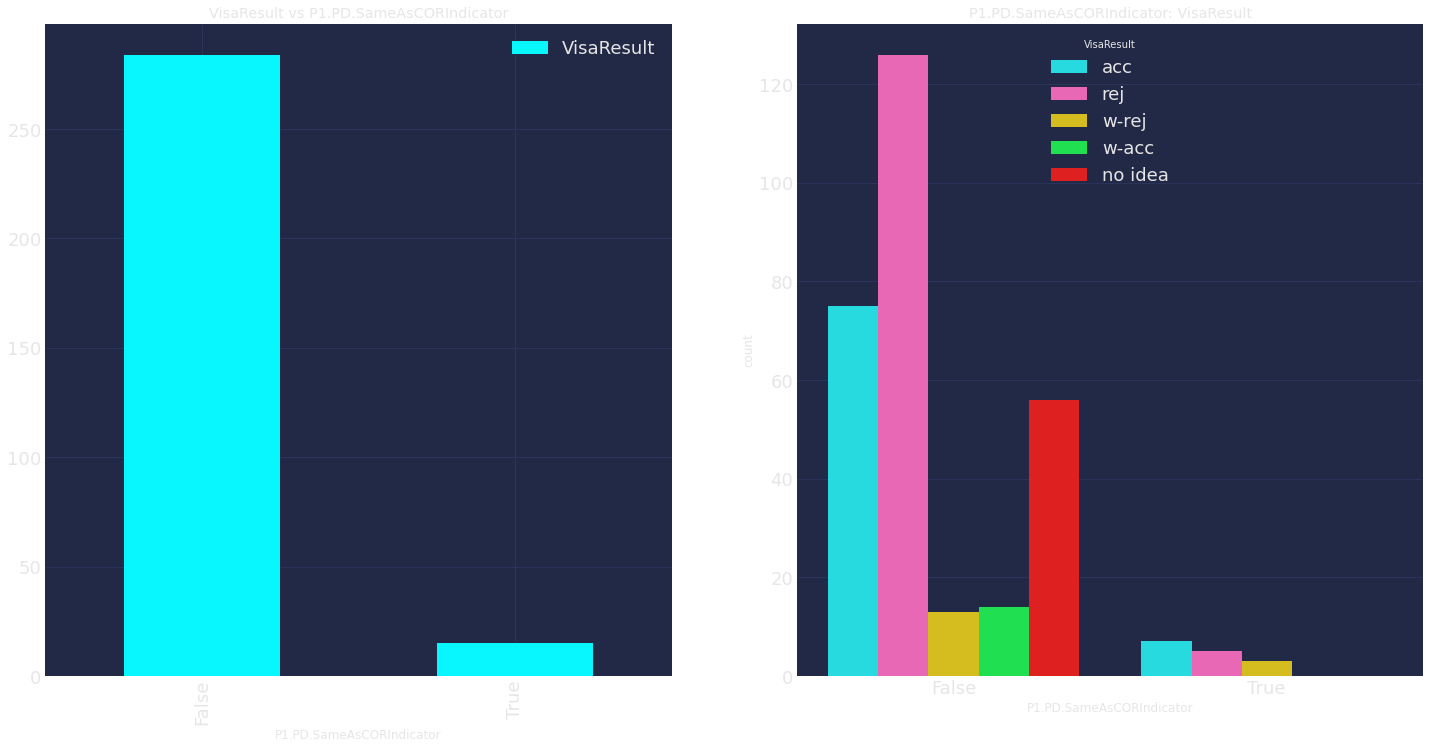

In [66]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


It seems that having residency of other countries improves the chance of getting the visa. Seems like that the person had a choice to be the citizen of any country (by being refugee of course) but legally has chosen another country than the visiting country (here Canada). I.e. the person has no intention to go back to Iran, but no intention to stay in Canada too, a third-party country is taking care of it!

### P1.PD.CWA.Row2.Country -> categorical

In [67]:
output_name = 'VisaResult'
feature_name = ['P1.PD.CWA.Row2.Country', 'P1.PD.PrevCOR.Row.Count']
data.groupby([*feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Country  P1.PD.PrevCOR.Row.Count  VisaResult
022                     0                        rej             2
049                     0                        w-acc           1
052                     0                        acc             2
                                                 rej             3
                        1                        acc             1
059                     0                        rej             1
224                     0                        rej             3
242                     0                        no idea         1
263                     0                        rej             1
280                     0                        rej             4
IRAN                    0                        acc             1
                                                 rej             2
                                                 w-rej           2
OTHER                   0                        acc             6
  

In [68]:
# convert numbers to countries and transform them into categories that are more frequent

number_to_country = {
    '049': 'Armenia',
    '052': 'Georgia',
    '280': 'UAE',
    'IRAN': 'TURKEY',  # CWA cannot be Iran, prob Turkey
    'OTHER': 'TURKEY',  # CWA cannot be OTHER, pro Turkey
    'TURKEY': 'TURKEY',
}

def fix_cwa(string: str, dic):
    if string in dic.keys():
        string = string.replace(string, dic[string])
    else:
        string = 'OTHER'
    return string

feature_name = 'P1.PD.CWA.Row2.Country'
data[feature_name] = data[feature_name].apply(
    func=fix_cwa, args=(number_to_country, ))


In [69]:
data['P1.PD.CWA.Row2.Country'].unique()

array(['TURKEY', 'OTHER', 'Georgia', 'UAE', 'Armenia'], dtype=object)

In [70]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Country  VisaResult
Armenia                 w-acc           1
Georgia                 acc             3
                        rej             3
OTHER                   no idea         1
                        rej             7
TURKEY                  acc            79
                        no idea        55
                        rej           117
                        w-acc          13
                        w-rej          16
UAE                     rej             4
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


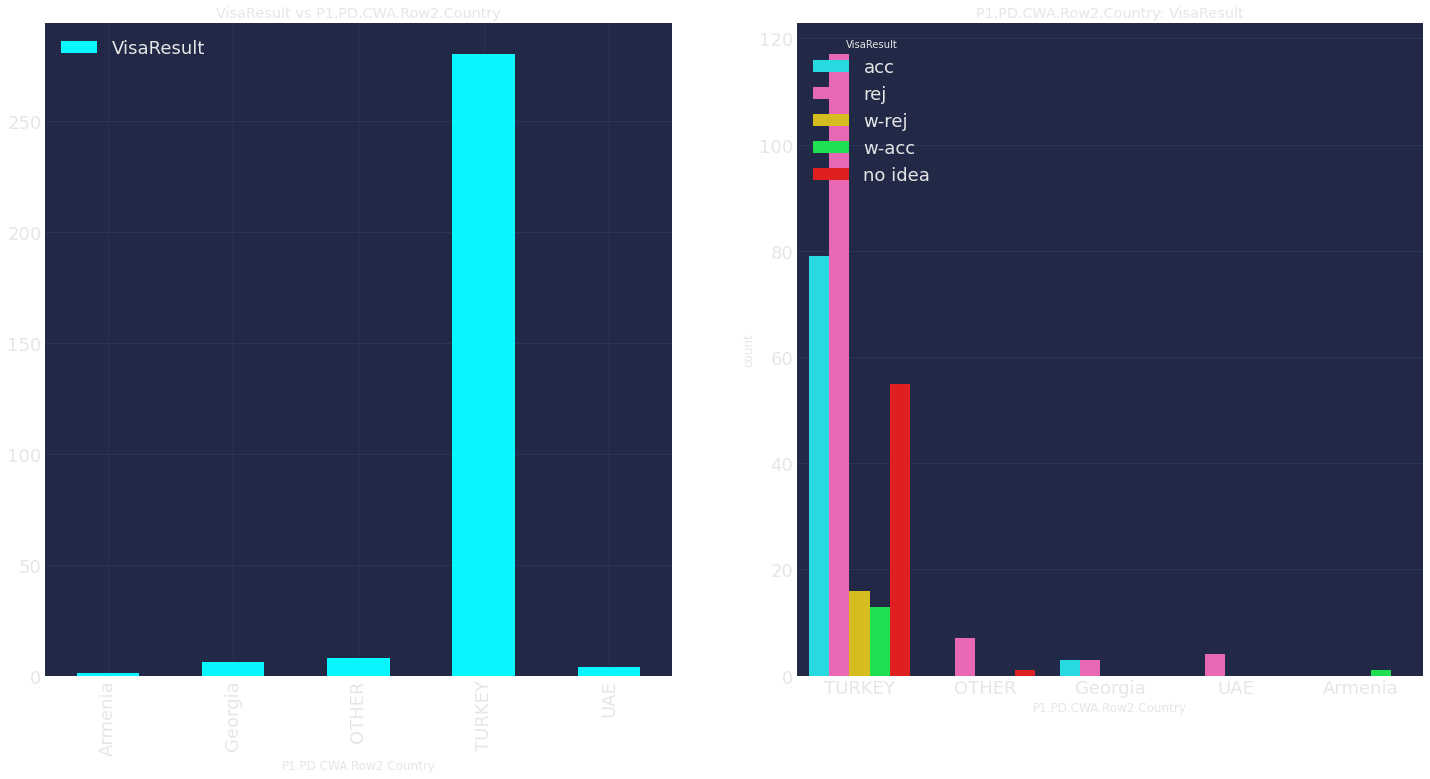

In [71]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

Here, we just are considering countries that usually someone can apply from, which for Iranians, it's Armenia, Georgia, United Arab Emirates, and Turkey.

Note that, we had CWA cases where the person applied from France, or Iraq. Separately categorizing these might be harder, but we can tell that the person whose CWA is france, already has residency status or travel history that making the case stronger, so other variables dominate affect of this.

*Remark:* My goal for including this feature is that to see if there is bias toward specific countries. I.e. in some Reddit (which is legit) post, people mentioned that UAE cases for non UAE cases usually have higher rate of rejection. 


- [ ] TODO: lets find any dataset/news of tourism visa stats w.r.t. countries.

### P1.PD.CWA.Row2.Status -> categorical

In [72]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Status  VisaResult
1.0                    acc            1
                       no idea        1
                       rej            4
                       w-acc          2
3.0                    acc           63
                       no idea       20
                       rej           60
                       w-acc          6
                       w-rej          8
6.0                    acc           18
                       no idea       35
                       rej           67
                       w-acc          6
                       w-rej          8
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


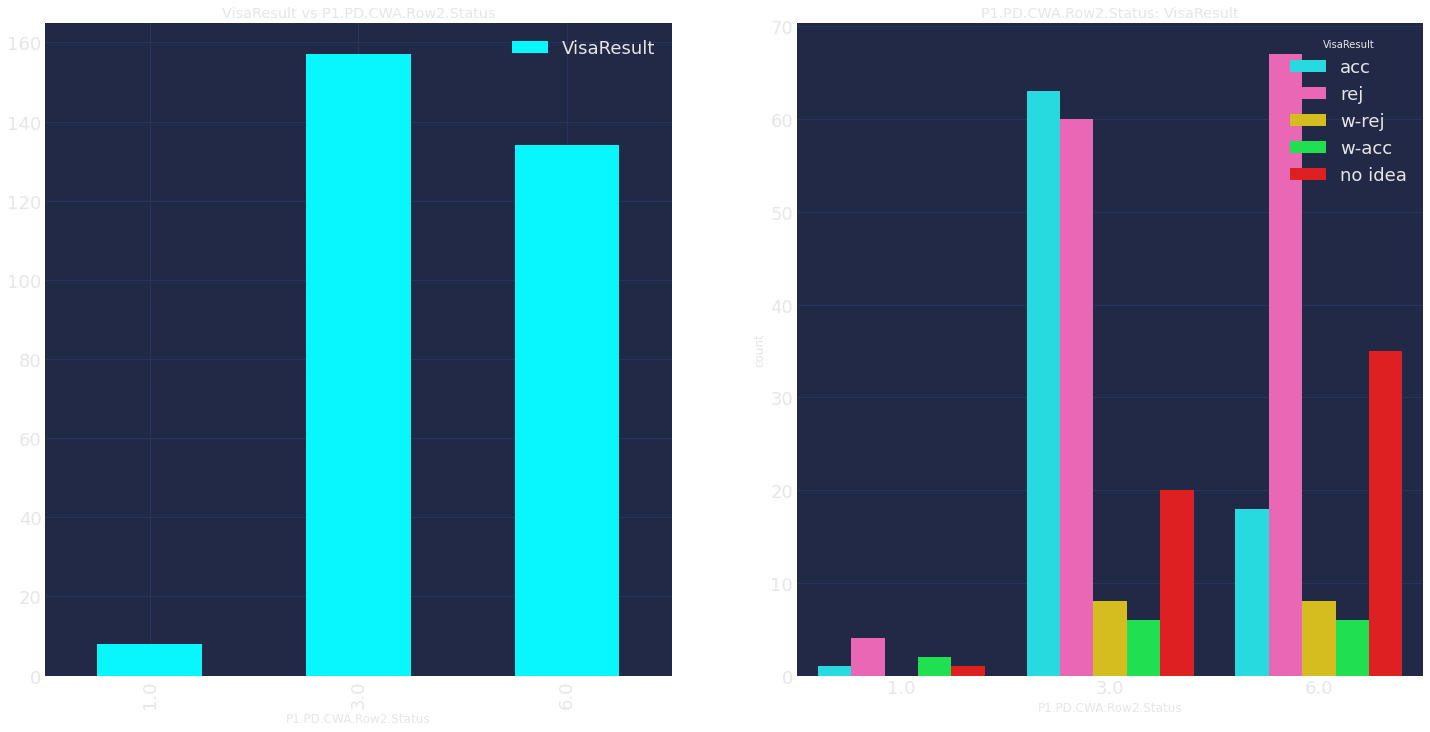

In [73]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

The interesting observation is that there is huge difference between who choose state of their visit to CWA as VISITOR=3 vs OTHER(Biometric)=6. *I think the reason is that those who choose visitor are way richer on average*, because they need to at least stay there for 2 weeks which costs far more than Biometric visit. Let's see if we are right in the following cells:

In [74]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status', 'P1.PD.CWA.Row2.Period'

pd.crosstab([data[feature_name[0]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name]], data[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')

In [75]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status', 'P1.PD.CWA.Row2.Period'
data.groupby([*feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Status  P1.PD.CWA.Row2.Period  VisaResult
1.0                    30.0                   acc            1
                                              rej            3
                       31.0                   rej            1
                                              w-acc          2
                       90.0                   no idea        1
                                                            ..
6.0                    90.0                   rej           15
                                              w-acc          1
                       92.0                   rej           14
                                              w-rej          1
                       93.0                   rej            1
Name: VisaResult, Length: 54, dtype: int64

### Fill CWA NaN and 0 periods with a heuristic
We could go with average, but apparently data is more like discrete where applicants stayed in months rather than weeks/days. Hence, `mode` is a better feature than `mean` as it falls to dominating value.

In [76]:
data.loc[(data[feature_name[1]] == 0) | (data[feature_name[1]].isna()), feature_name[1]] = data[data[feature_name[1]] != 0][feature_name[1]].mode()
data[feature_name[1]].unique()

array([30., 31., 29., 92., 89., 28., 90., nan, 91., 77., 93., 61., 37.])

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


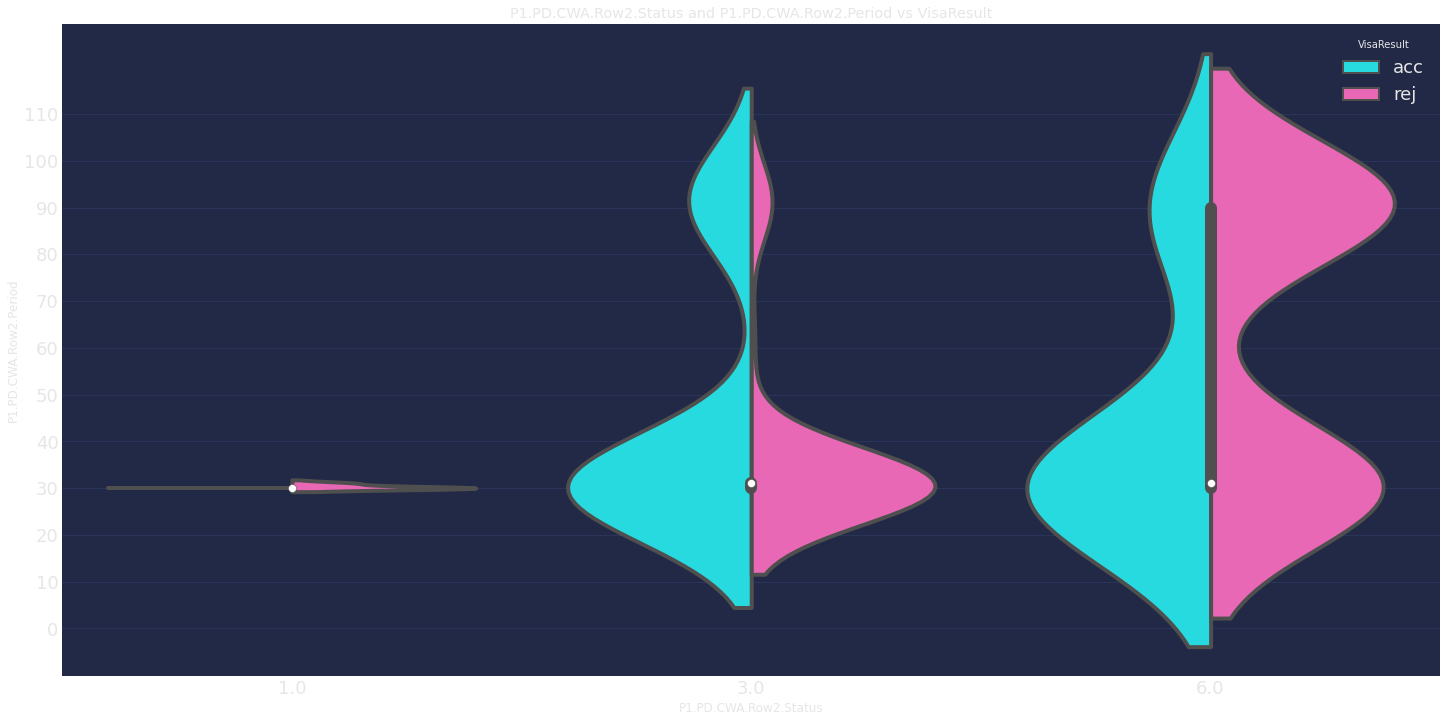

In [77]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.violinplot(feature_name[0], feature_name[1], hue=output_name, scale='width',
               data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], split=True, ax=ax)
ax.set_title('{} and {} vs {}'.format(
    feature_name[0], feature_name[1], output_name))
ax.set_yticks(range(0, 120, 10))
plt.show()

Well, I WAS WRONG. For some reason, where CWA status is `'OTHER'`, people are mostly staying for 90 days, meanwhile for status of Visitor, the duration is mostly around 30 days. The reason it's weird is that usually CWA status of `'OTHER'` stands for `'Biometric'` case and 90 days mode does not make sense!

TODO: what's going on? ask agents!

### P1.PD.CWA.Row2.Other -> categorical

In [78]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Other'
data.groupby([feature_name, 'P1.PD.CWA.Row2.Status'])[
    output_name].count()

P1.PD.CWA.Row2.Other  P1.PD.CWA.Row2.Status
False                 1.0                        8
                      3.0                      157
                      6.0                       15
True                  6.0                      119
Name: VisaResult, dtype: int64

All the cases that have flag `'P1.PD.CWA.Row2.Other'=True` are in  `'P1.PD.CWA.Row2.Status'=6` which means status of 6 is already representing other case. So, we delete it.

In [79]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.MS.SecA.MS -> categorical

In [80]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.MS'
data.groupby([feature_name, output_name])[output_name].count()

P1.MS.SecA.MS  VisaResult
01             acc           65
               no idea       48
               rej           95
               w-acc         12
               w-rej         11
02             acc           10
               no idea        7
               rej           29
               w-acc          2
               w-rej          5
04             acc            5
               no idea        1
               rej            5
06             acc            2
               rej            2
Name: VisaResult, dtype: int64

In [81]:
# convert numbers to names
ms_num_names = {
    '01': 'married',
    '02': 'single',
    '03': 'common-law',
    '04': 'divorced',
    '05': 'separated',
    '06': 'widowed',
    '09': 'annulled',
    '00': 'ukn',
}

data[feature_name] = data[feature_name].apply(lambda x: ms_num_names[x]
                                              if x in ms_num_names else 'ukn')


/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


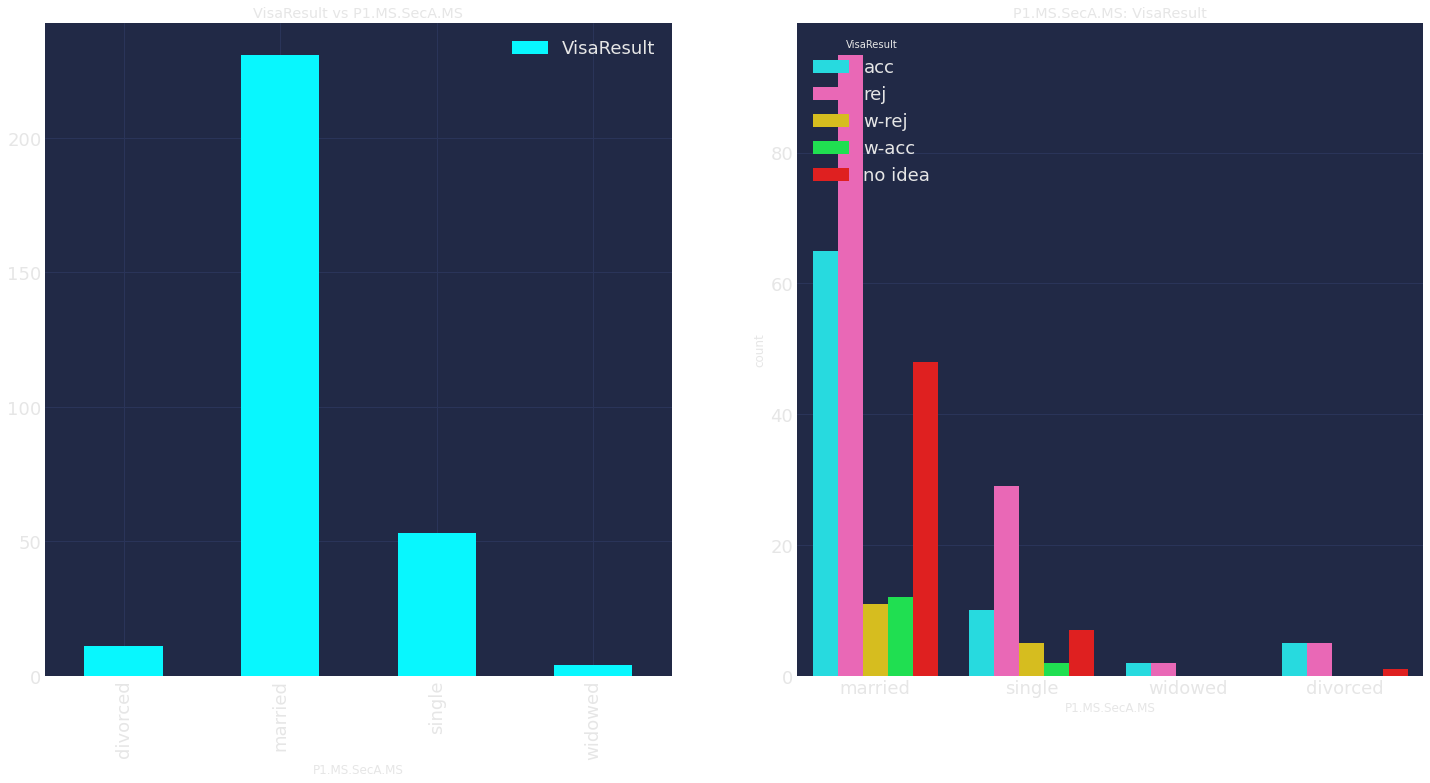

In [82]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


It is clear that *single people (necessarily those who have never married) are way more likely to get rejected*, since single people are way more likely to stay. 

### P2.MS.SecA.PrevMarrIndicator -> categorical

In [83]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevMarrIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.PrevMarrIndicator  VisaResult
False                         acc            69
                              no idea        53
                              rej           123
                              w-acc          14
                              w-rej          14
True                          acc            13
                              no idea         3
                              rej             8
                              w-rej           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


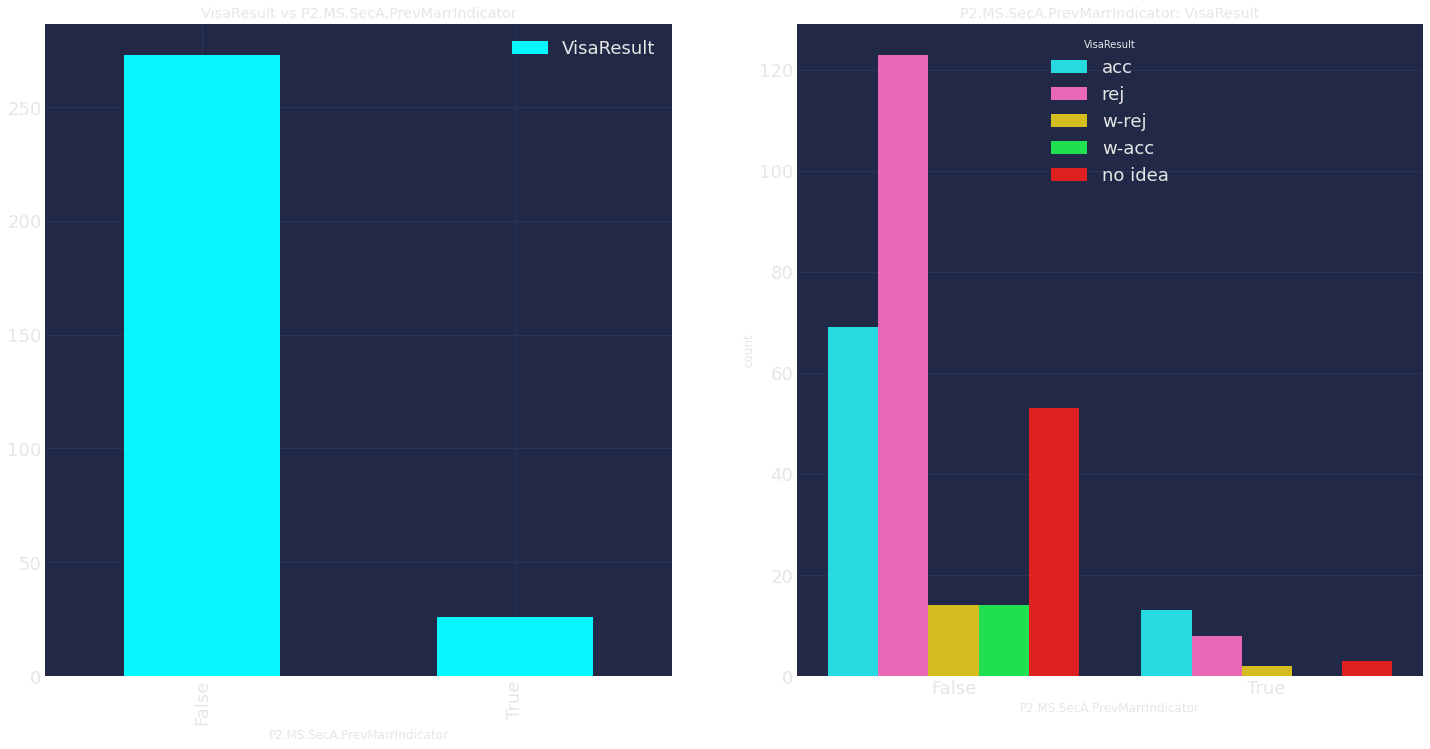

In [84]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


We can see that those who have previous marriage have higher chance, but this could be directly because of the age, since someone with previous marriage is probably more like to have higher age, and higher income (well, women get a lot of money for getting divorced for some unknown reason and those who can divorce usually have higher status as it is rarer to happen in traditional families.)

In [85]:
feature_name = 'P2.MS.SecA.PrevMarrIndicator', 'P1.PD.Sex.Sex'

pd.crosstab([data[feature_name[0]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name]], data[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')

### P2.MS.SecA.TypeOfRelationship -> categorical

In [86]:
# convert numbers to names
ms_num_names = {
    '01': 'married',
    '02': 'single',
    '03': 'common-law',
    '04': 'divorced',
    '05': 'separated',
    '06': 'widowed',
    '09': 'annulled',
    '00': 'ukn',
}

output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.TypeOfRelationship'

data[feature_name] = data[feature_name].apply(lambda x: ms_num_names[x]
                                              if x in ms_num_names else 'ukn')  # keep it 'ukn' since we have this category in XFA PDFs too
                                                                                #   although here it means that there was no previous marriage.

data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.TypeOfRelationship  VisaResult
married                        acc            13
                               no idea         3
                               rej             8
                               w-rej           2
ukn                            acc            69
                               no idea        53
                               rej           123
                               w-acc          14
                               w-rej          14
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


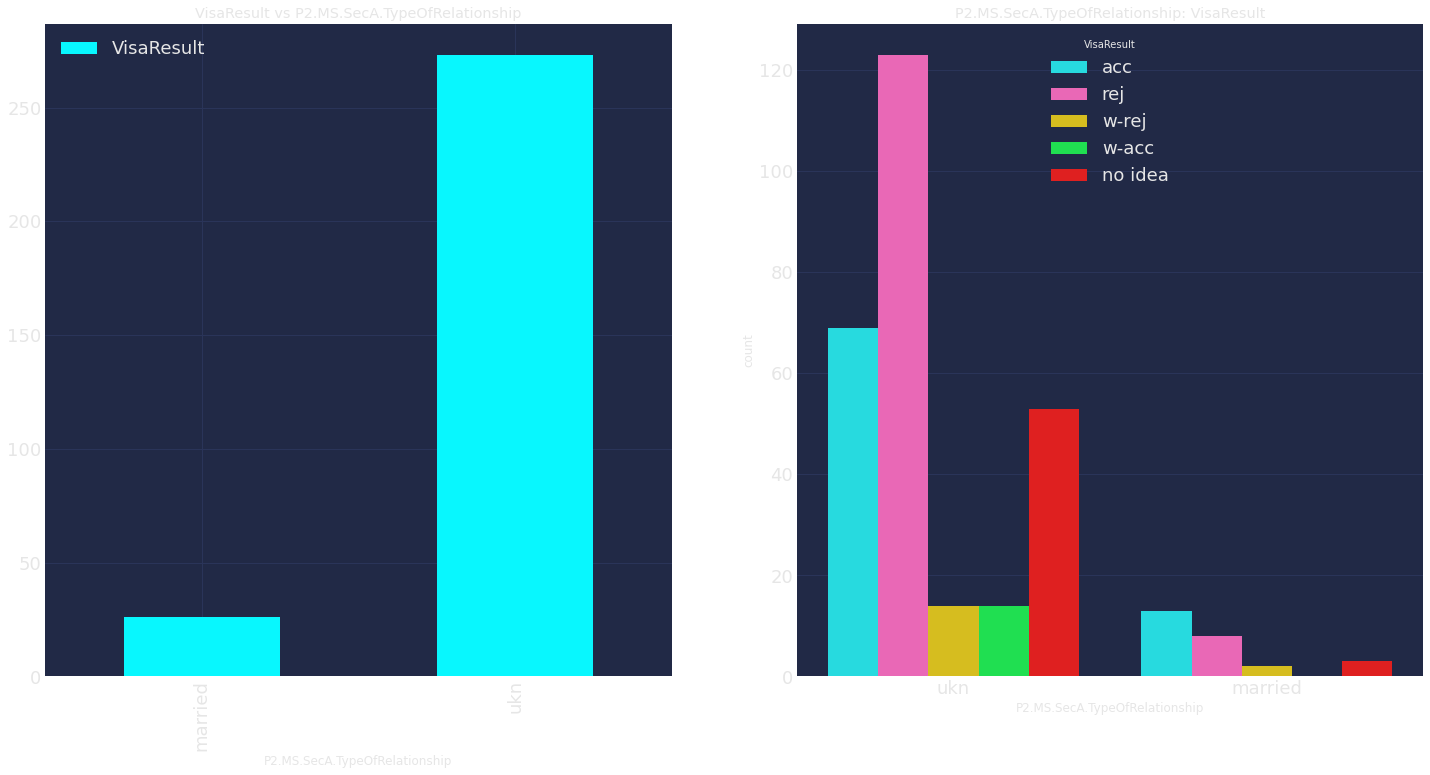

In [87]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


Since we have only type of `'married'`, `'ukn'` represents cases where there was no previous marriage. Hence, feature in previous section, i.e. `'P2.MS.SecA.PrevMarrIndicator'` is representing the exact same thing. On the other hand, common-law marriage is not legal in Iran and as we can see, there is not a single case of it. So even in future, we can just ignore it or replace it with married case. So, we can delete it.

In [88]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue -> categorical

In [89]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  VisaResult
059                                             rej             1
IRAN                                            acc            82
                                                no idea        56
                                                rej           128
                                                w-acc          14
                                                w-rej          16
TURKEY                                          rej             2
Name: VisaResult, dtype: int64

In [90]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.languages.nativeLang.nativeLang -> categorical

In [91]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.languages.nativeLang.nativeLang'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Langs.languages.nativeLang.nativeLang  VisaResult
106                                               rej             1
251                                               rej             4
                                                  w-rej           1
IRAN                                              acc            82
                                                  no idea        56
                                                  rej           126
                                                  w-acc          14
                                                  w-rej          15
Name: VisaResult, dtype: int64

In [92]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate -> categorical

In [93]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  VisaResult
Both                                                            w-rej           1
English                                                         acc            75
                                                                no idea        55
                                                                rej           130
                                                                w-acc          14
                                                                w-rej          14
Neither                                                         acc             7
                                                                no idea         1
                                                                rej             1
                                                                w-rej           1
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


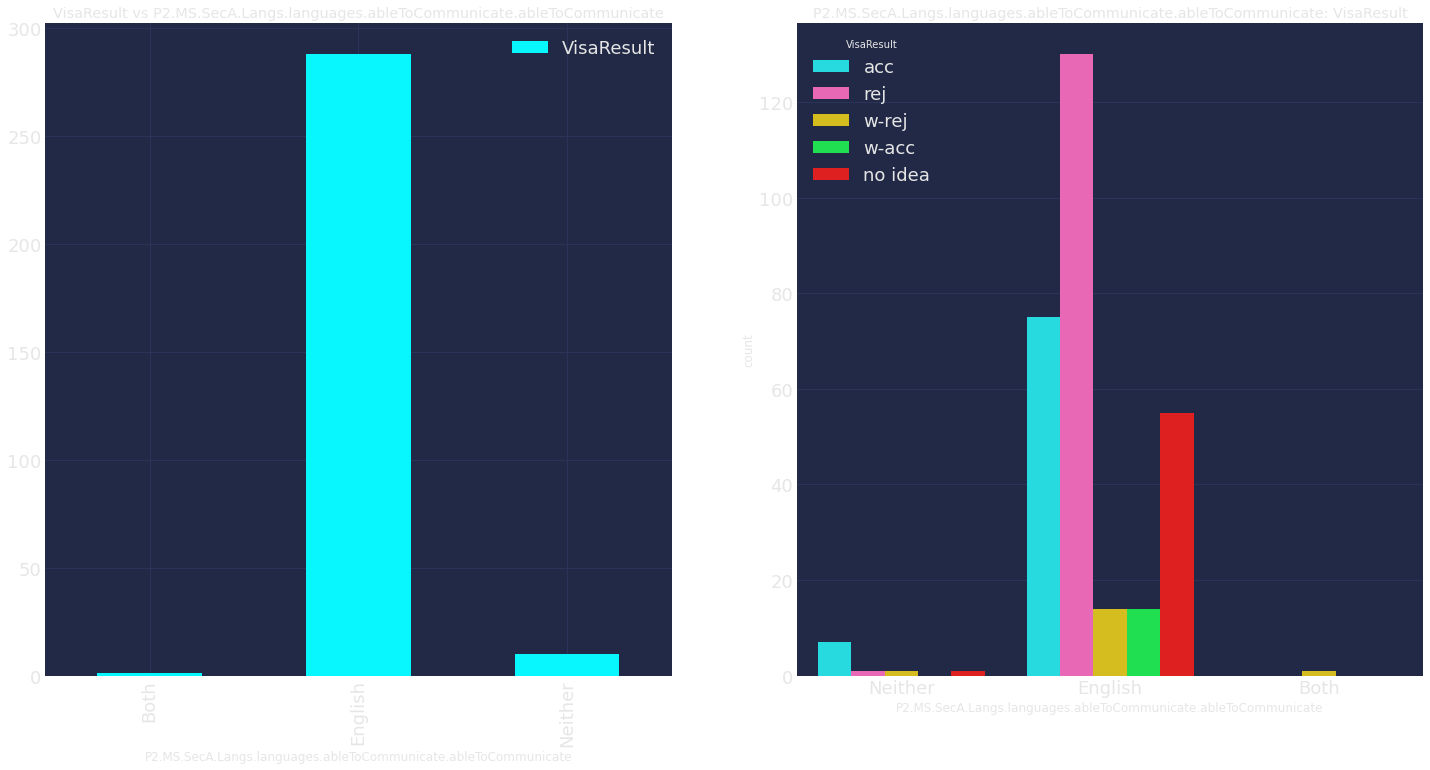

In [94]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


The data is too small to make a decision, but we see a large acceptance rate when applicant speaks no language, and the reason easily could be that the person is probably old and have a full family, i.e. who can afford to go to Canada but does not speak a second language? Old housewives and retired employees probably! Let's see if we are right for fun:

In [95]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Occ.Occ', 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
data[data[feature_name[1]] == 'Neither'].groupby([*feature_name, output_name])[output_name].count()

P3.Occ.OccRow1.Occ.Occ         P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  VisaResult
Advertising Director           Neither                                                         no idea       1
DEPUTY OF NOTARY PUBLIC        Neither                                                         rej           1
HOUSEWIFE                      Neither                                                         acc           2
                                                                                               w-rej         1
OWNER RESTAURANT-MASTER CHEF   Neither                                                         acc           1
PERSIAN/PICTURE CARPET WEAVER  Neither                                                         acc           1
RETIRED                        Neither                                                         acc           3
Name: VisaResult, dtype: int64

We were right, KEKW. But it has no useful information since it is directly affected by age, family status, etc. Hence, I delete it.

In [96]:
# drop useless
feature_name = 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.LangTest -> categorical

In [97]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.LangTest'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Langs.LangTest  VisaResult
False                      acc            80
                           no idea        56
                           rej           128
                           w-acc          14
                           w-rej          14
True                       acc             2
                           rej             3
                           w-rej           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


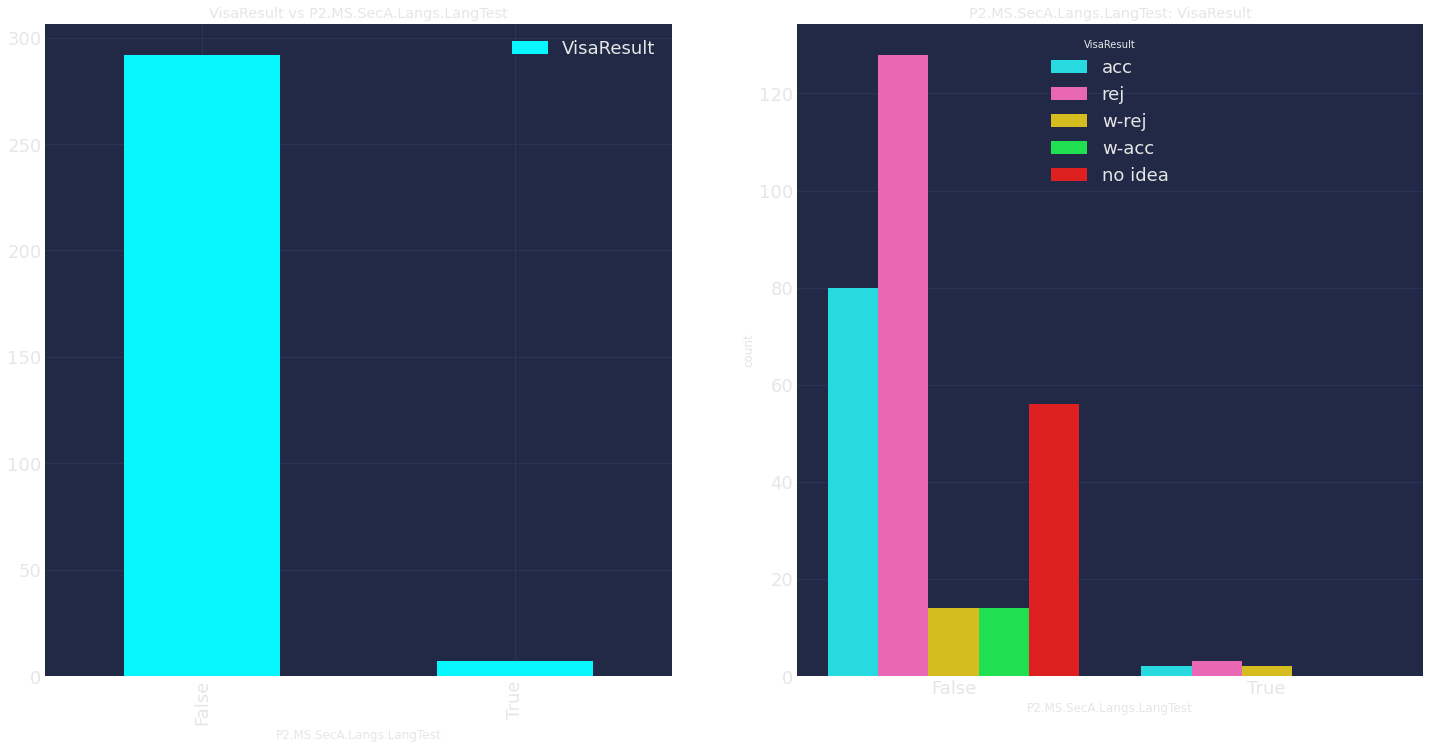

In [98]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

In [99]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

No idea! Maybe letter we can see some correlation or delete it entirely. For now, we delete it because of few samples. TODO: see what's the best, delete or not?

### P2.natID.q1.natIDIndicator -> categorical

In [100]:
output_name = 'VisaResult'
feature_name = 'P2.natID.q1.natIDIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P2.natID.q1.natIDIndicator  VisaResult
True                        acc            82
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

In [101]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)
# also this
feature_name = 'P2.natID.natIDdocs.CountryofIssue.CountryofIssue'
data.drop(feature_name, axis=1, inplace=True)

### P2.USCard.q1.usCardIndicator -> categorical

In [102]:
output_name = 'VisaResult'
feature_name = 'P2.USCard.q1.usCardIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P2.USCard.q1.usCardIndicator  VisaResult
False                         acc            82
                              no idea        56
                              rej           131
                              w-acc          14
                              w-rej          16
Name: VisaResult, dtype: int64

In [103]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.CI.cntct.PhnNums.[Phn.CanadaUS, AltPhn.CanadaUS] -> categorical

In [104]:
output_name = 'VisaResult'
feature_name = 'P2.CI.cntct.PhnNums.Phn.CanadaUS'
data.groupby([feature_name, output_name])[output_name].count()

P2.CI.cntct.PhnNums.Phn.CanadaUS  VisaResult
False                             acc            82
                                  no idea        56
                                  rej           131
                                  w-acc          14
                                  w-rej          16
Name: VisaResult, dtype: int64

In [105]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)


In [106]:
output_name = 'VisaResult'
feature_name = 'P2.CI.cntct.PhnNums.AltPhn.CanadaUS'
data.groupby([feature_name, output_name])[output_name].count()


P2.CI.cntct.PhnNums.AltPhn.CanadaUS  VisaResult
False                                acc            80
                                     no idea        56
                                     rej           131
                                     w-acc          14
                                     w-rej          16
True                                 acc             2
Name: VisaResult, dtype: int64

In [107]:
data[data[feature_name] == True]

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
55,False,Female,1.107154,1.0,1.429856,1.429856,False,TURKEY,3.0,married,False,True,8.0,False,8000.0,DAUGHTER,OTHER,False,<NA>,IRAN,RETIRED,IRAN,OTHER,IRAN,OTHER,IRAN,False,False,False,False,False,False,False,False,False,26465.0,26465.0,0.0,0.0,91.0,18309.0,0.0,0.0,1496.0,31.0,0.0,7107.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,IRAN,RETIRED,True,IRAN,DECEASED,False,9.0,IRAN,DECEASED,False,9.0,5.0,DAUGHTER,IRAN,EMPLOYEE,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,5.0,BROTHER,IRAN,RETIRED,False,5.0,BROTHER,IRAN,RETIRED,False,5.0,SISTER,IRAN,RETIR

In [108]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)


These two entries are the family of the same person with strong application. Although, indication of Canada/US phone depicts strong case, other factors should indicate the same thing too, like previous travel to Canada/US, funds, relationship in Canada, etc. Hence, I remove it for now until further notice!

TODO: see if del or not

### P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit -> categorical

In [109]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
data.groupby([feature_name, output_name])[output_name].count()

P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  VisaResult
1.0                                      rej            1
2.0                                      acc           28
                                         no idea       32
                                         rej           86
                                         w-acc          7
                                         w-rej          8
3.0                                      acc            1
                                         rej            2
8.0                                      acc           48
                                         no idea        6
                                         rej           23
                                         w-acc          4
                                         w-rej          3
13.0                                     acc            5
                                         no idea       18
                                         rej           19
                    

In [110]:
# convert numbers to names
vp_num_names = {
    1: 'business',
    2: 'tourism',
    3: 'other',
    4: 'short study',
    5: 'returning student',
    6: 'returning worker',
    7: 'super visa',
    8: 'family visit',
    13: 'visit',
}

output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
data[feature_name] = data[feature_name].apply(lambda x: vp_num_names[int(x)]
                                              if int(x) in vp_num_names else 'other')
# keep it 'other' since we have this category in XFA PDFs too (as '03')
#   although here it means that there was no previous marriage.

data.groupby([feature_name, output_name])[output_name].count()


P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  VisaResult
business                                 rej            1
family visit                             acc           48
                                         no idea        6
                                         rej           23
                                         w-acc          4
                                         w-rej          3
other                                    acc            1
                                         rej            2
tourism                                  acc           28
                                         no idea       32
                                         rej           86
                                         w-acc          7
                                         w-rej          8
visit                                    acc            5
                                         no idea       18
                                         rej           19
                    

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


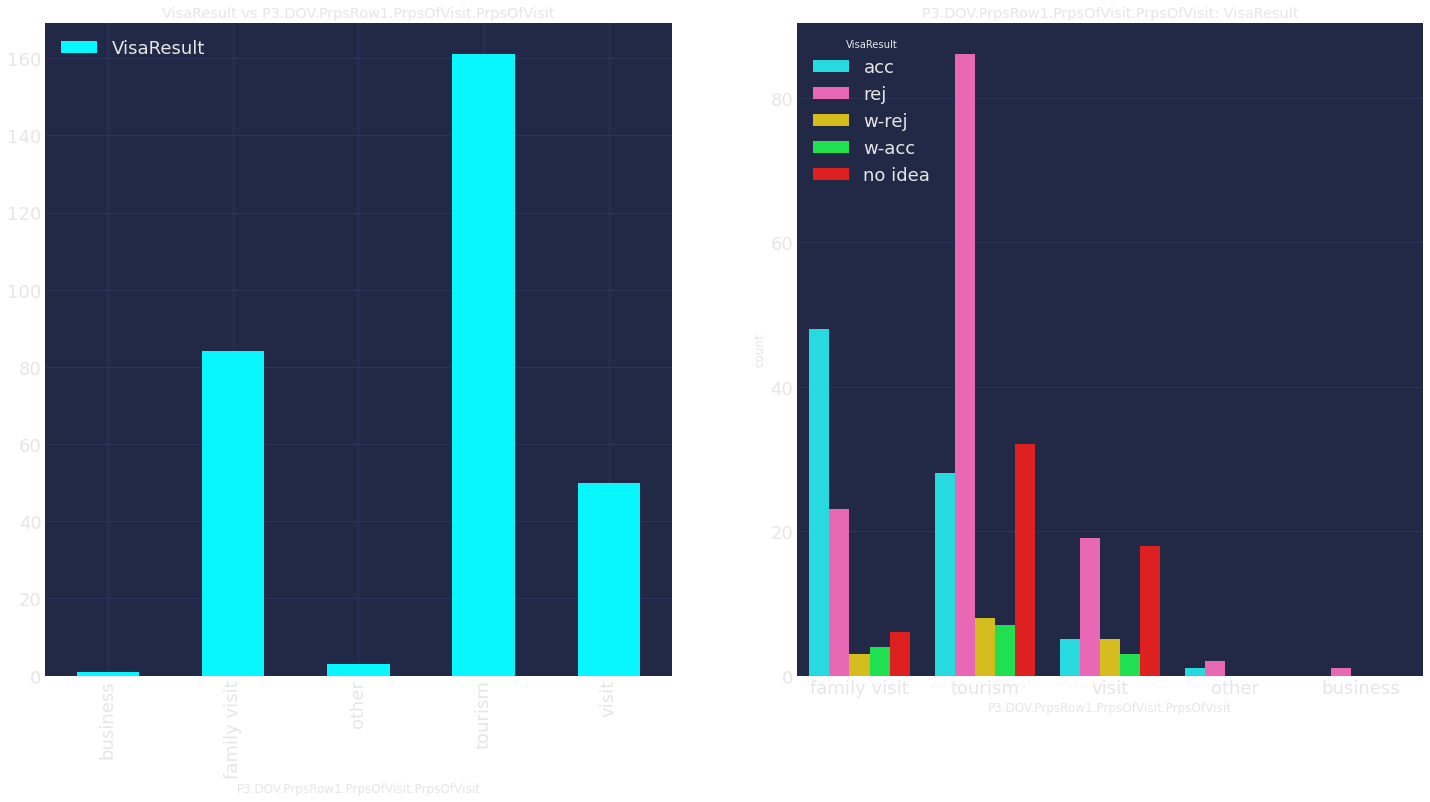

In [111]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


Clearly, a candidate visiting his family (hence having invitation letter too) has a stronger application than just tourism which is open to all. Also, just `'visit'` is not good enough even though it's not `'tourism'`.

In [112]:
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe'

z = data[data[feature_name[0]] == 'visit']

pd.crosstab([z[feature_name[0]], z[(z[output_name] == 'acc') | (z[output_name] == 'rej')][output_name]], z[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')


Well, yes, of course you get rejected if you are going to spend 10K CAD to see your wife's first cousin. OMEGALUL.

### P3.DOV.PrpsRow1.Other.Other -> categorical

In [113]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.Other.Other'
data.groupby([feature_name, output_name])[output_name].count()

P3.DOV.PrpsRow1.Other.Other  VisaResult
False                        acc            81
                             no idea        56
                             rej           129
                             w-acc          14
                             w-rej          16
True                         acc             1
                             rej             2
Name: VisaResult, dtype: int64

In [114]:
data[data[feature_name] == True].groupby(
    ['P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', feature_name])[feature_name].count()


P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  P3.DOV.PrpsRow1.Other.Other
other                                    True                           3
Name: P3.DOV.PrpsRow1.Other.Other, dtype: int64

In [115]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)


### P3.DOV.PrpsRow1.Funds.Funds -> Continuous

count      299.000000
mean      9051.839465
std       2050.083063
min       1000.000000
25%       8000.000000
50%      10000.000000
75%      10000.000000
max      30000.000000
Name: P3.DOV.PrpsRow1.Funds.Funds, dtype: float64


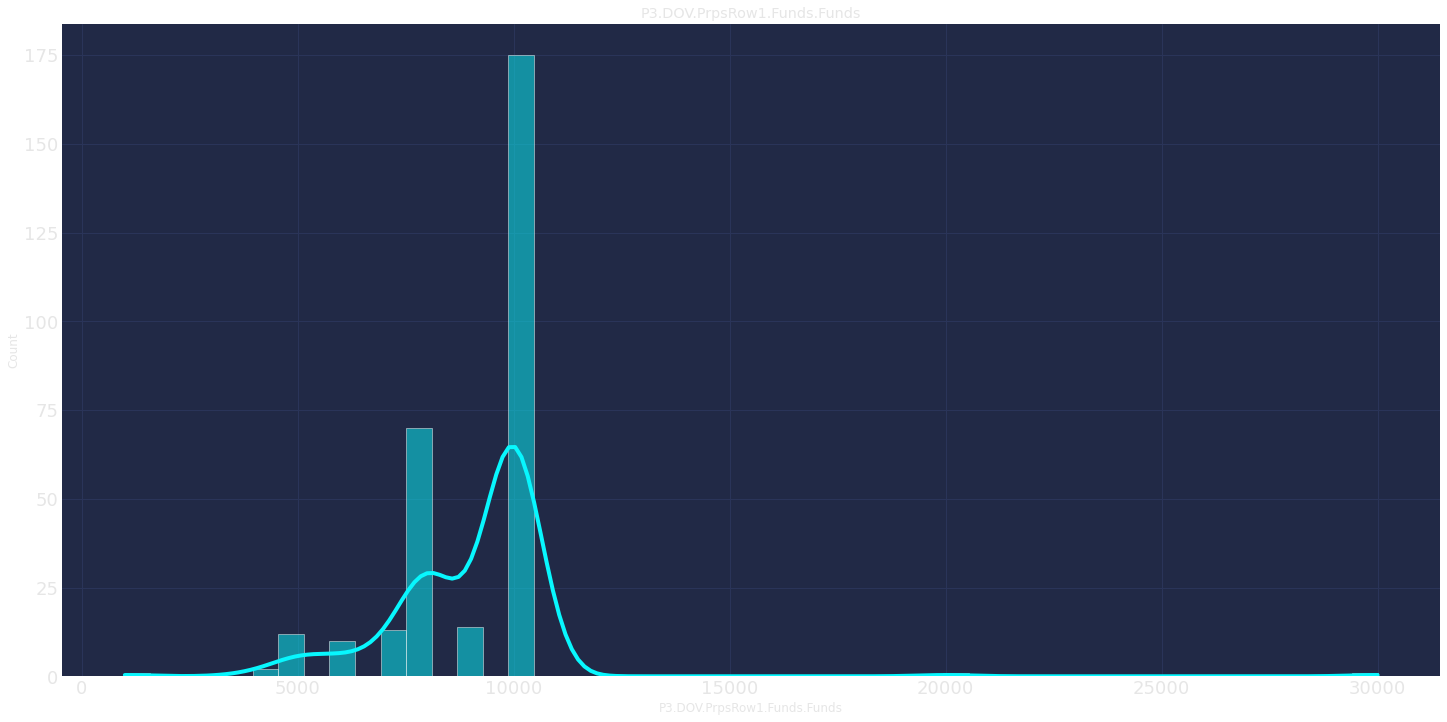

In [116]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.Funds.Funds'

print(data[feature_name].describe())

f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.histplot(data[feature_name], ax=ax, kde=True)
ax.set_title('{}'.format(feature_name))
plt.show()


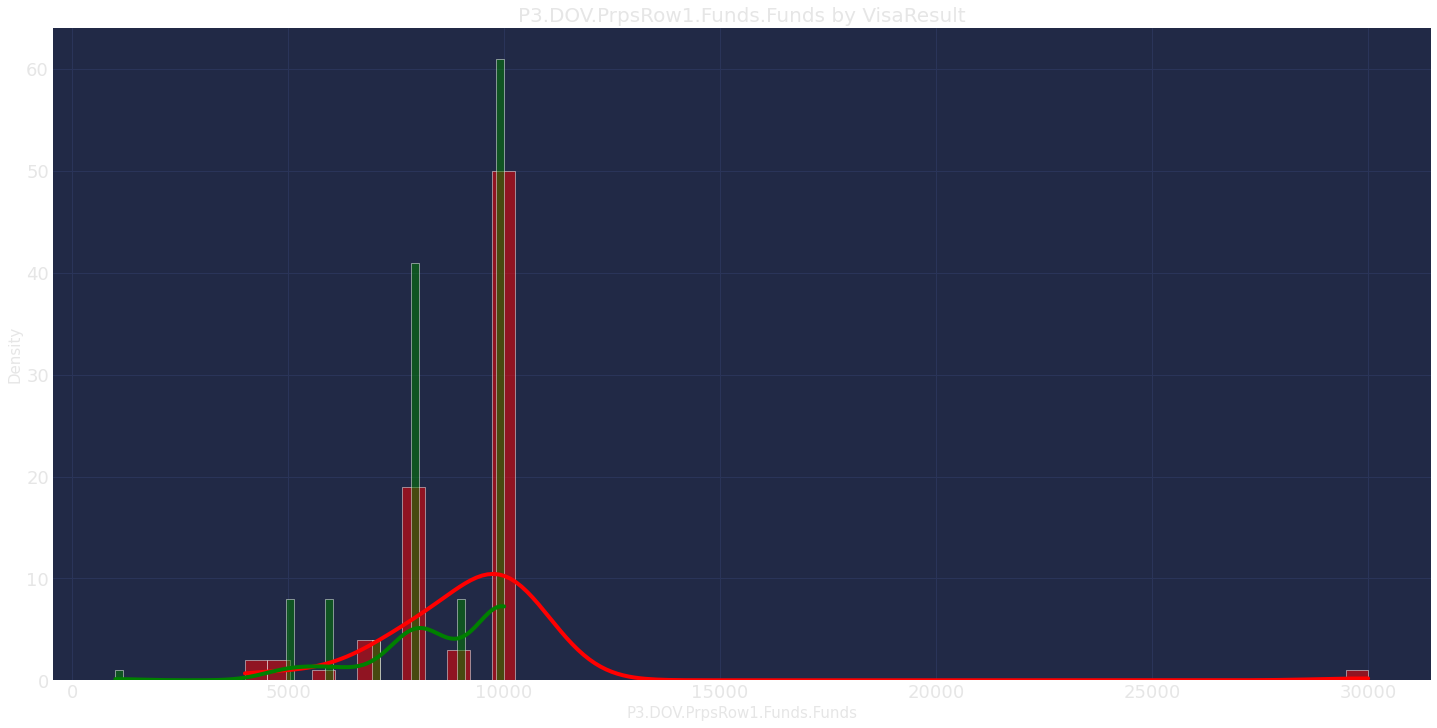

In [117]:
plt.figure(figsize=(22, 12))

sns.histplot(data[data[output_name] == 'acc'][feature_name],
             bins=50, color='r', kde=True)
sns.histplot(data[data[output_name] == 'rej'][feature_name],
             bins=50, color='g', kde=True)
plt.title('{} by {}'.format(feature_name, output_name), fontsize=20)
plt.xlabel(feature_name, fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()


### P3.DOV.cntcts_Row[i].RelationshipToMe.RelationshipToMe -> categorical

In [118]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe', 'P3.cntcts_Row2.Relationship.RelationshipToMe'

print(data[feature_name[0]].unique())
print(data[feature_name[1]].unique())

['SON' 'OTHER' 'HOTEL' 'DAUGHTER' 'RELATIVE-FREIND' 'AUNT' 'BROTHER'
 'COUSIN' 'HOTE' 'sister' 'Hotel' 'SISTER'
 'CEO TOTAL ARM WRESTLING LEAGUE' 'sister in law' 'Aunt'
 'SON-DAUGHTER IN LAW' 'My First Cousin' 'PARENT AND SISTER'
 'BROTHER IN LAW' '1)SON-IN-LAW' 'FRIEND' 'CHILD' 'GRANDCHILD' 'MOTHER'
 'hotel' 'DAUGHTER-SON IN LAW' 'BROTHER-IN-LAW'
 'SISTER IN LAW-MY WIFE SISTER' 'Close Friend' 'STEP SON' 'WIFE\\\\S AUNT'
 'IFBB PRO LEAGUE' 'SISTER IN LAW' 'UNCLE' 'Wife\\\\s Aunt'
 'MY WIFE\\\\S COUSIN' 'CLOSE FRIEND' 'My Wife\\\\s first cousin' 'NIECE'
 'STEP BROHER' 'WIFE\\\\S SISTER'
 'INTERNATIONAL SYMPOSIUM OF SCULPTURE- HOTEL' 'TWIN BROTHER' 'NEPHEW']
['OTHER' 'HOTEL' 'COUSIN,S HUSBAND' 'Hotel' 'cousin'
 'My First Cousin\\\\s Husband/hotel' '2)DAUGHTER' 'BROTHER-IN-LAW'
 'FRIEND' 'hotel' 'SON IN LAW' 'SPOUSE\\\\S SISTER\\\\S HUSBAND'
 'Close Friend' 'DAUGHTER IN LAW' 'COUSIN' '2)HOTEL 3)CLOSE FRIEND'
 'SON IN LOW' 'WIFE\\\\S COUSIN' 'SISTER IN LAW' 'SISTER'
 'The Husband of My Wif

We need to categorize these into simpler and representative categories:
1. `['brother', 'sister', 'step*', ...]: 'f1'` 
2. `['*in law*', 'nephew']: 'f2'`
3.  `'*friend*': 'friend'`


Issues:
1. Should we put `'hotel'` first or `'cousin'` in `'The Husband of My Wife\\\\s first cousin/hotel'`?  TODO: ask agents which one has higher priority

In [119]:
rel_cat = {  # order matters, put weaker on top, i.e. put 'law' above 'brother', so 'brother in law' get handled by 'law' rule than 'bother' rule
    'law': 'f2',
    'nephew': 'f2',
    'niece': 'f2',
    'aunt': 'f2',
    'uncle': 'f2',
    'cousin': 'f2',
    'relative': 'f2',
    'grand': 'f2',
    'parent': 'f1',
    'mother': 'f1',
    'father': 'f1',
    'child': 'f1',
    'daughter': 'f1',
    'brother': 'f1',
    'sister': 'f1',
    'wife': 'f1',
    'husband': 'f1',
    'step': 'f1',
    'son': 'f1',
    'partner': 'f1',
    'fiance': 'f1',
    'fiancee': 'f1',
    'other': 'ukn',
    'friend': 'friend',
    'league': 'work',
    'symposium': 'work',
    'hote': 'hotel',
    'hotel': 'hotel',
}


def fix_rel(string: str, dic: dict):
    string = string.lower()
    for k, v in dic.items():
        if k in string:
            string = string.replace(string, v)
            return string
    return 'ukn'


data[feature_name[0]] = data[feature_name[0]].apply(fix_rel, args=(rel_cat, ))
data[feature_name[1]] = data[feature_name[1]].apply(fix_rel, args=(rel_cat, ))


In [120]:
print(data[feature_name[0]].unique())
print(data[feature_name[1]].unique())


['f1' 'ukn' 'hotel' 'f2' 'work' 'friend']
['ukn' 'hotel' 'f2' 'f1' 'friend']


/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


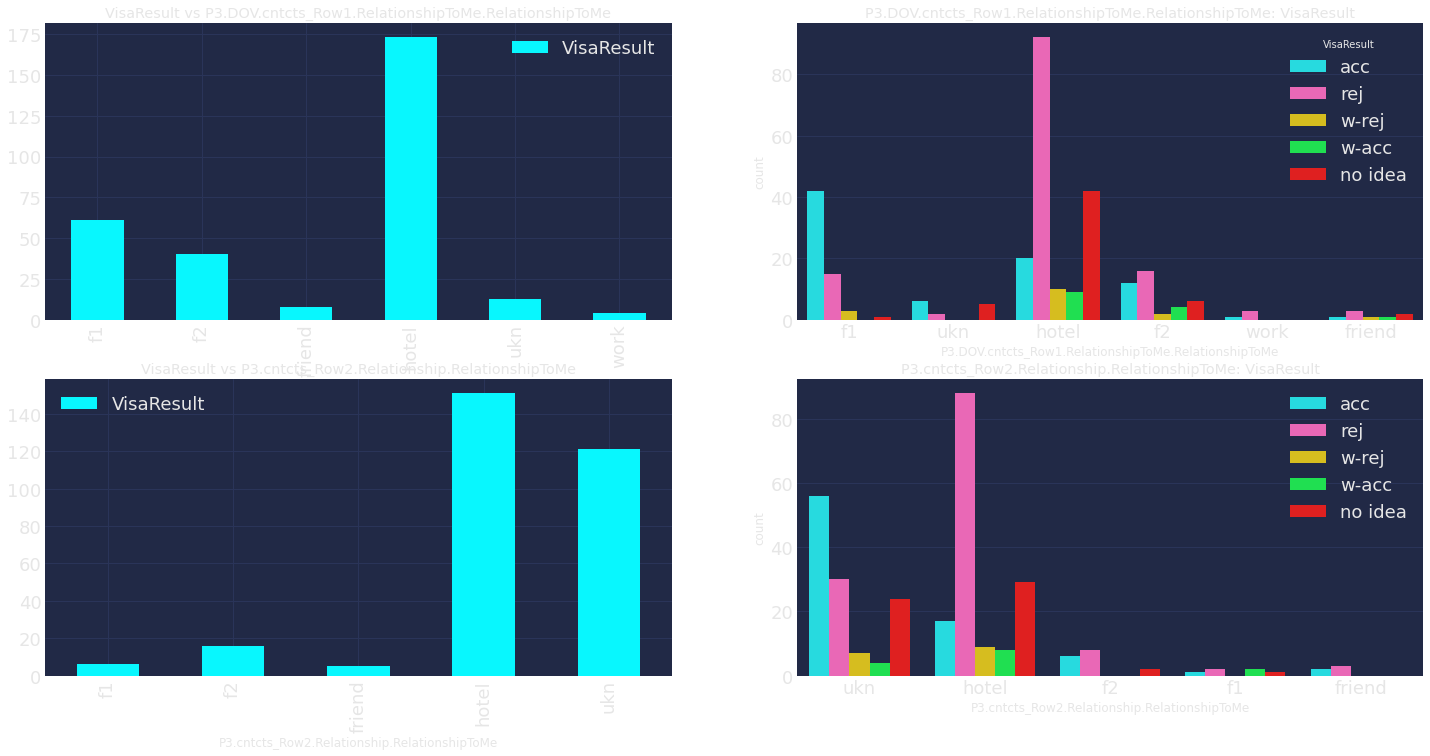

In [121]:
f, ax = plt.subplots(2, 2, figsize=(22, 12))
data[[feature_name[0], output_name]].groupby(
    [feature_name[0]]).count().plot.bar(ax=ax[0, 0], sort_columns=True)
ax[0, 0].set_title('{} vs {}'.format(output_name, feature_name[0]))
sns.countplot(feature_name[0], hue=output_name, data=data,
              ax=ax[0, 1], hue_order=output_hue_order)
ax[0, 1].set_title('{}: {}'.format(feature_name[0], output_name))

data[[feature_name[1], output_name]].groupby(
    [feature_name[1]]).count().plot.bar(ax=ax[1, 0], sort_columns=True)
ax[1, 0].set_title('{} vs {}'.format(output_name, feature_name[1]))
sns.countplot(feature_name[1], hue=output_name, data=data,
              ax=ax[1, 1], hue_order=output_hue_order)
ax[1, 1].set_title('{}: {}'.format(feature_name[1], output_name))
ax[1, 1].legend(loc='upper right')
plt.show()


### P3.Edu.EduIndicator -> categorical

In [122]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.EduIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P3.Edu.EduIndicator  VisaResult
False                acc           29
                     no idea       14
                     rej           42
                     w-acc          7
                     w-rej          5
True                 acc           53
                     no idea       42
                     rej           89
                     w-acc          7
                     w-rej         11
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


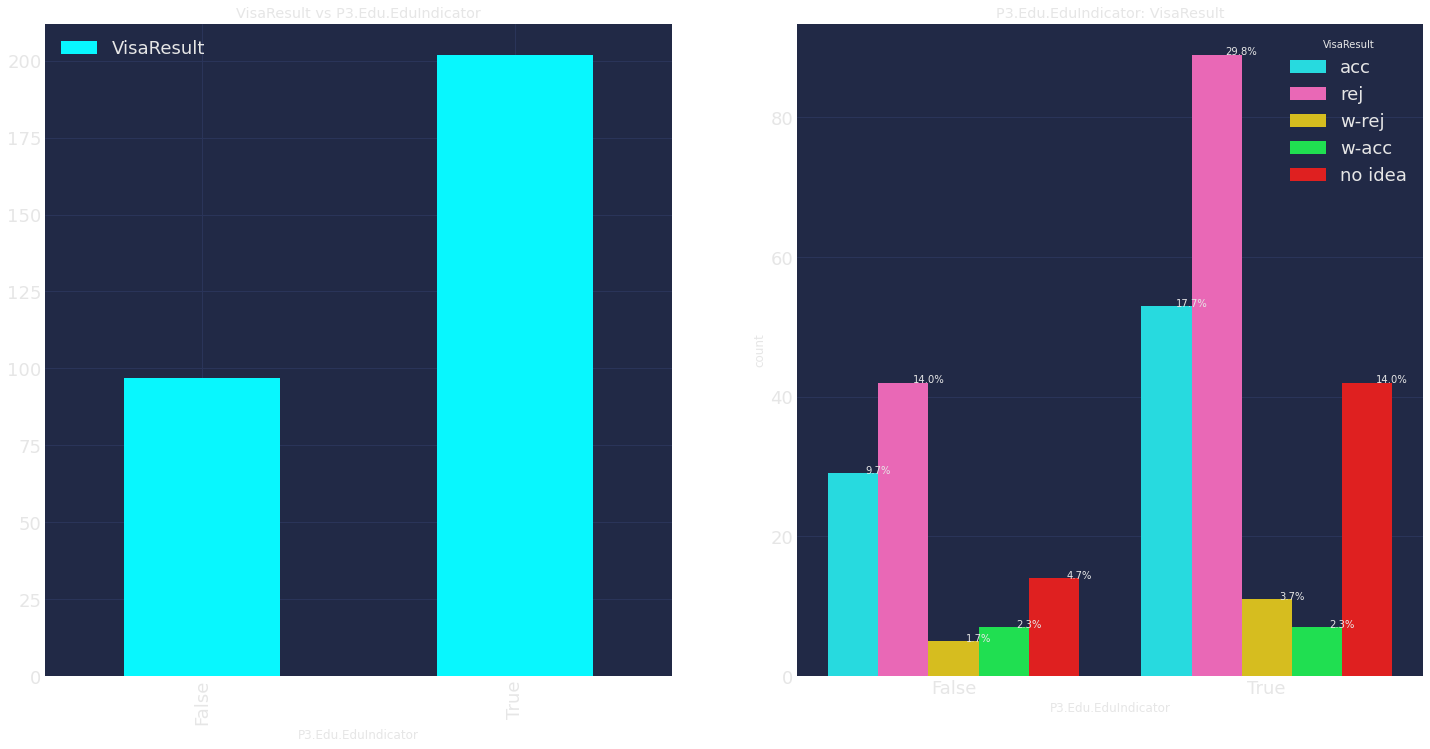

In [123]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


It seems that around %40 of people without education got accepted but %37.5 of people with education got accepted. These percentages are close and other factors such as age might have greater effect.

Also, I think the education field has way more effect than just having higher education. Of course we prefer a engineer/medic refugee than some pleb that going to consume more than provide.

TODO: somehow categorize education level/field into an ordered list, then show the acceptance rate given the education level/field.

### P3.Edu.Edu_Row1.Country.Country -> categorical -> continuous

In [124]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.Edu_Row1.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Edu.Edu_Row1.Country.Country  VisaResult
028                              acc             2
                                 rej             1
059                              rej             1
242                              acc             1
280                              acc             1
IRAN                             acc            78
                                 no idea        56
                                 rej           129
                                 w-acc          14
                                 w-rej          16
Name: VisaResult, dtype: int64

Dealing with countries in categorical form is not logical. We would like to rank them or in an easier way, have a continuous score for each country. This way, we can convert a possibly large categorical feature into continuous field.

To do so, approach discussed in issue #10 (PR #11) has been taken, which in summary, takes WorldBank data, looks for education fields, and take average of countries score over past years. Here, we utilize those methods.

In [125]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


For some reason, I filled all `None`'s with `'IRAN'` which is a wrong action. For now, I fix it by setting it to `None` by overlapping `'P3.Edu.Edu_Row1.Country.Country' ` and `'P3.Edu.EduIndicator'`

In [126]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.Edu_Row1.Country.Country' 

print(data[data['P3.Edu.EduIndicator'] == False].__len__() -
      data[data[feature_name].isna()].__len__())  # must be = 0

data.loc[data['P3.Edu.EduIndicator'] == False, feature_name] = None

print(data[data['P3.Edu.EduIndicator'] == False].__len__() -
      data[data[feature_name].isna()].__len__())  # must be = 0


97
0


Time to convert country names to continuous values of scores of them.

In [127]:
tmp_df = pd.read_pickle('../raw-dataset/databank-2015-2019.pkl')
edu_country_score_preprocessor = preprocessor.EducationCountryScoreDataframePreprocessor(
    dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=edu_country_score_preprocessor.convert_country_name_to_numeric)


/home/nik/visaland-visa-form-utility/vizard_utils/preprocessor.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop([self.INDICATOR, self.SUBINDICATOR],
/home/nik/visaland-visa-form-utility/vizard_utils/preprocessor.py:450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[indicator_name + '_mean'] = dataframe.mean(axis=1, skipna=True,
/home/nik/visaland-visa-form-utility/vizard_utils/preprocessor.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [128]:
data[data['P3.Edu.EduIndicator'] == False][feature_name].unique()

array([1.])

In [129]:
# convert to years but continuous
feature_name = 'P3.Edu.Edu_Row1.Period'
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [130]:
data.sample()

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
145,False,Female,1.107154,1.0,1.429856,1.429856,False,TURKEY,3.0,single,False,tourism,10000.0,hotel,hotel,True,MEDICAL CHEMISTRY,3.177804,student,IRAN,OTHER,IRAN,OTHER,IRAN,False,False,False,False,False,False,False,False,False,10377.0,10377.0,0.0,0.0,30.0,0.0,0.0,0.0,1702.0,16.0,2.0,1611.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,IRAN,OTHER,False,IRAN,HOUSEWIFE,True,5.0,IRAN,RETIRED,True,5.0,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,6.0,brother,IRAN,DRESS DESIGNER,True,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHE

### P3.Edu.Edu_Row1.FieldOfStudy -> categorical/ordered/continuous

TODO: can we do continuous here?


There are different ways again to deal with this, ranking, continuous, etc.

Here are the methods:
1. **Ranking** only based on the higher education level, i.e. `[apprentices=1, worker diploma=2, bachelor=3, master=5, phd=8`]. (we entirely ignore the field actually, just level of education). ([ref](https://www.canada.ca/en/immigration-refugees-citizenship/services/application/application-forms-guides/guide-5256-applying-visitor-visa-temporary-resident-visa.html)) **<-- CURRENT IMPL.**
2. *manually* ranking field of study and multiply it by method (1); i.e. `new = result1 * result2`


***Remark: This section assumes applicants' highest post secondary education**. I.e. if you have a bachelor and masters, you have to put masters and its period which is 2 years rather than 6 years (4 years of bachelor and 2 years of masters)*

In [131]:
from enum import Enum
class field_of_study_rank(Enum):
    apprentice = 1  # 1*1 = 1
    diploma = 2  # 2*2 = 4
    bachelor = 3  # 3*4 = 12
    master = 8  # 8*2 = 16
    phd = 10  # 10*3 = 30

In [132]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.Edu_Row1.FieldOfStudy', 'P3.Edu.Edu_Row1.Period', 'P3.Occ.OccRow1.Occ.Occ'

#### `'P3.Edu.Edu_Row1.Period' > 8`

In [133]:
cond = (data[feature_name[1]] >= 8) & (data[feature_name[1]] <= 99)
print(data.loc[cond, feature_name[0]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'phd')
print(data.loc[cond, feature_name[0]])

4           GENERAL PRACTITIONER
21            PHYSICAL EDUCATION
49              GENERAL MEDICINE
76                     PATHOLOGY
85     PETROCHEMICAL ENGINEERING
93                     DENTISTRY
126                 ARCHITECTURE
274                     MEDICINE
289             GENERAL MEDICINE
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string
4      phd
21     phd
49     phd
76     phd
85     phd
93     phd
126    phd
274    phd
289    phd
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string


#### `7 <= 'P3.Edu.Edu_Row1.Period' < 8`

In [134]:
cond = (data[feature_name[1]] >= 7) & (data[feature_name[1]] < 8)
print(data.loc[cond, feature_name[0]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'phd' if 'med' in x.lower() else 'master')
print(data.loc[cond, feature_name[0]])

72                          SEAFARING
83                           MEDICINE
172    MEDICAL LABORATORY TECHNOLOGIS
231                          MEDICINE
239                       ELECTRONICS
290                        ACCOUNTING
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string
72     master
83        phd
172       phd
231       phd
239    master
290    master
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string


#### `6 <= 'P3.Edu.Edu_Row1.Period' < 7`

In [135]:
cond = (data[feature_name[1]] >= 6) & (data[feature_name[1]] < 7)
print(data.loc[cond, feature_name[0:2]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'master')
print(data.loc[cond, feature_name[0]])

      P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
26           ELECTONIC ENGINEERING                6.005479
48                        PHARMACY                6.002740
100            ENGLISH TRANSLATION                6.005479
109       AGRICULTURAL ENGINEERING                6.005479
114                       MECHANIC                6.005479
130                       COMPUTER                6.002740
150                       COMPUTER                6.002740
154                        BIOLOGY                6.005479
168       AGRICULTURAL ENGINEERING                6.002740
184            TEXTILE ENGINEERING                6.005479
194                       MEDICINE                6.410959
210                     ACCOUNTING                6.005479
216             MINING ENGINEERING                6.002740
236  Master Degree in Mechatronics                6.005479
240              CIVIL ENGINEERING                6.002740
26     master
48     master
100    master
109    master


#### `3.5 <= 'P3.Edu.Edu_Row1.Period' < 6`

In [136]:
cond = (data[feature_name[1]] >= 3.5) & (data[feature_name[1]] < 6)
print(data.loc[cond, feature_name[0:2]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'bachelor')
print(data.loc[cond, feature_name[0]])

    P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
3                     Accounting                 5.00274
12                      ECONMICS                 4.00274
31                       WELDING                 5.00274
32               SOCIAL SCIENCES                 4.00274
34                    ACCOUNTING                 4.00274
..                           ...                     ...
288            HANDICRAFTS FIELD                 4.00274
291     ARCHITECTURE ENGINEERING                 5.00274
295       MECHANICAL ENGINEERING                 5.00274
297                    DENTISTRY                 5.00274
303            CIVIL ENGINEERING                 4.00274

[80 rows x 2 columns]
3      bachelor
12     bachelor
31     bachelor
32     bachelor
34     bachelor
         ...   
288    bachelor
291    bachelor
295    bachelor
297    bachelor
303    bachelor
Name: P3.Edu.Edu_Row1.FieldOfStudy, Length: 80, dtype: string


#### `3 <= 'P3.Edu.Edu_Row1.Period' < 3.5`

In [137]:
cond = (data[feature_name[1]] >= 3) & (data[feature_name[1]] < 3.5)
print(data.loc[cond, feature_name[0:2]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'master')
print(data.loc[cond, feature_name[0]])

       P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
1                       TV PRODUCER                 3.00274
7                 CHEMICAL ENGINEER                 3.00274
8                          MECHANIC                 3.00000
9                 BUISINESS MANAGER                 3.00274
22               Traffic Management                 3.00274
25                CIVIL ENGINEERING                 3.00274
28                     MICROBIOLOGY                 3.00274
45     ARCHITECTURE TECHNOLOGY ENG.                 3.00000
52                         GRAPHICS                 3.00274
58                COMPUTER-SOFTWARE                 3.00000
63                     ARCHITECTURE                 3.00274
64                        MIDWIFERY                 3.00274
68                        NUTRITION                 3.00274
74             Computer Engineering                 3.00000
107       Safety and Inspection eng                 3.00274
113  ITC-INFORMATION AND COMMUNICAT     

#### `2 <= 'P3.Edu.Edu_Row1.Period' < 3`

In [138]:
cond = (data[feature_name[1]] >= 2) & (data[feature_name[1]] < 3)
print(data.loc[cond, feature_name[0:2]])

def field_of_study_converter(x: str) -> str:
    _keys = ['logy', 'eng', 'manag', 'mb', 'med', 'sci', 'adm', 'law', 'physic', ]
    val = 'diploma'
    for k in _keys:
        if k in x.lower():
            val = 'master'
    return val

data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(field_of_study_converter)
print(data.loc[cond, feature_name[0]])

       P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
13                PRIMARY EDUCATION                2.000000
16             FINANCIAL MANAGEMENT                2.002740
20                       ACCOUNTING                2.002740
24    Supplementary topics of civil                2.002740
33                        ELECTONIC                2.002740
35                    MECHANICA ENG                2.000000
41                             EMBA                2.986301
42                     Horticulture                2.002740
61              TEXTILE ENGINEERING                2.002740
62                          STUDENT                2.030137
69             CONTINUING EDUCATION                2.002740
86              ASSOCIAE ANESTHESIA                2.002740
108                    Horticulture                2.002740
112                         PHYSICS                2.002740
132          ELECTRONIC ENGINEERING                2.000000
135                    IT MANAGMENT     

#### `0 < 'P3.Edu.Edu_Row1.Period' < 2`

In [139]:
cond = (data[feature_name[1]] > 0) & (data[feature_name[1]] < 2)
print(data.loc[cond, feature_name[0:2]])
def field_of_study_converter(x: str) -> str:
    _keys = ['mba', 'admin', 'med', 'scien']
    val = 'apprentice'
    for k in _keys:
        if k in x.lower():
            val = 'master'
    return val

data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(field_of_study_converter)
print(data.loc[cond, feature_name[0]])

       P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
5                           HISTORY                1.002740
19   DOCTORATE OF BUSINESS ADMINIST                1.000000
70              BUSINESS MANAGEMENT                1.868493
81                 HOTEL MANAGEMENT                0.252055
99                  FOOD INDUSTRIES                1.002740
103                 MEDICAL STUDENT                1.101370
153    english language translation                0.975342
160                      ELECTRONIC                1.421918
176             LABORATORY SCIENCES                1.000000
180                             MBA                1.000000
205            DENTAL BIO MATERIALS                0.567123
207          ADMINISTRATION MANAGER                1.000000
221                ENGLISH TEACHING                1.000000
223                      ACCOUNTING                1.000000
287                            DVME                0.454795
294                HOTEL MANAGEMENT     

### P3.Occ.OccRow1.Occ.Occ -> categorical -> continuous

In [140]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Occ.Occ'
data[feature_name].unique()

array(['PERSIAN/PICTURE CARPET WEAVER',
       'CHAIRMAN OF THE BOARD-ADVERTISING MANAGER-', 'MAKEUP ARTIST',
       'APPLICATION DEVELOPMENT MANAGER', 'GENERAL PRACTITIONER',
       'HOUSEWIFE', 'PETROCHEMICAL CO. ENGINEER',
       'PREPARING AND SUPERVISING FOR EXECUTING CONCRETING OPERATION',
       'SALES MANAGER', 'RETIRED', 'EMPLOYEE', 'CHILD',
       'Razi Insurance Manager- Western Province of Mazandaran',
       'UNIVERSITY PROFESSOR', 'Retired',
       'Shareholder of design and implementation ARAD TARH NOVIN company',
       'CHAIRMAN OF THE BOARD AND TECHNICAL MANAGER',
       'TECHNICAL DIRECTOR AND HSE OFICCER', 'CHAIRERSON OPF THE BOARD',
       'Haberdashery, Corrective Lenses and Sunglasses Guild Union of Shemiranat',
       'DEPUTY OF NOTARY PUBLIC', 'SALES SUPERVISOR', 'HOUSE WIFE',
       'PURCHASING MANAGER', 'IMPORT AND EXPORT',
       'BUSINESS LICENCE OWNER-SELLER OF BUILDING HYGIENE INSTRUMENTS AND RADIATORS',
       'HOLDER OF ENGINEERING EORK LICENCE',
      

TODO: fix, for now deleted

This is hard to deal with too, can we assign continuous values? can we rank and categorize into 5, 10 categories?

In [141]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

#### P3.Occ.OccRow2.Occ.Occ -> categorical -> continuous

In [142]:
# drop useless
feature_name = 'P3.Occ.OccRow2.Occ.Occ'
data.drop(feature_name, axis=1, inplace=True)

#### P3.Occ.OccRow3.Occ.Occ -> categorical -> continuous

In [143]:
# drop useless
feature_name = 'P3.Occ.OccRow3.Occ.Occ'
data.drop(feature_name, axis=1, inplace=True)

### P3.Occ.OccRow1.Country.Country -> categorical -> continuous

In [144]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Occ.OccRow1.Country.Country  VisaResult
059                             rej             1
202                             w-rej           1
224                             rej             1
280                             acc             1
IRAN                            acc            81
                                no idea        56
                                rej           129
                                w-acc          14
                                w-rej          15
Name: VisaResult, dtype: int64

Dealing with countries in categorical form is not logical. We would like to rank them or in an easier way, have a continuous score for each country. This way, we can convert a possibly large categorical feature into continuous field.

To do so, approach discussed in issue #10 (PR #11) has been taken, which in summary, takes WorldBank data, looks for economical fields (GDP), and take average of countries score over past years. Here, we utilize those methods.

In [145]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


Time to convert country names to continuous values of scores of them.

In [146]:
data[feature_name].unique()

array(['IRAN', 'China', 'United Arab Emirates', 'Ukraine', 'Iraq'],
      dtype=object)

options: 
- 'GCI 4.0: Global Competitiveness Index 4.0, Rank'
- [NEW] GDP per capita: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD 

In [147]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [148]:
data[feature_name].unique()

array([1.10715442, 1.32752412, 2.33984284, 1.10558781, 1.16178083])

#### P3.Occ.OccRow2.Country.Country -> categorical -> continuous

In [149]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow2.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Occ.OccRow2.Country.Country  VisaResult
059                             rej             1
280                             acc             1
IRAN                            acc            81
                                no idea        56
                                rej           129
                                w-acc          14
                                w-rej          16
TURKEY                          rej             1
Name: VisaResult, dtype: int64

In [150]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


In [151]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [152]:
data[feature_name].unique()

array([1.10715442, 2.33984284, 1.10558781, 1.30392442])

#### P3.Occ.OccRow3.Country.Country -> categorical -> continuous

In [153]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow3.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Occ.OccRow3.Country.Country  VisaResult
059                             rej             1
IRAN                            acc            82
                                no idea        56
                                rej           130
                                w-acc          14
                                w-rej          16
Name: VisaResult, dtype: int64

In [154]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


In [155]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [156]:
data[feature_name].unique()

array([1.10715442, 1.10558781])

#### P3.Occ.OccRowX.Period -> continuous

In [157]:
import re
r = re.compile('P3.Occ.OccRow.*.Period')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['P3.Occ.OccRow1.Period', 'P3.Occ.OccRow2.Period', 'P3.Occ.OccRow3.Period']

In [158]:
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

### P3.BGI.Details.MedicalDetails -> categorical

In [159]:
output_name = 'VisaResult'
feature_name = 'P3.BGI.Details.MedicalDetails'
data.groupby([feature_name, output_name])[output_name].count()

P3.BGI.Details.MedicalDetails  VisaResult
False                          acc            82
                               no idea        56
                               rej           131
                               w-acc          14
                               w-rej          16
Name: VisaResult, dtype: int64

In [160]:
# drop useless
feature_name = 'P3.BGI.Details.MedicalDetails'
data.drop(feature_name, axis=1, inplace=True)

### P3.BGI.otherThanMedic -> categorical

In [161]:
output_name = 'VisaResult'
feature_name = 'P3.BGI.otherThanMedic'
data.groupby([feature_name, output_name])[output_name].count()

P3.BGI.otherThanMedic  VisaResult
False                  acc            82
                       no idea        56
                       rej           131
                       w-acc          14
                       w-rej          16
Name: VisaResult, dtype: int64

In [162]:
# drop useless
feature_name = 'P3.BGI.otherThanMedic'
data.drop(feature_name, axis=1, inplace=True)

### P3.noAuthStay -> categorical

In [163]:
output_name = 'VisaResult'
feature_name = 'P3.noAuthStay'
data.groupby([feature_name, output_name])[output_name].count()

P3.noAuthStay  VisaResult
False          acc            82
               no idea        56
               rej           129
               w-acc          14
               w-rej          16
True           rej             2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


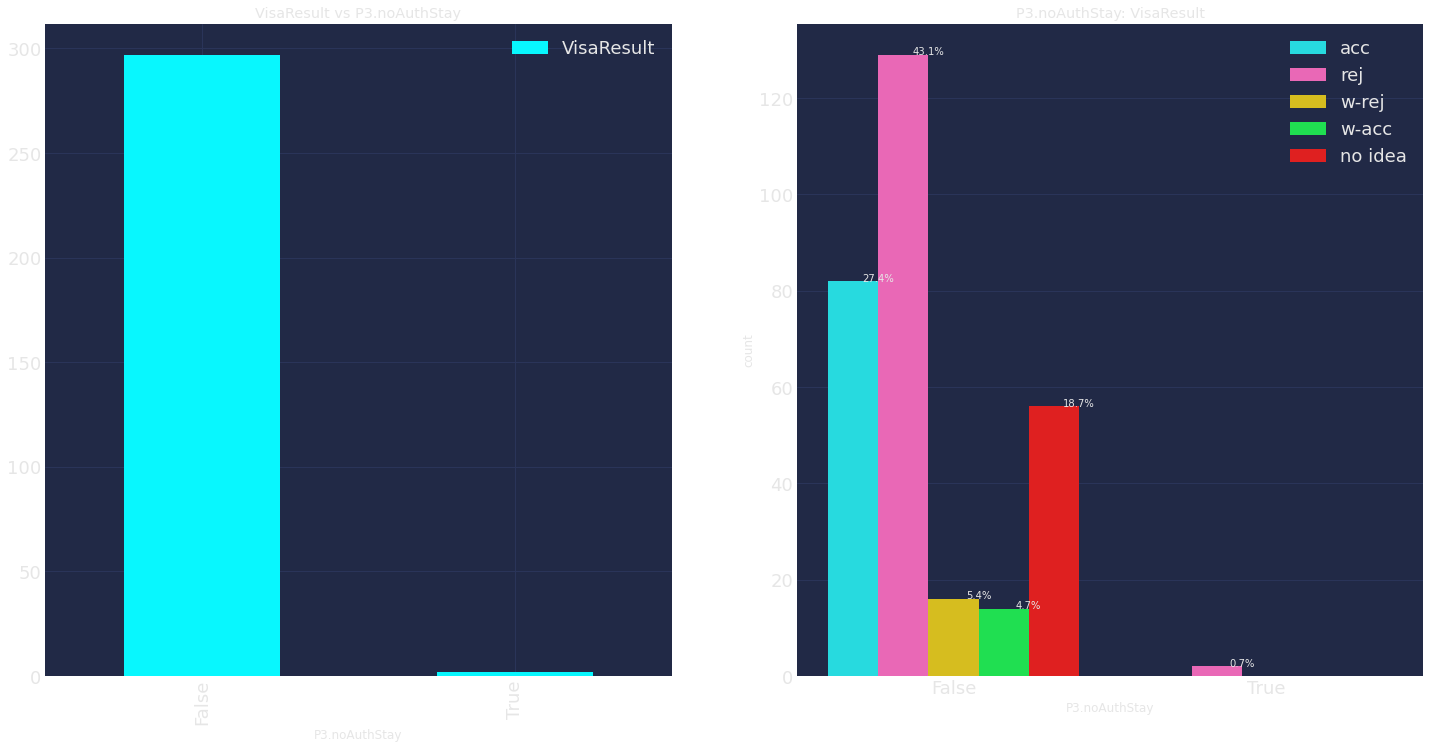

In [164]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


Obviously, staying in a country beyond authenticated duration, dominates solely and even though it sounds obvious, it shouldn't be ignored.

### P3.refuseDeport -> categorical

In [165]:
output_name = 'VisaResult'
feature_name = 'P3.refuseDeport'
data.groupby([feature_name, output_name])[output_name].count()

P3.refuseDeport  VisaResult
False            acc           68
                 no idea       41
                 rej           95
                 w-acc         12
                 w-rej         12
True             acc           14
                 no idea       15
                 rej           36
                 w-acc          2
                 w-rej          4
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


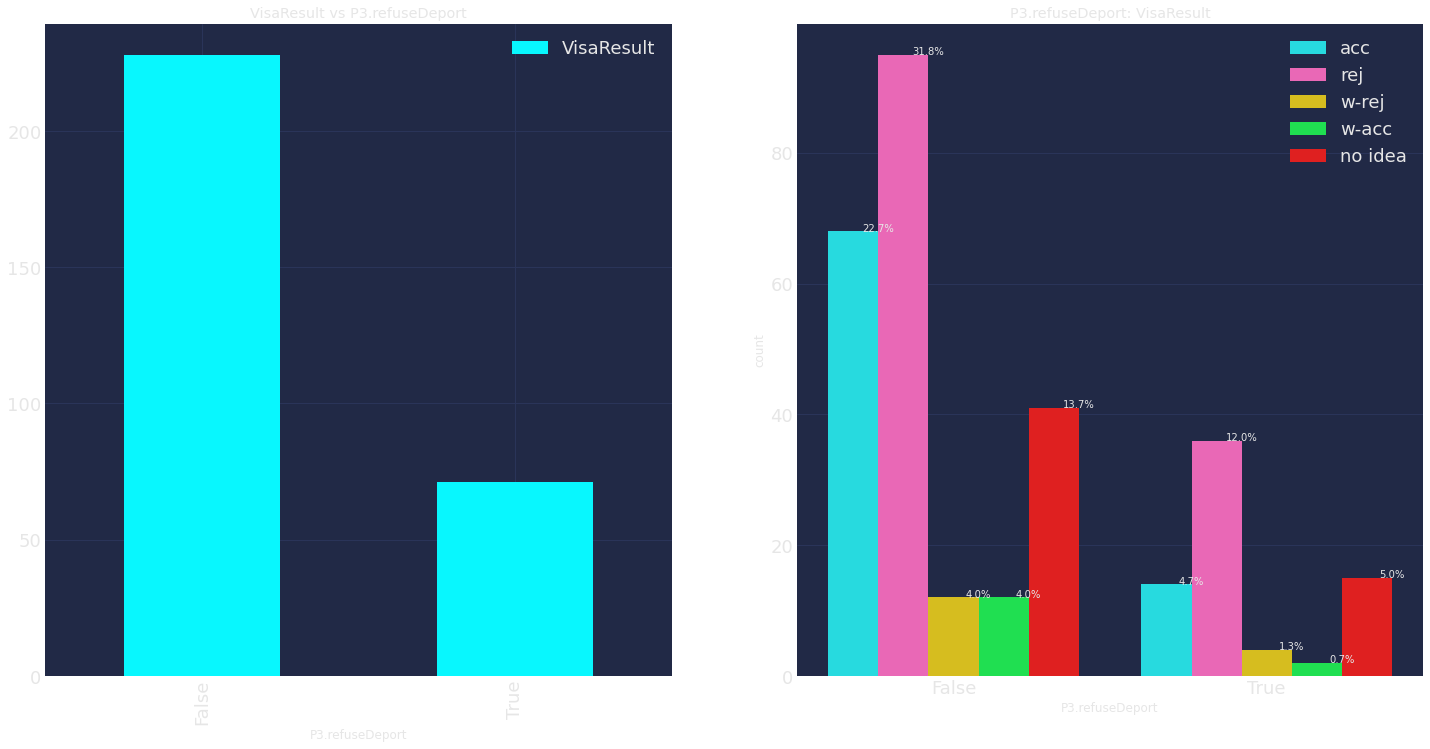

In [166]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


Of course, those who have previous rejected cases are more likely to get rejected again.

### P3.BGI2.PrevApply -> categorical

In [167]:
output_name = 'VisaResult'
feature_name = 'P3.BGI2.PrevApply'
data.groupby([feature_name, output_name])[output_name].count()

P3.BGI2.PrevApply  VisaResult
False              acc            44
                   no idea        41
                   rej           107
                   w-acc          14
                   w-rej          14
True               acc            38
                   no idea        15
                   rej            24
                   w-rej           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


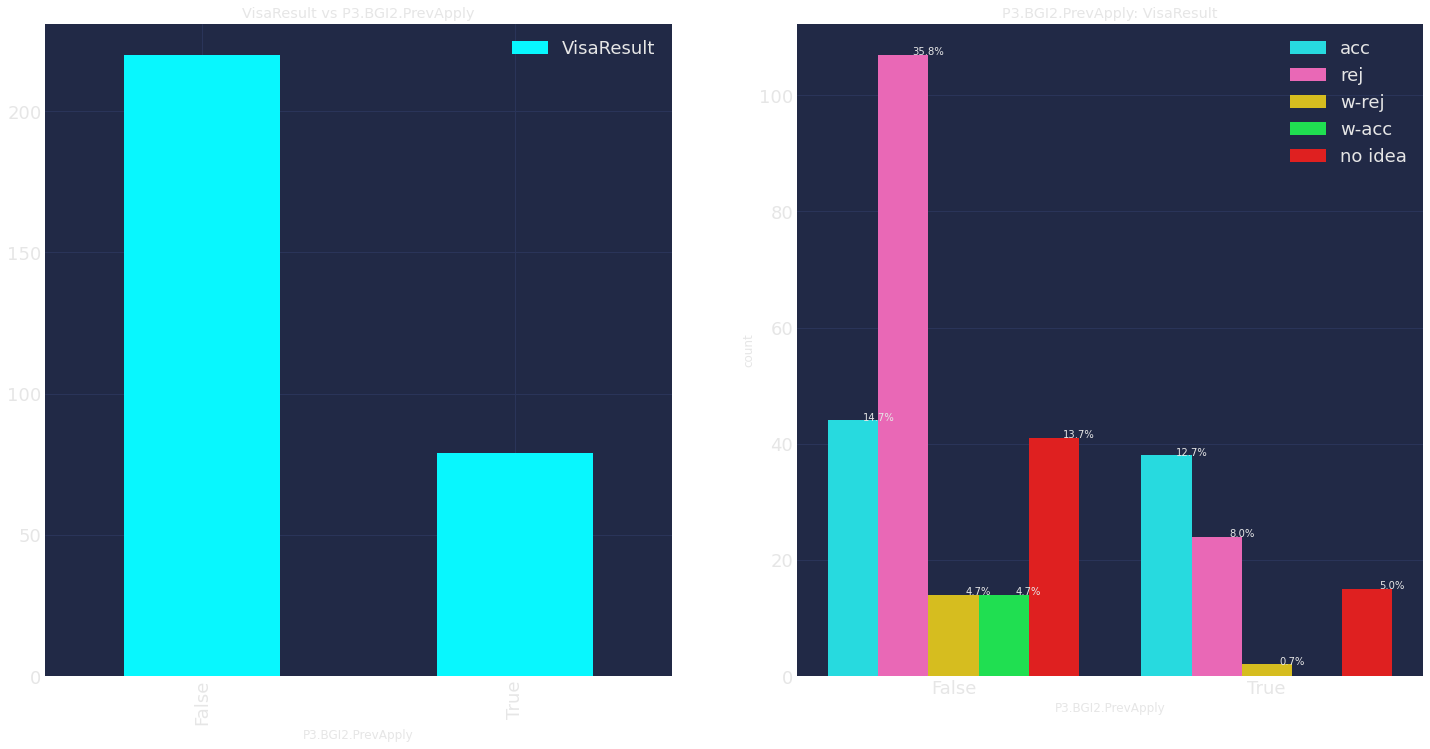

In [168]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


Well, it sounds obvious that if someone got the visa before, it is more likely to get the visa once again and vice versa. So, let's compare with `'P3.refuseDeport'` to see the relation between previous applies that succeeded or failed.

In [169]:
feature_name = 'P3.BGI2.PrevApply', 'P3.refuseDeport'

ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) *100
ct

VisaResult                               acc        rej         All
P3.BGI2.PrevApply P3.refuseDeport                                  
False             False            17.840376  42.723005   60.563380
                  True              2.816901   7.511737   10.328638
True              False            14.084507   1.877934   15.962441
                  True              3.755869   9.389671   13.145540
All                                38.497653  61.502347  100.000000

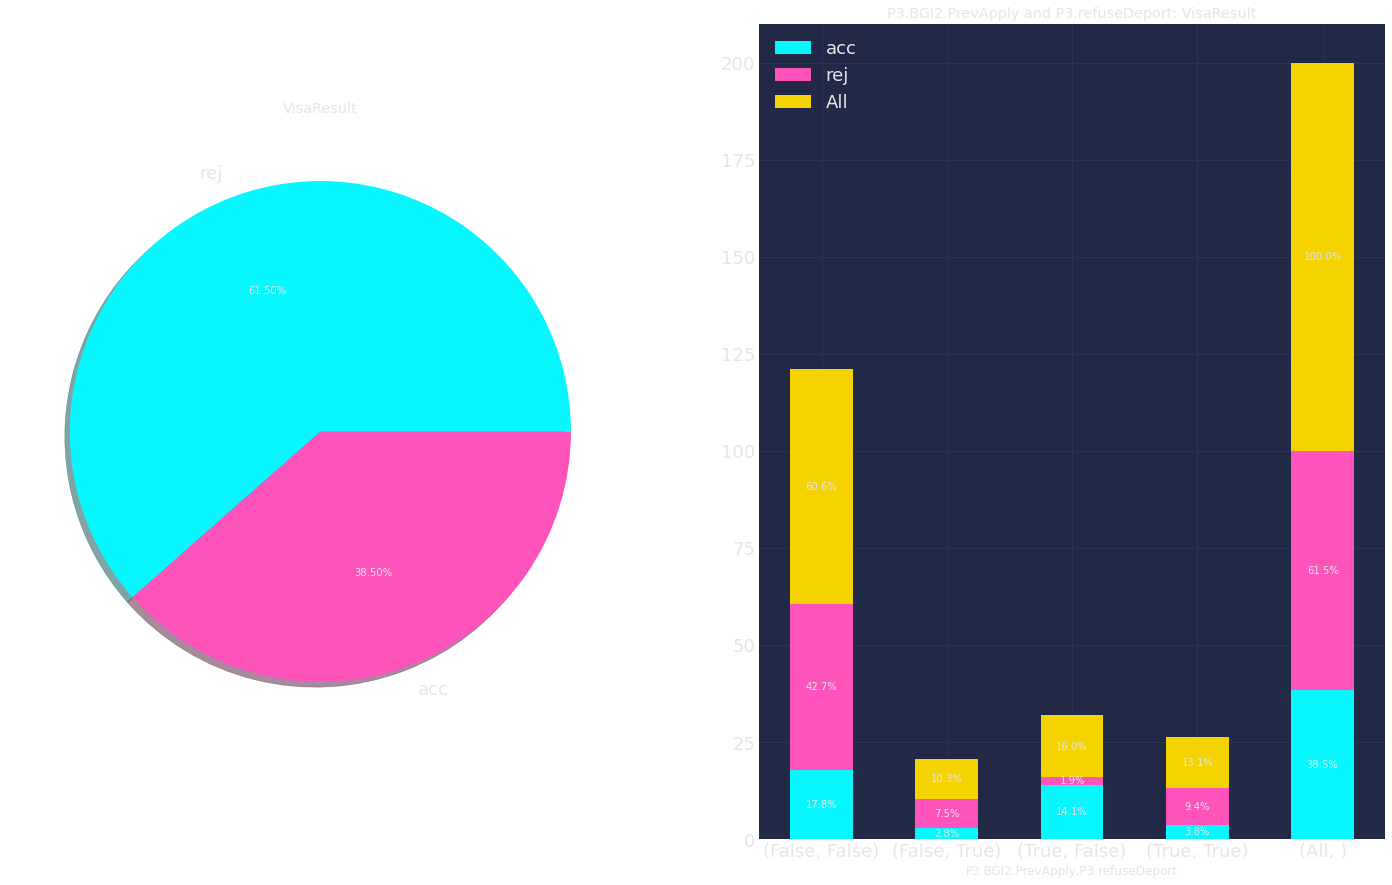

In [170]:
f, ax = plt.subplots(1, 2, figsize=(22, 15))
data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True)
ax[0].set_title('VisaResult')
ax[0].set_ylabel('')

ct.plot(kind='bar', stacked=True, rot=0, ax=ax[1])
ax[1].set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax[1].legend(loc='upper left')
for c in ax[1].containers:
    ax[1].bar_label(c, label_type='center', fmt='%1.1f%%')
plt.show()


First of all, we can see that %38.7 of applicants got visa. Now, let's see how many of them got it because of their previous apply.

Insights:
1. As we can see from the 3rd column, around %14.5 of applicant got visa because they had applied previously and got accepted. 
2. Interestingly, around %6.5(=2.8+3.7) of applicant got visa, even though they have been previously rejected.
3. Other %17.8 got visa without any prior record.
4. Having visa rejection (2nd column) reduces the chance of acceptance by at least 2 times!

### P3.PWrapper.criminalRec -> categorical

In [171]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.criminalRec'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.criminalRec  VisaResult
False                    acc            82
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

In [172]:
# drop useless
feature_name = 'P3.PWrapper.criminalRec'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.Military.Choice -> categorical

In [173]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.Military.Choice'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.Military.Choice  VisaResult
False                        acc            80
                             no idea        54
                             rej           128
                             w-acc          14
                             w-rej          16
True                         acc             2
                             no idea         2
                             rej             3
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


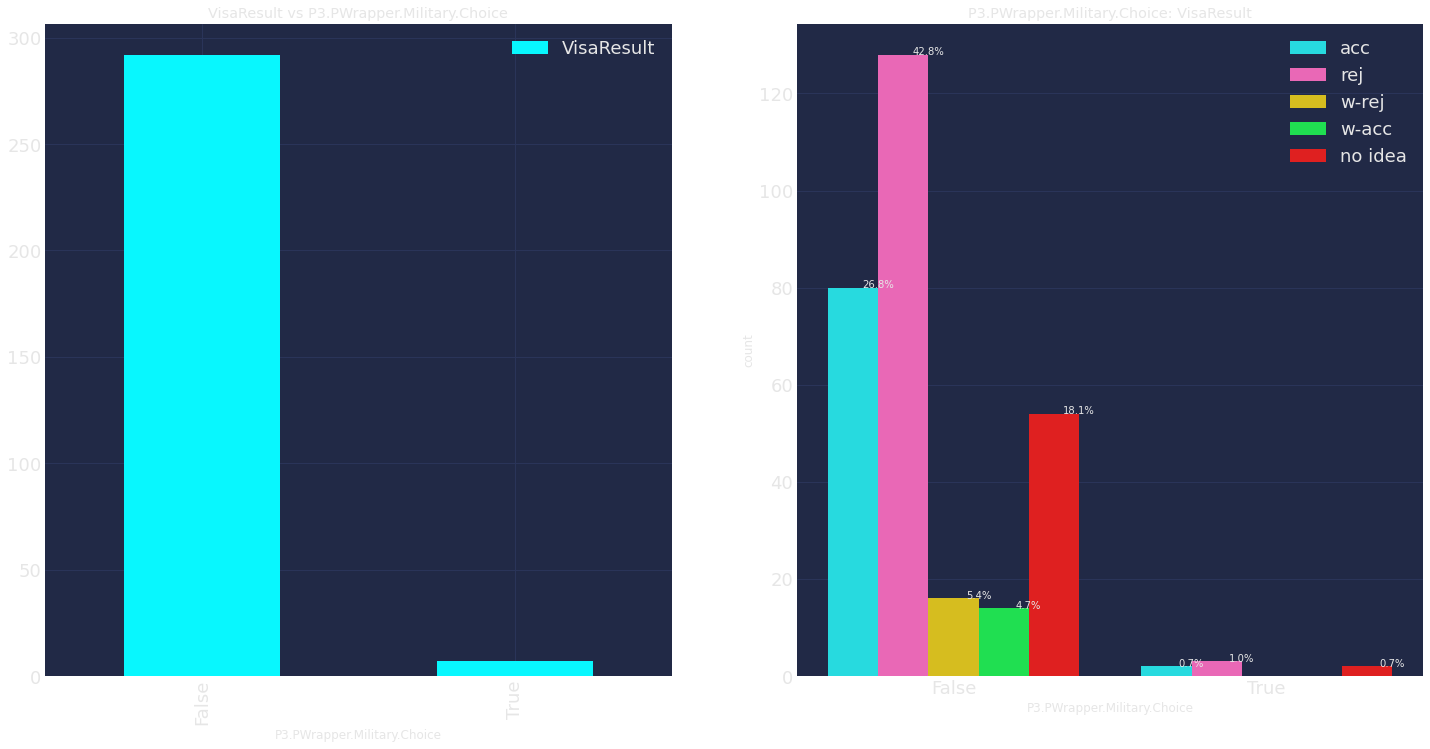

In [174]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


It's nothing to consider. If all was rejected, we could say it is a warning, but apparently has no effect. Especially, many have done compulsory service. Hence, for now we drop it.

In [175]:
# drop useless
feature_name = 'P3.PWrapper.Military.Choice'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.politicViol -> categorical

In [176]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.politicViol'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.politicViol  VisaResult
False                    acc            82
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

So ... Yea... everybody lied that they have not seen any mistreatment! KEKSociety.

In [177]:
# drop useless
feature_name = 'P3.PWrapper.politicViol'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.witnessIllTreat -> categorical

In [178]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.witnessIllTreat'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.witnessIllTreat  VisaResult
False                        acc            82
                             no idea        56
                             rej           131
                             w-acc          14
                             w-rej          16
Name: VisaResult, dtype: int64

In [179]:
# drop useless
feature_name = 'P3.PWrapper.witnessIllTreat'
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Period -> continuous

This part is a little different, since most of the people are single-national citizens (in our domain at least), then their `'CurrCOR'` and `'DOBYear.Period'` are the same value.
So we prefer to compare these to together as a joint variable. 

In [180]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Period', 'P1.PD.DOBYear.Period'

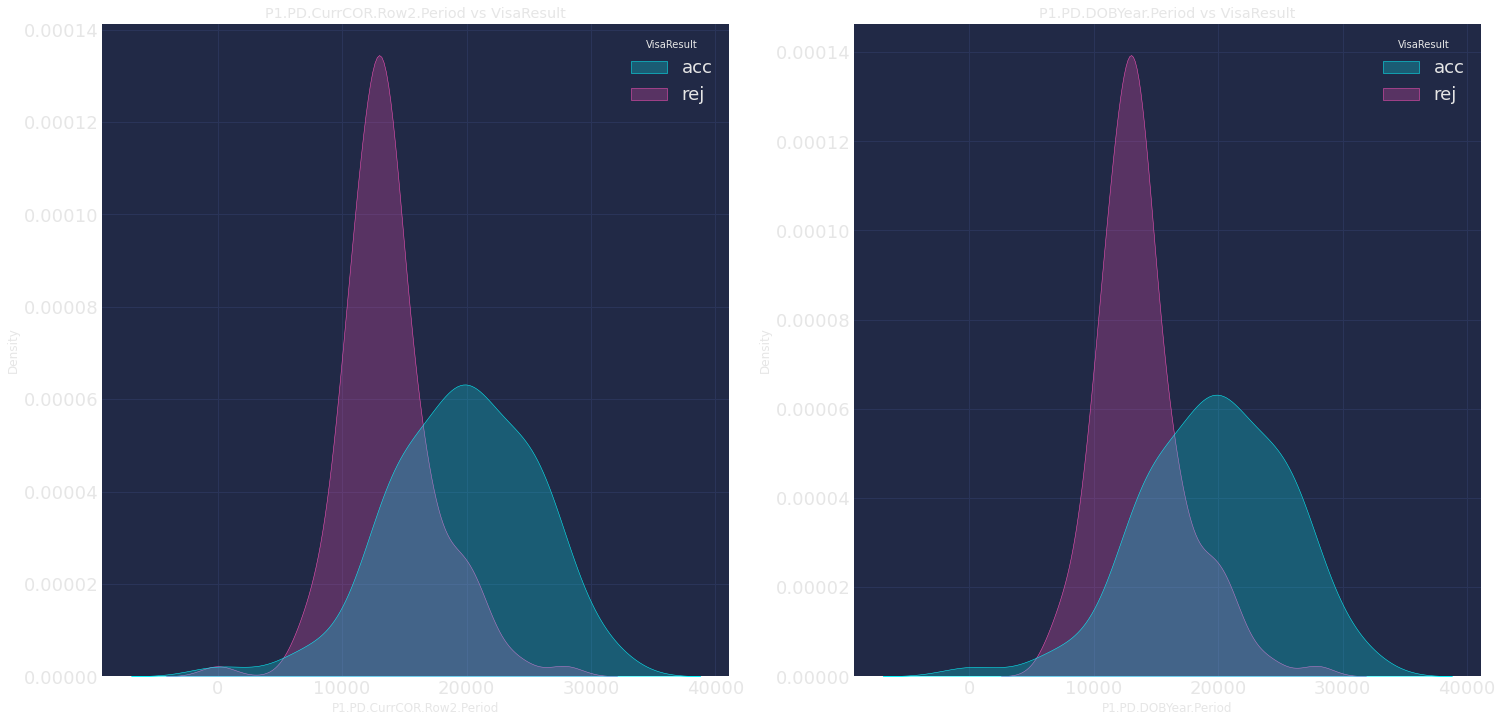

In [181]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.kdeplot(x=feature_name[0], hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[0])
ax[0].set_title('{} vs {}'.format(feature_name[0], output_name))
sns.kdeplot(x=feature_name[1], hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[1], output_name))
plt.show()

As we can see, both data has the same distribution except a small proportion (around 0) which can be considered as anomaly. Hence, I think dropping this `'CurrCOR'` is a rational choice. But to make sure, we plot these these two variables against each other.

In [182]:
# sns.displot(
#     data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name,
#     kind="kde", rug=True, height=12)
# plt.title('{} vs {}'.format(feature_name[1], output_name))
# plt.show()

In [183]:
# drop useless
feature_name = 'P1.PD.CurrCOR.Row2.Period'
data.drop(feature_name, axis=1, inplace=True)

### 'P1.PD.DOBYear.Period' -> continuous

In [184]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period'

In [185]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [186]:
data[data[feature_name]<=25].groupby([feature_name, output_name])[output_name].count()

P1.PD.DOBYear.Period  VisaResult
0.591781              acc           1
17.808219             rej           1
18.534247             acc           1
19.115068             acc           1
19.989041             rej           1
20.394521             rej           1
20.989041             rej           1
22.043836             no idea       1
22.268493             rej           1
22.446575             rej           1
23.838356             no idea       1
Name: VisaResult, dtype: int64

Let's get rid of that kid first. But I decided to keep others (e.g. 17, 18, ... years old kids) and the reason is that they have been proportionately rejected. So, if they wanted to go alone, or with family, there is something that caused them to get rejected. So, let's keep em.

In [187]:
data.drop(data[data[feature_name]<=1].index, inplace=True)
data[data[feature_name]<=1][feature_name]

Series([], Name: P1.PD.DOBYear.Period, dtype: float64)

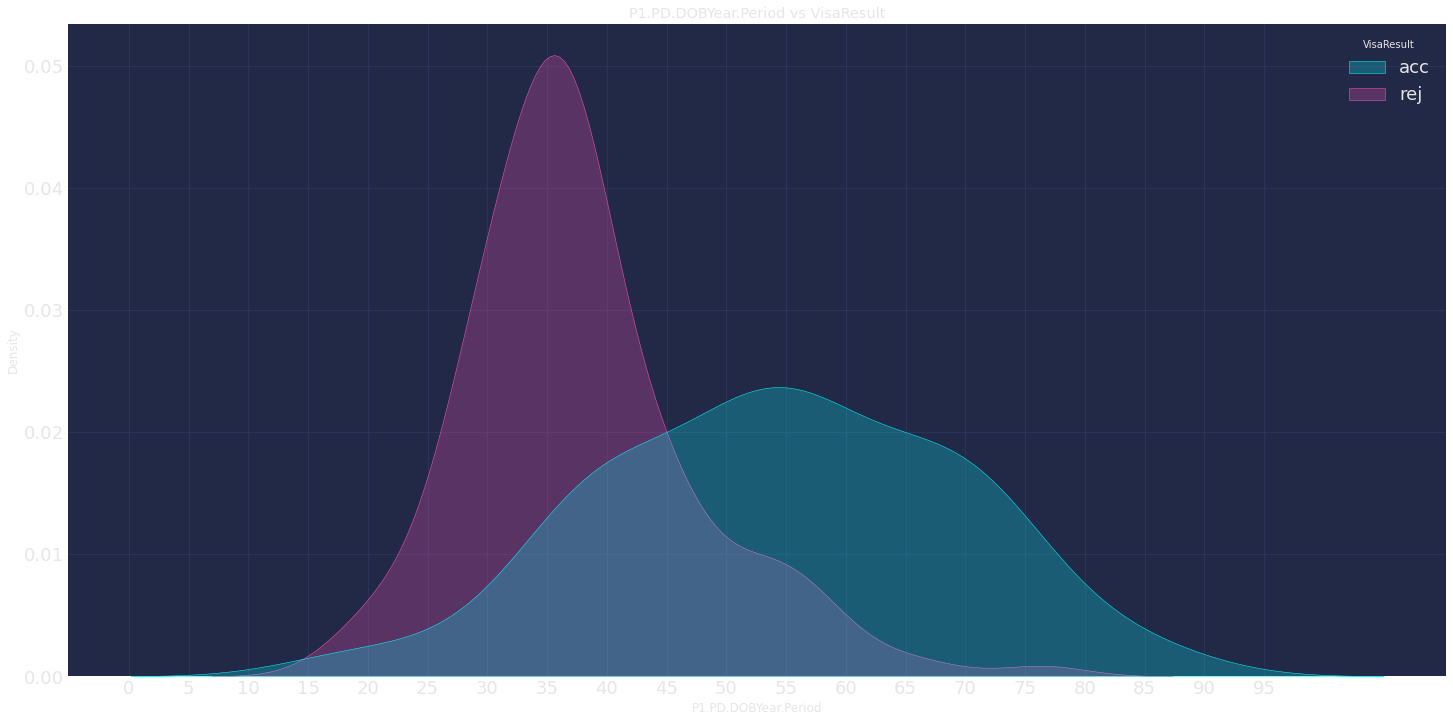

In [188]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.kdeplot(x=feature_name, hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax)
ax.set_title('{} vs {}'.format(feature_name, output_name))
ax.set_xticks(range(0, 100, 5))
plt.show()

### 'P1.PD.DOBYear.Period' and a second feature

#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [189]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P1.PD.Sex.Sex'

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


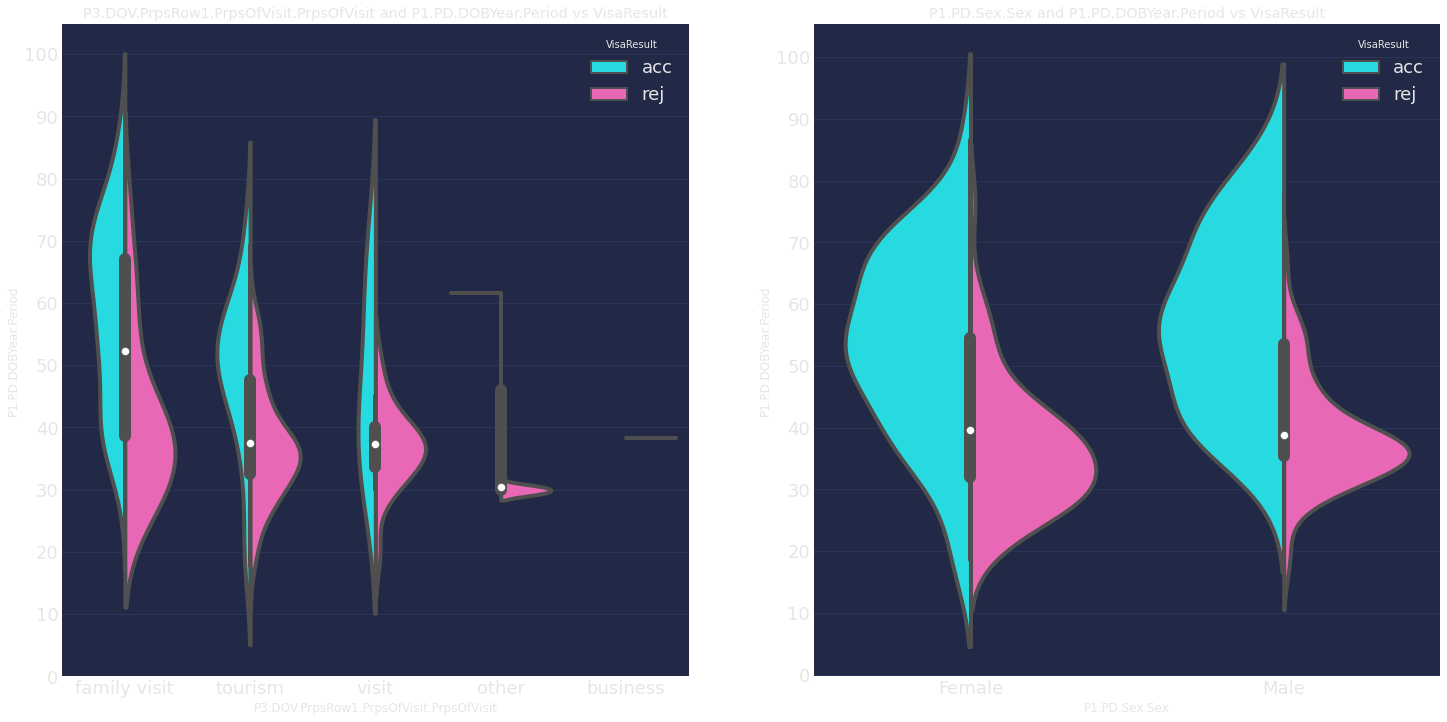

In [190]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area', 
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(feature_name[2], feature_name[0], scale='width', 
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} and {} vs {}'.format(feature_name[2], feature_name[0], output_name))
ax[1].set_yticks(range(0, 110, 10))
plt.show()


Insights:
1. The lower the age, the lower the likelihood
2. 'family visit' dominates the age and increases the likelihood considerably
3. There is not much difference in 'tourism' and 'visit' and 'age' is the the important factor again
4. The peak of rejection for 'Male' is around 40 while for 'Female' is around 30 and the reason is that usually in families, men have higher age than women.


#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.Funds.Funds' -> continuous

In [191]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P3.DOV.PrpsRow1.Funds.Funds'

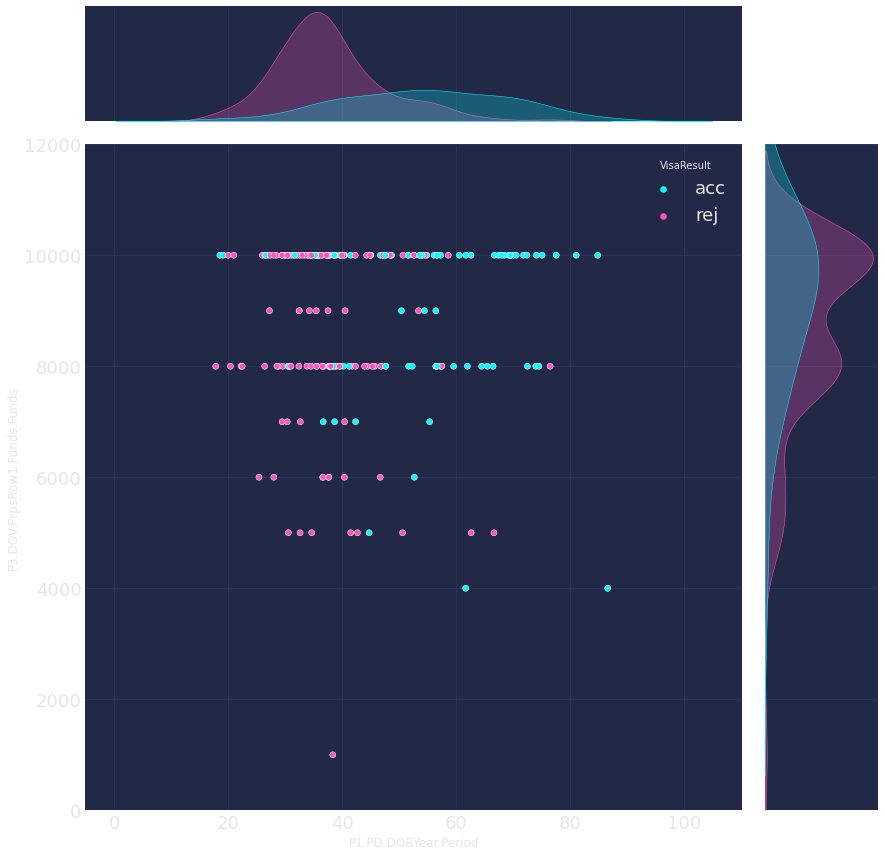

In [192]:
sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
plt.ylim(0, 12e3)
# plt.title('{} and {} vs {}'.format(feature_name[0], feature_name[1], output_name))
plt.show()

Since lower age decreases the likelihood of acceptance considerably, having larger funds is compensating.

#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [193]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P1.MS.SecA.MS'

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


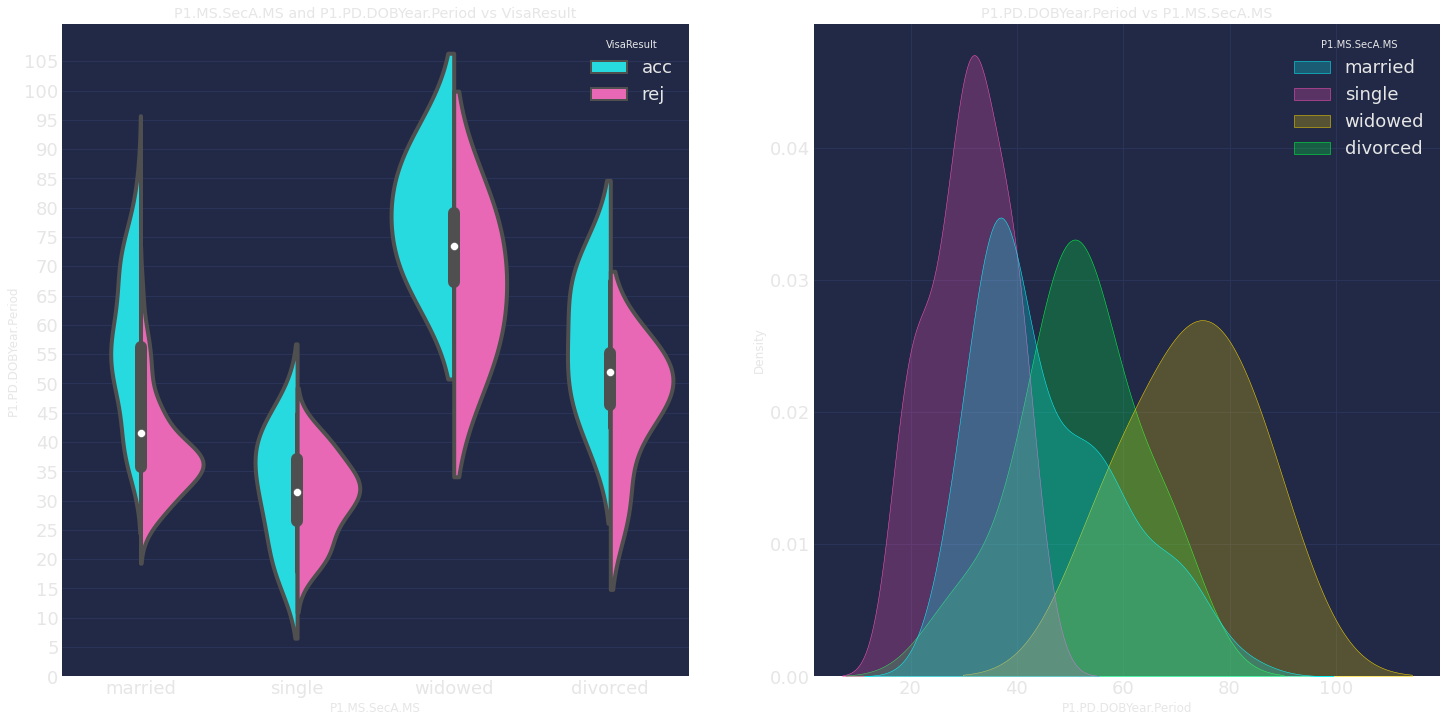

In [194]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 110, 5))
sns.kdeplot(x=feature_name[0], hue=feature_name[1], common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[0], feature_name[1]))
# ax[1, 1].set_xticks(range(0, 100, 5))
plt.show()


It seems that 'marital status' has been encoded in 'age' or wise versa.

For instance:
1. Single people's acceptance mean is way lower age than other groups. This is counter intuitive, because most of these young and 'single' people are with their family probably, so their parents are the actual applicants. This can be confirmed by looking at the trail of 'single' where it expands to lower ages.
2. 'divorced' and 'married' people's age seems irrelevant. Although, we see that peak of rejection and acceptance for 'divorced' people are higher and this is obvious since usually, 'divorced' people have higher average age.
3. 'widowed' case has similar status as the latter statement in 2.

### 'P1.MS.SecA.DateOfMarr.Period' -> continuous

In [195]:
# convert to years but continuous
feature_name = 'P1.MS.SecA.DateOfMarr.Period'
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [196]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.Sex.Sex'

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


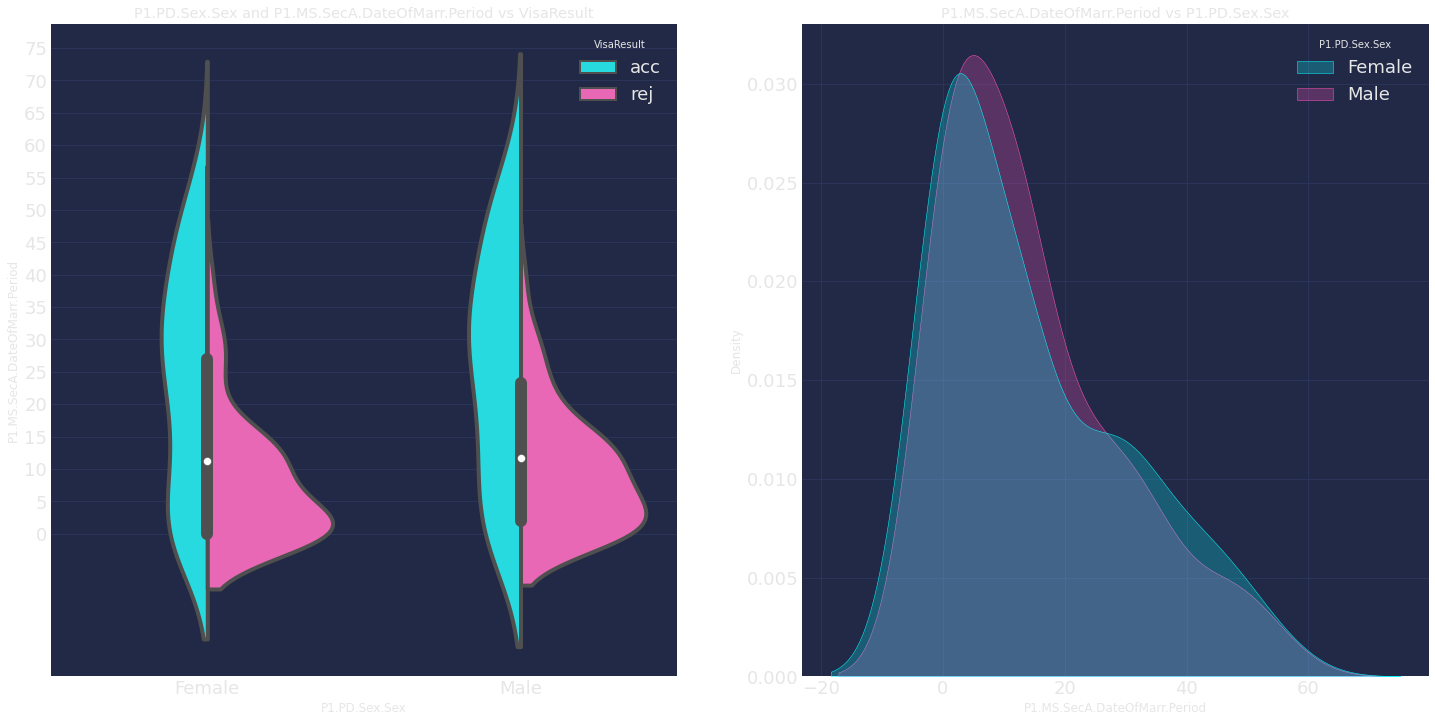

In [197]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 80, 5))
sns.kdeplot(x=feature_name[0], hue=feature_name[1], common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[0], feature_name[1]))
plt.show()


Seems like there is no insight in relation of gender to marriage period.

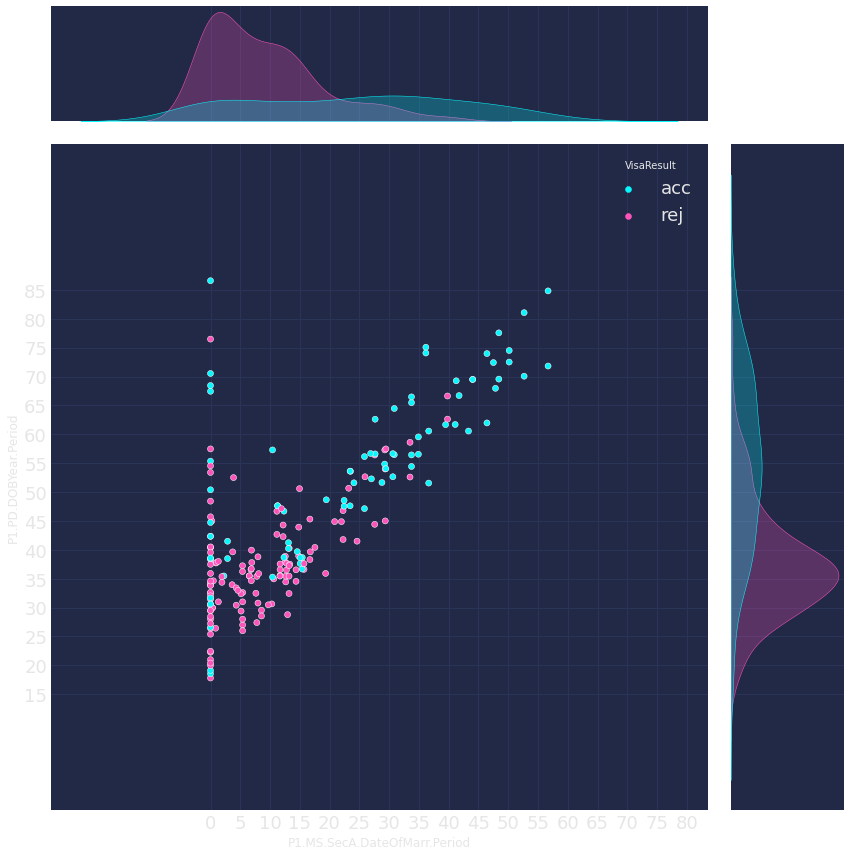

In [198]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.DOBYear.Period'
g= sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
g.ax_joint.set_xticks(range(0, 81, 5))
g.ax_joint.set_yticks(range(15, 90, 5))
plt.show()

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


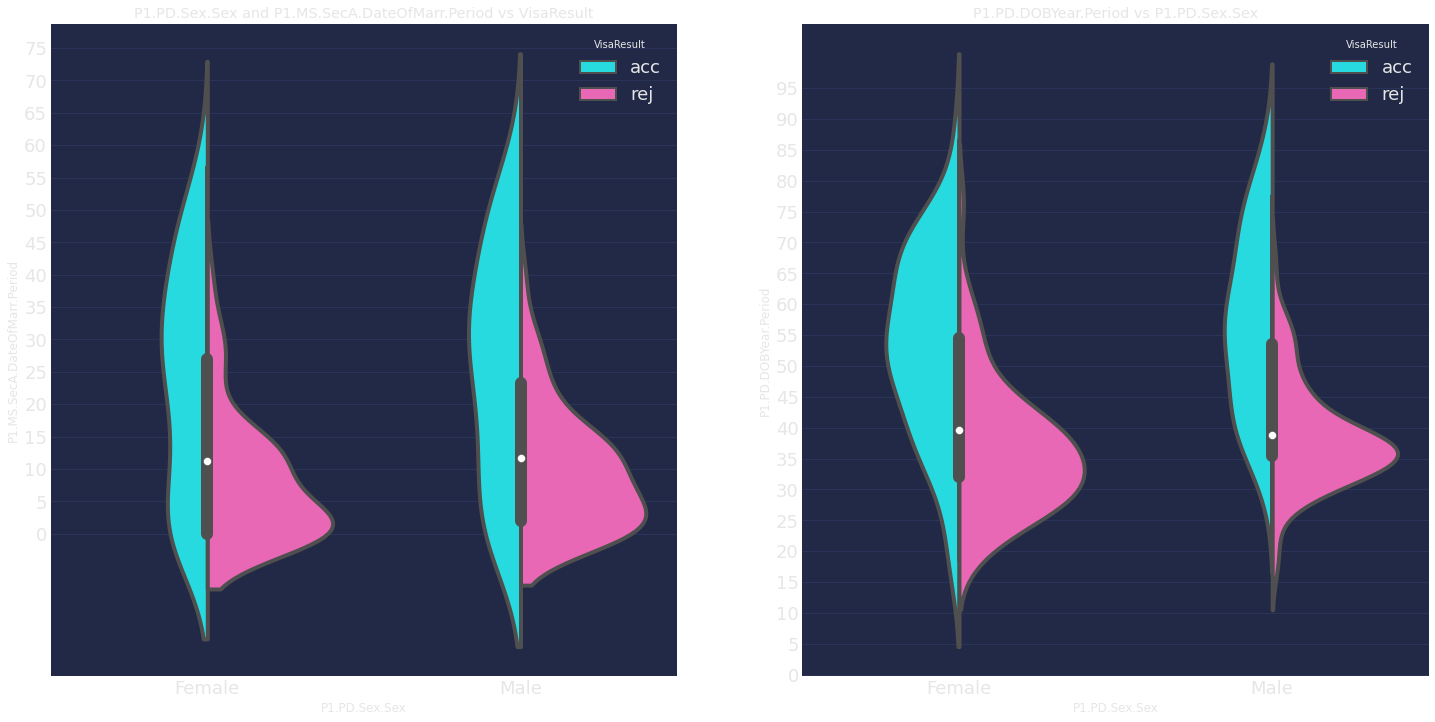

In [199]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.Sex.Sex', 'P1.PD.DOBYear.Period', 

f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 80, 5))
sns.violinplot(feature_name[1], feature_name[2],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
ax[1].set_yticks(range(0, 100, 5))
plt.show()


Even though it seems that a lot of people with short to medium marriages (<=10) when they are in their early 30s or late 20s have been rejected (previous scatter graph), here, we can see that having marriage even for a short period increases the likelihood considerably (look at the bumps on the figure on the left around Yaxis=0 and smooth very low density on the figure on the right.)

TODO: see issue #15. Seems that such a thing would improve.

### 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period' and 'P2.MS.SecA.Period' -> continuous

In [200]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period', 'P2.MS.SecA.Period'
data[feature_name[0]] = data[feature_name[0]].apply(lambda x: x/365.)
data[feature_name[1]] = data[feature_name[1]].apply(lambda x: x/365.)

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


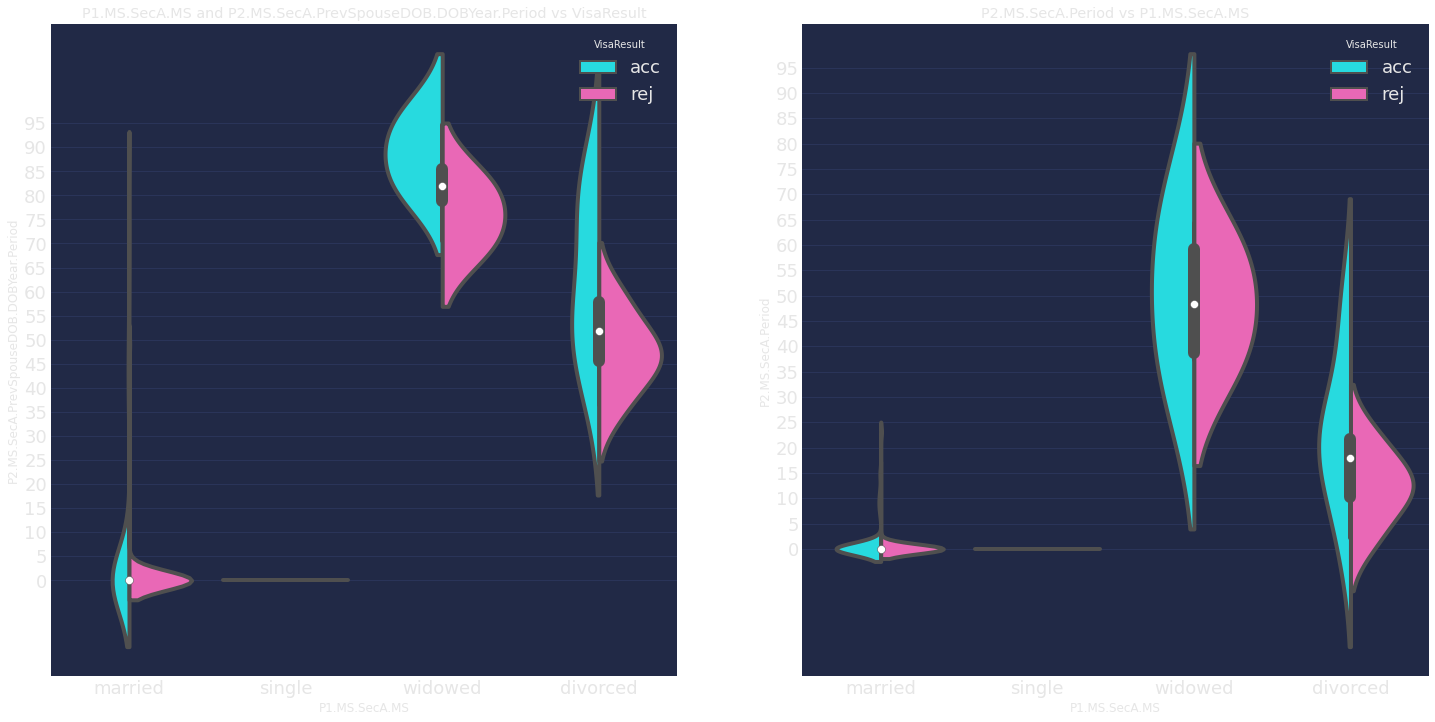

In [201]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period', 'P1.MS.SecA.MS', 'P2.MS.SecA.Period'

f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 100, 5))
sns.violinplot(feature_name[1], feature_name[2],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
ax[1].set_yticks(range(0, 100, 5))
plt.show()


It is hard to extract any insights from it since all range of age exist for all categories (except single/married of course), so I leave it there until further investigation.

TODO: maybe delete? no idea how useful it is 
1. Having previous marriage's period seems to contain all information we need about previous marriage, hence, the age of previous spouse does not provide any useful information.

In [202]:
# drop useless
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period'
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Psprt.ExpiryDate.Remaining -> continuous

In [203]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
data[feature_name] = data[feature_name].apply(lambda x: x/30.)

In [204]:
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
print(data[data[feature_name] < 5.].__len__())

2


For some reason, we have to samples that have negative expiration date. For conversion, we can use `.abs` to mirror them or use statistical methods to fill, e.g. `mode`.

In [205]:
data.loc[data[feature_name] < 5., feature_name] = data[data[feature_name] < 5.][feature_name].apply(lambda x: np.abs(x))
print(data[data[feature_name] < 5.].__len__())

0


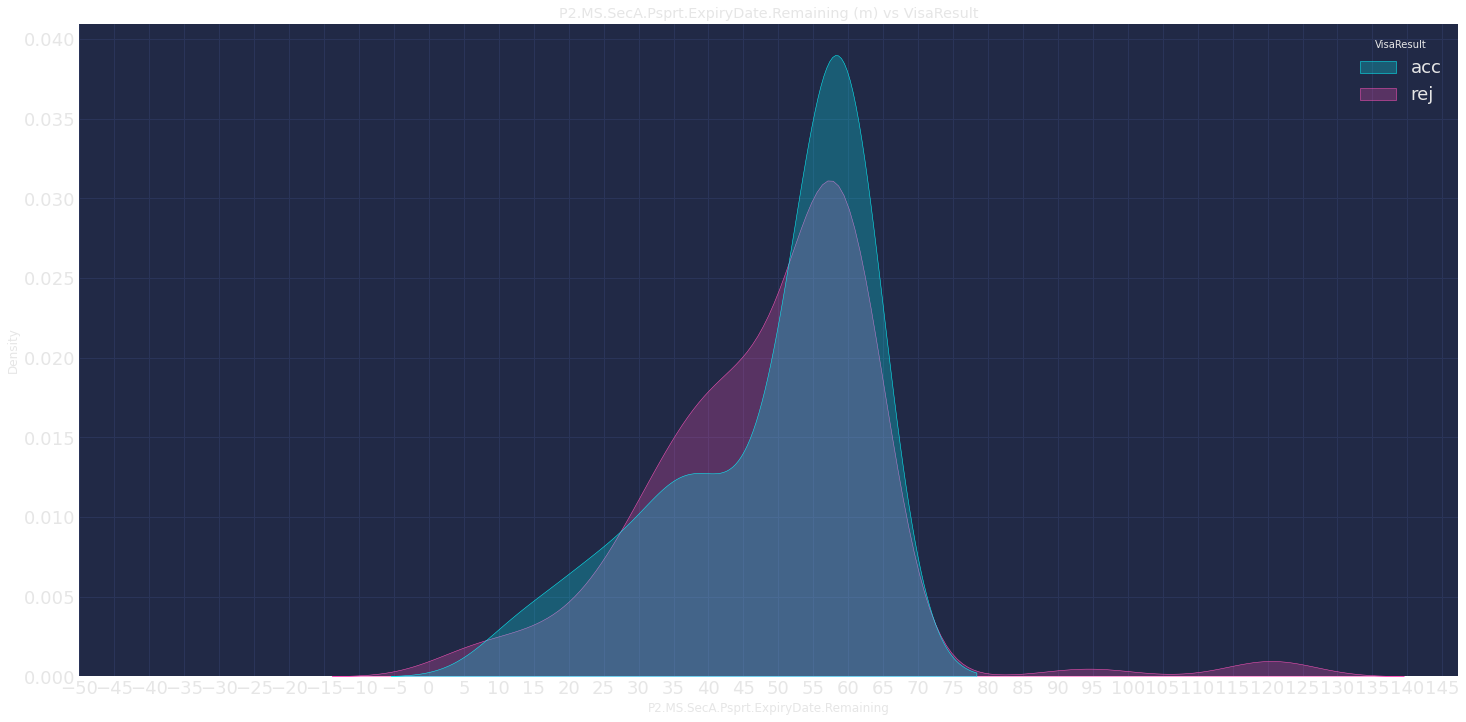

In [206]:
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.kdeplot(x=feature_name, hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax)
ax.set_xticks(range(-50, 150, 5))
ax.set_title('{} (m) vs {}'.format(feature_name, output_name))
plt.show()


There are three points of interest here, one around 5-10 and the other around 60 on x axis.
1. 5-10: It seems that not having long enough expiration date on passport suggests that the applicant is more likely to get rejected.
2. 60: 60 month or 5 years are the expiration period for fresh Iranian passports and it might mean that they are children of a family and their parent's features are carrying them.

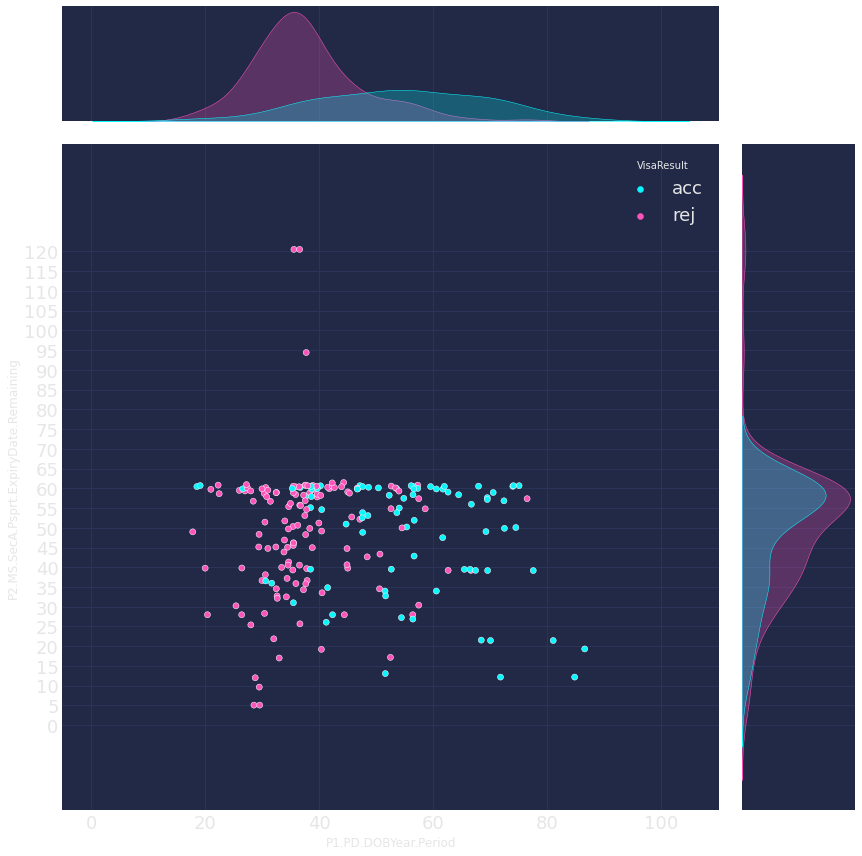

In [207]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
g = sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
# g.ax_joint.set_xticks(range(0, 81, 5))
g.ax_joint.set_yticks(range(0, 125, 5))
plt.show()

### P3.DOV.PrpsRow1.HLS.Period -> continuous

#### P3.DOV.PrpsRow1.HLS.Period and 'P3.DOV.PrpsRow1.Funds.Funds'

In [208]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.HLS.Period', 'P3.DOV.PrpsRow1.Funds.Funds'

In [209]:
data[data[feature_name[1]] > 10000]

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
110,False,Male,1.107154,1.0,1.429856,1.429856,True,TURKEY,6.0,married,False,family visit,30000.0,f1,ukn,False,<NA>,1.000000,1.107154,1.107154,1.107154,False,False,False,60.561644,0.0,0.0,NaN,36.643836,0.0,33.966667,31.0,0.00000,36.024658,0.00000,0.0,1.0,0.0,0.0,0.0,5.0,IRAN,PERSIAN-PICTURE CARPET WEAVER,True,IRAN,HOUSEWIFE,False,5.0,IRAN,CHEF RETIRED,False,5.0,5.0,DAUGHTER,IRAN,ARCHITECT,False,6.0,SON,IRAN,STUDENT,False,6.0,SON,IRAN,STUDENT,True,9.0,OTHER,IRAN,OTHER,False,5.0,SISTER,IRAN,HOUSEWIFE,False,5.0,BROTHER,IRAN,CHEF,False,5.0,SISTER,IRAN,HOUSEWIFE,False,5.0,BROTHER,IRAN,CHEF,False,5.0,SISTER,IRAN,HOUSEWIFE,False,5.0,BROTHER,IRAN,CHEF,False,9.0,OTHER,IRAN,OTHER,False,18909.0,27158.0,29831.0,12957.0,12586.0,2683.0,0.0,22426.0,20547.0,18876.0,16686.0,15095.0,13889.0,17919.833333,acc,0
220,False,Female,1.107154,1.0,1.429856,1.429856,False,TURKEY,3.0,married,False,family visit,20000.0,f2,f2,True,bachelor,3.177804,1.1

we have two cases where have 20K and 30K funds, hence, for visualization purposes, I have excluded them.

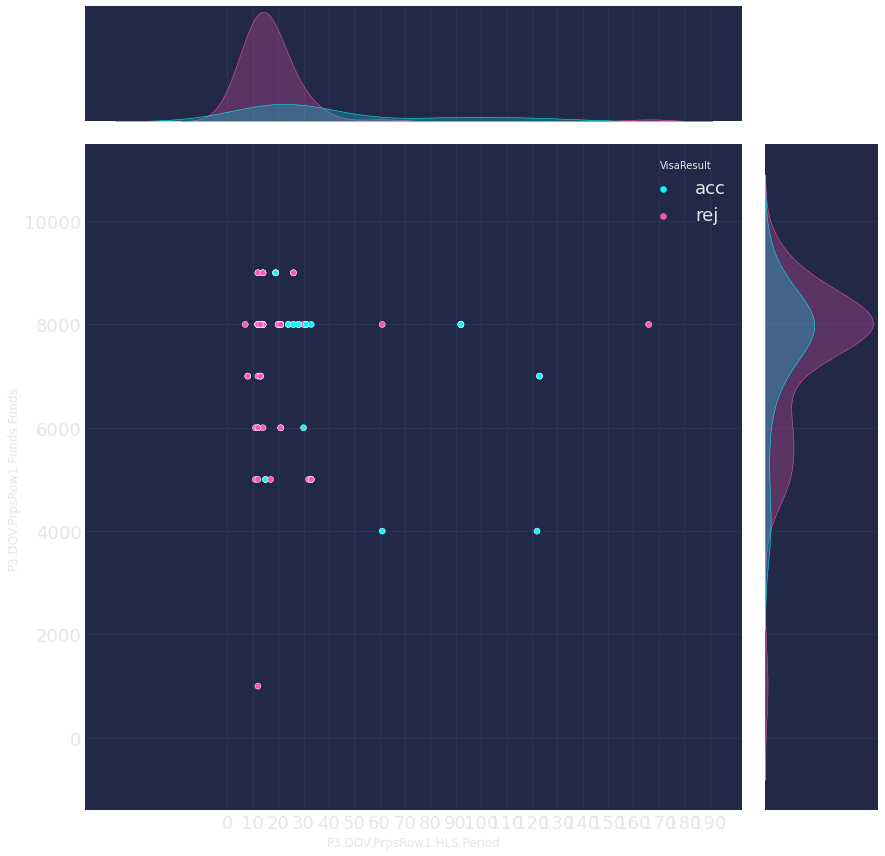

In [210]:
g = sns.jointplot(
    data=data[((data[output_name] == 'acc') | (data[output_name] == 'rej')) & (data[feature_name[1]] < 10000)],
    x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
g.ax_joint.set_xticks(range(0, 200, 10))
plt.show()

It seems many people who have **chosen below 30 days stay have been rejected for any amount of funds.**. As we can see on the top distribution, peak of rejection is on 10 days!

But, this could be because of other reasons, for instance, those who are coming for tourism, would mostly stay for 2 weeks, and most of the rejections are for tourism. So, we check purpose of visit and the duration.

#### P3.DOV.PrpsRow1.HLS.Period and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [211]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.HLS.Period', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P3.DOV.PrpsRow1.Funds.Funds'

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


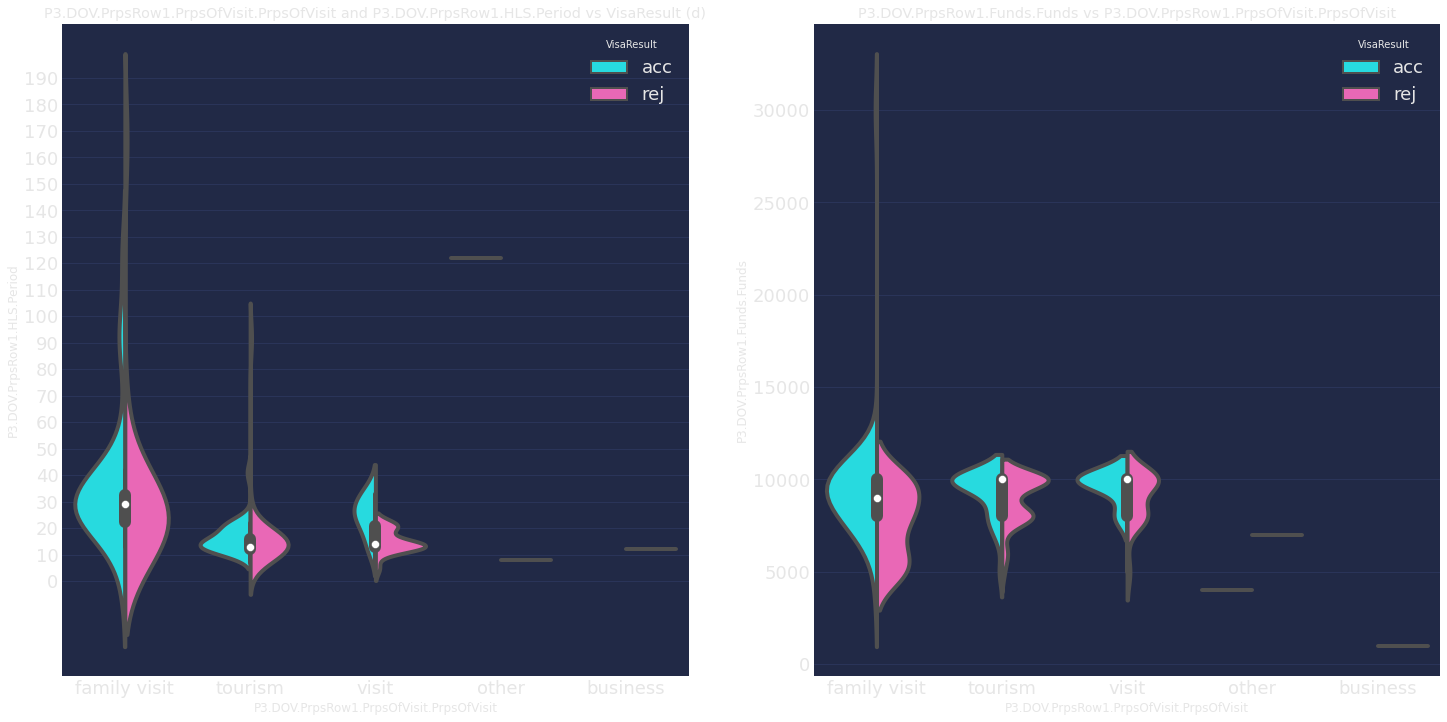

In [212]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {} (d)'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 200, 10))
sns.violinplot(feature_name[1], feature_name[2], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
# ax[1, 1].set_xticks(range(0, 100, 5))
plt.show()


My intuition was not wrong! We can see that even though peak of funds for all visits (except family visit a bit) are around 10K, meanwhile, those who chose shorter visits, i.e. <30 days, have been rejected more. 

### p1.Subform1.Visitor, p1.Subform1.Worker, p1.Subform1.Student, and p1.Subform1.Other

In [213]:
output_name = 'VisaResult'
feature_name = 'p1.Subform1.Visitor', 'p1.Subform1.Worker', 'p1.Subform1.Student', 'p1.Subform1.Other'
data.groupby([*feature_name, output_name])[output_name].count()

p1.Subform1.Visitor  p1.Subform1.Worker  p1.Subform1.Student  p1.Subform1.Other  VisaResult
0.0                  0.0                 0.0                  0.0                acc             5
                                                                                 no idea         1
                                                                                 rej             8
1.0                  0.0                 0.0                  0.0                acc            76
                                                                                 no idea        55
                                                                                 rej           123
                                                                                 w-acc          14
                                                                                 w-rej          16
Name: VisaResult, dtype: int64

In [214]:
# drop useless
data.drop([*feature_name], axis=1, inplace=True)

Ok, everyone is a `visitor`, they just forgot to mention it! So, delete it.

### p1.SecA.Sps.SpsCOB, p1.SecA.Fa.FaCOB, p1.SecA.Mo.MoCOB, p1.SecB.Chd.X.ChdCOB, p1.SecC.Chd.X.ChdCOB -> categorical

I don't think having a father born in different country make a difference from having a foreigner mother. Same for brother or sister. So, let's aggregate all of these into one single column, calling it `hasForeignF1` which means if the applicant has any tier 1 family member, with different nationality than applicant's.

***BUT***, there should be difference in following cases:
1. Having a foreign **sibling**: Candidate more likely to not live in their own country of birth


It's better to create a separate variable for cases mentioned above.

In [215]:
feature_name = [c for c in data.columns.values if 'ChdCOB' in c]
feature_name.extend([c for c in data.columns.values if 'MoCOB' in c or 'FaCOB' in c or 'SpsCOB' in c])
feature_name

['p1.SecB.Chd.[0].ChdCOB',
 'p1.SecB.Chd.[1].ChdCOB',
 'p1.SecB.Chd.[2].ChdCOB',
 'p1.SecB.Chd.[3].ChdCOB',
 'p1.SecC.Chd.[0].ChdCOB',
 'p1.SecC.Chd.[1].ChdCOB',
 'p1.SecC.Chd.[2].ChdCOB',
 'p1.SecC.Chd.[3].ChdCOB',
 'p1.SecC.Chd.[4].ChdCOB',
 'p1.SecC.Chd.[5].ChdCOB',
 'p1.SecC.Chd.[6].ChdCOB',
 'p1.SecA.Sps.SpsCOB',
 'p1.SecA.Mo.MoCOB',
 'p1.SecA.Fa.FaCOB']

In [216]:
# fillna with IRAN
print(data[feature_name].isna().sum())
data[feature_name] = data[feature_name].fillna(value='IRAN')

p1.SecB.Chd.[0].ChdCOB    0
p1.SecB.Chd.[1].ChdCOB    0
p1.SecB.Chd.[2].ChdCOB    0
p1.SecB.Chd.[3].ChdCOB    0
p1.SecC.Chd.[0].ChdCOB    0
p1.SecC.Chd.[1].ChdCOB    0
p1.SecC.Chd.[2].ChdCOB    0
p1.SecC.Chd.[3].ChdCOB    0
p1.SecC.Chd.[4].ChdCOB    0
p1.SecC.Chd.[5].ChdCOB    0
p1.SecC.Chd.[6].ChdCOB    0
p1.SecA.Sps.SpsCOB        0
p1.SecA.Mo.MoCOB          8
p1.SecA.Fa.FaCOB          8
dtype: int64


In [217]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value

typos = ['iram', 'iaran', 'mahallat-iran', 'astara-iran', 'tehran-iran']

def code_search_dict(string: str, dic: dict, if_nan: str):    
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        # print('"{}" is not numeric ==> SKIPPED'.format(string))
        string = string.lower()
        return 'iran' if string in typos else string

data[feature_name] = data[feature_name].applymap(func=code_search_dict,
                                                 dic=functional.config_csv_to_dict(config_path),
                                                 if_nan='IRAN')

#### p1.SecC.Chd.X.ChdCOB -> categorical

Convert the list of siblings' country of birth to a single variable depicting how many foreigner sibling the candidate has.

In [218]:
from functools import reduce
import re
r = re.compile('p1.SecC.Chd.*.ChdCOB')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecC.Chd.[0].ChdCOB',
 'p1.SecC.Chd.[1].ChdCOB',
 'p1.SecC.Chd.[2].ChdCOB',
 'p1.SecC.Chd.[3].ChdCOB',
 'p1.SecC.Chd.[4].ChdCOB',
 'p1.SecC.Chd.[5].ChdCOB',
 'p1.SecC.Chd.[6].ChdCOB']

In [219]:
output_name = 'VisaResult'
data.groupby([*feature_name, output_name])[output_name].count()

p1.SecC.Chd.[0].ChdCOB  p1.SecC.Chd.[1].ChdCOB  p1.SecC.Chd.[2].ChdCOB  p1.SecC.Chd.[3].ChdCOB  p1.SecC.Chd.[4].ChdCOB  p1.SecC.Chd.[5].ChdCOB  p1.SecC.Chd.[6].ChdCOB  VisaResult
iran                    canada                  iran                    iran                    iran                    iran                    iran                    rej             1
                        iran                    iran                    iran                    iran                    iran                    iran                    acc            81
                                                                                                                                                                        no idea        55
                                                                                                                                                                        rej           130
                                                                             

In [220]:
def foreigner_sibling_count(series: pd.Series):
    return reduce(lambda x, y: x + np.sum(np.invert(np.isin([y], ['iran', None]))), series, 0)

data = data.copy()
# replace rows of previous country of residency to count of them
data['p1.SecC.Chd.X.ChdCOB.ForeignerCount'] = data[feature_name].agg(foreigner_sibling_count, axis=1)
data = data.rename(
    columns={foreigner_sibling_count.__name__: 'p1.SecC.Chd.X.ChdCOB.ForeignerCount'})
# delete redundant columns tnx to newly created 'p1.SecC.Chd.X.ChdCOB.ForeignerCount'
data.drop(feature_name, axis=1, inplace=True)

In [221]:
data[data['p1.SecC.Chd.X.ChdCOB.ForeignerCount'] > 0]

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count,p1.SecC.Chd.X.ChdCOB.ForeignerCount
26,False,Male,1.107154,1.0,1.429856,1.429856,False,TURKEY,6.0,married,False,family visit,5000.0,f1,ukn,True,master,3.177804,1.107154,1.107154,1.107154,False,False,False,32.608219,0.0,0.0,90.0,5.402740,0.0,32.733333,32.0,6.005479,13.597260,0.0,0.0,5.0,iran,ACCOUNTANT,False,iran,HOUSEWIFE,False,5.0,iran,RETIRED,False,5.0,9.0,OTHER,iran,OTHER,False,9.0,OTHER,iran,OTHER,False,9.0,OTHER,iran,OTHER,False,9.0,OTHER,iran,OTHER,False,5.0,SISTER,EMPLOYEE,False,5.0,BROTHER,ELECTRICAL ASSISTANT,False,9.0,OTHER,OTHER,False,9.0,OTHER,OTHER,False,9.0,OTHER,OTHER,False,9.0,OTHER,OTHER,False,9.0,OTHER,OTHER,False,11605.0,22693.0,24363.0,0.0,0.0,0.0,0.0,12713.0,9888.0,11300.5,11300.5,11300.5,11300.5,11300.5,rej,0,1
40,False,Male,1.107154,1.0,1.429856,1.429856,False,TURKEY,3.0,married,False,tourism,10000.0,hotel,ukn,True,bachelor,3.177804,1.107154,1.107154,1.107154,False,True,True,36.068493,0.0,0.0,30.0,10.893151,0.0,28.033333,6.0,5.002740,7.046575,0.0,0.0,5.0,iran,HOUSEWIFE,False,iran,HOUSEWIFE,False,5.0,iran,SELF EMPLOYED,False,5.0,6.0,SON,iran,OTHER,False,6.0,DAUGHTER,iran,OTHER,False,9.0,OTHER,iran,OTHER,False,9.0,OTHER,iran,OTHER,Fa

In [222]:
output_name = 'VisaResult'
feature_name = 'p1.SecC.Chd.X.ChdCOB.ForeignerCount', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                         acc  \
p1.SecC.Chd.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                   business                                  0.000000   
                                    family visit                             22.641509   
                                    other                                     0.471698   
                                    tourism                                  12.735849   
                                    visit                                     2.358491   
1                                   business                                  0.000000   
                                    family visit                              0.000000   
                                    other                                     0.000000   
                                    tourism                                   0.000000   
                                    visit                                     0.000000   

VisaResult                                                                         rej  \
p1.SecC.Chd.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                   business                                  0.471698   
                                    family visit                             10.377358   
                                    other                                     0.943396   
                                    tourism                                  40.566038   
                                    visit                                     8.962264   
1                                   business                                  0.000000   
                                    family visit                              0.471698   
                                    other                                     0.000000   
                                    tourism                                   0.000000   
                                    visit                                     0.000000   

VisaResult                                                                         All  
p1.SecC.Chd.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                                   business                                  0.471698  
                                    family visit                             33.018868  
                                    other                                     1.415094  
                                    tourism                                  53.301887  
                                    visit                                    11.320755  
1                                   business                                  0.000000  
                                    family visit                              0.471698  
                                    other                                     0.000000  
                                    tourism                                   0.000000  
                                    visit                                     0.000000

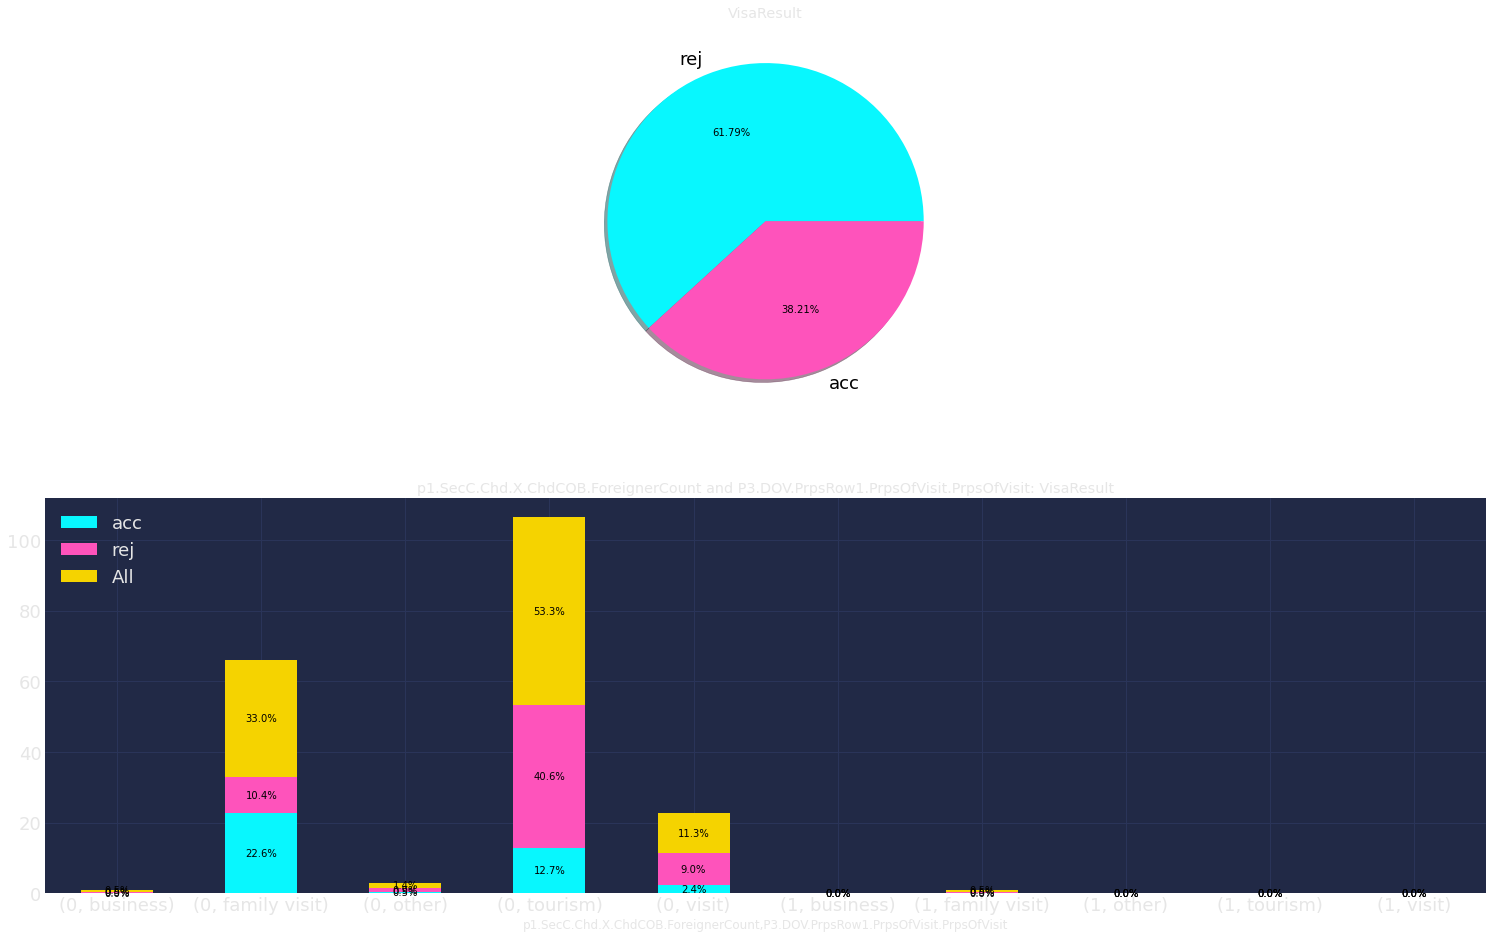

In [223]:
f, ax = plt.subplots(2, 1, figsize=(23, 16))
data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True, textprops={'color':'black'})
ax[0].set_title('VisaResult')
ax[0].set_ylabel('')

ct.plot(kind='bar', stacked=True, rot=0, ax=ax[1])
ax[1].set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax[1].legend(loc='upper left')
for c in ax[1].containers:
    ax[1].bar_label(c, label_type='center', fmt='%1.1f%%', color='black')
plt.show()


#### p1.SecB.Chd.X.ChdCOB, p1.SecA.Mo.MoCOB, p1.SecA.Fa.FaCOB -> categorical

Convert the list of children/parents' country of birth to a single variable depicting how many foreigner children/parents the candidate has.

In [224]:
from functools import reduce
import re
r = re.compile('p1.SecB.Chd.*.ChdCOB')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name.extend([c for c in data.columns.values if 'MoCOB' in c or 'FaCOB' in c or 'SpsCOB' in c])
feature_name

['p1.SecB.Chd.[0].ChdCOB',
 'p1.SecB.Chd.[1].ChdCOB',
 'p1.SecB.Chd.[2].ChdCOB',
 'p1.SecB.Chd.[3].ChdCOB',
 'p1.SecA.Sps.SpsCOB',
 'p1.SecA.Mo.MoCOB',
 'p1.SecA.Fa.FaCOB']

In [225]:
output_name = 'VisaResult'
data.groupby([*feature_name, output_name])[output_name].count()

p1.SecB.Chd.[0].ChdCOB  p1.SecB.Chd.[1].ChdCOB  p1.SecB.Chd.[2].ChdCOB  p1.SecB.Chd.[3].ChdCOB  p1.SecA.Sps.SpsCOB  p1.SecA.Mo.MoCOB  p1.SecA.Fa.FaCOB  VisaResult
iran                    iran                    canada                  iran                    iran                iran              iran              rej             2
                                                iran                    iran                    iran                iran              iran              acc            81
                                                                                                                                                        no idea        56
                                                                                                                                                        rej           122
                                                                                                                                                        w-acc

In [226]:
def foreigner_sibling_count(series: pd.Series):
    return reduce(lambda x, y: x + np.sum(np.invert(np.isin([y], ['iran', None]))), series, 0)

data = data.copy()
# replace rows of previous country of residency to count of them
data['p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount'] = data[feature_name].agg(foreigner_sibling_count, axis=1)
data = data.rename(
    columns={foreigner_sibling_count.__name__: 'p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount'})
# delete redundant columns tnx to newly created 'p1.SecB.Chd.X.ChdCOB.ForeignerCount'
data.drop(feature_name, axis=1, inplace=True)

In [227]:
data[data['p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount'] > 0]['p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount']

51     1
117    1
150    1
159    1
160    2
174    1
175    1
224    2
268    1
Name: p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount, dtype: int64

In [228]:
output_name = 'VisaResult'
feature_name = 'p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                                acc  \
p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                          business                                  0.000000   
                                           family visit                             22.641509   
                                           other                                     0.471698   
                                           tourism                                  12.735849   
                                           visit                                     2.358491   
1                                          business                                  0.000000   
                                           family visit                              0.000000   
                                           other                                     0.000000   
                                           tourism                                   0.000000   
                                           visit                                     0.000000   
2                                          business                                  0.000000   
                                           family visit                              0.000000   
                                           other                                     0.000000   
                                           tourism                                   0.000000   
                                           visit                                     0.000000   

VisaResult                                                                                rej  \
p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                          business                                  0.471698   
                                           family visit                              9.905660   
                                           other                                     0.943396   
                                           tourism                                  37.264151   
                                           visit                                     8.962264   
1                                          business                                  0.000000   
                                           family visit                              0.943396   
                                           other                                     0.000000   
                                           tourism                                   2.358491   
                                           visit                                     0.000000   
2                                          business                                  0.000000   
                                           family visit                              0.000000   
                                           other                                     0.000000   
                                           tourism                                   0.943396   
                                           visit                                     0.000000   

VisaResult                                                                                All  
p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                                          business                                  0.471698  
                                           family visit                             32.547170  
                                           other                                     1.415094  
                                           tourism                                  50.000000  
                                           visit                                    11.320755  
1                           

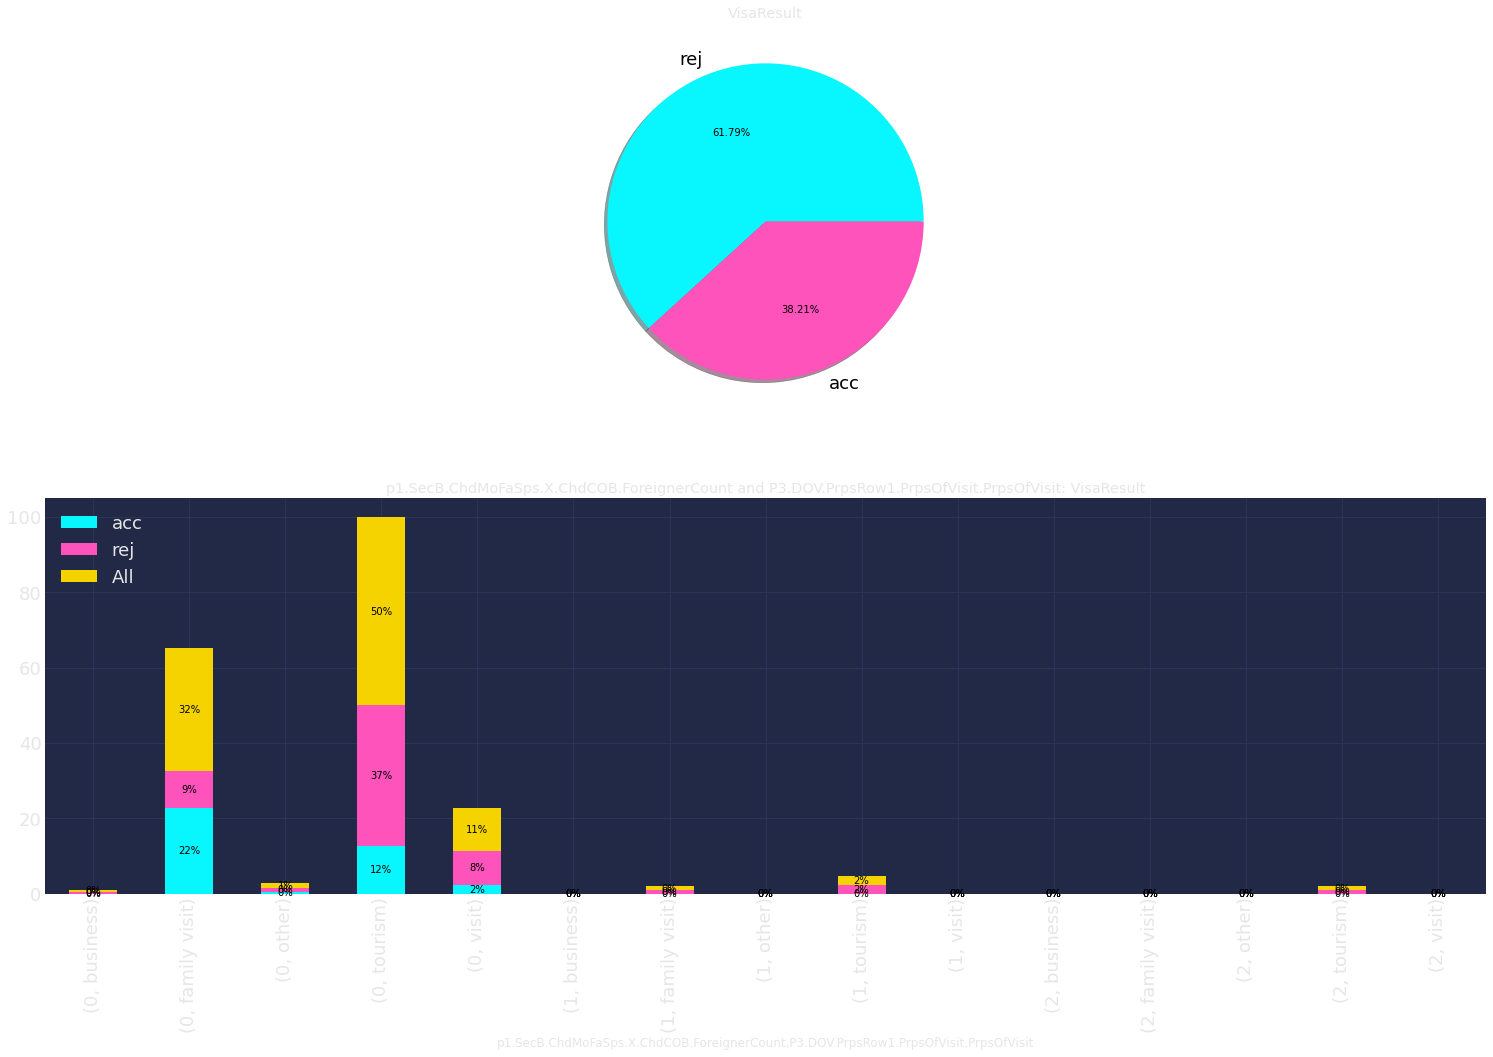

In [229]:
f, ax = plt.subplots(2, 1, figsize=(23, 16))
data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True, textprops={'color':'black'})
ax[0].set_title('VisaResult')
ax[0].set_ylabel('')

ct.plot(kind='bar', stacked=True, rot=90, ax=ax[1])
ax[1].set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax[1].legend(loc='upper left')
for c in ax[1].containers:
    ax[1].bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()


### p1.SecA.App.ChdMStatus -> categorical[/rank?]

TODO: ask agents if we can rank type of marriage and convert this into a **ordered** list?

In [230]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.MS', 'p1.SecA.App.ChdMStatus'

data.groupby([*feature_name, output_name])[output_name].count()

P1.MS.SecA.MS  p1.SecA.App.ChdMStatus  VisaResult
divorced       3.0                     acc            4
                                       no idea        1
                                       rej            5
               8.0                     acc            1
married        5.0                     acc           64
                                       no idea       46
                                       rej           91
                                       w-acc         12
                                       w-rej         11
               6.0                     rej            1
               9.0                     acc            1
                                       no idea        2
                                       rej            3
single         5.0                     rej            1
               7.0                     acc            9
                                       no idea        7
                                       rej           2

There is some inconsistency between two fields, some cases person put `divorced` in one field, and `widowed` in another field. There are cases where second field has value of `9` (unknown), but in other field, filled with some valid value. so after fixing these inconsistencies, this field contains all information about marriage, so we can drop marriage status obtained from 5256e and use 5645e marital statuses.

In [231]:
data[data[feature_name[1]] == 9].groupby([*feature_name, output_name])[output_name].count()

P1.MS.SecA.MS  p1.SecA.App.ChdMStatus  VisaResult
married        9.0                     acc           1
                                       no idea       2
                                       rej           3
widowed        9.0                     acc           1
Name: VisaResult, dtype: int64

In [232]:
# convert numbers to names
ms_name_num = {
    'married': 5,
    'single': 7,
    'common-law': 2,
    'divorced': 3,
    'separated': 4,
    'widowed': 8,
    'annulled': 1,
}
data.loc[data[feature_name[1]] == 9, feature_name[1]] = data[data[feature_name[1]] == 9][feature_name[0]].apply(lambda x: ms_name_num[x])

# status=9 should no longer exist
data.groupby([*feature_name, output_name])[output_name].count()

P1.MS.SecA.MS  p1.SecA.App.ChdMStatus  VisaResult
divorced       3.0                     acc            4
                                       no idea        1
                                       rej            5
               8.0                     acc            1
married        5.0                     acc           65
                                       no idea       48
                                       rej           94
                                       w-acc         12
                                       w-rej         11
               6.0                     rej            1
single         5.0                     rej            1
               7.0                     acc            9
                                       no idea        7
                                       rej           28
                                       w-acc          2
                                       w-rej          5
widowed        8.0                     acc            

In [233]:
# drop useless
data.drop([feature_name[0]], axis=1, inplace=True)

### p1.SecA.Sps.SpsOcc -> categorical -> continuous

TODO: currently I don't know how convert jobs to continuous or ordered values, so, we just drop em all!

In [234]:
feature_name = [c for c in data.columns.values if (('Occ' in c) and ('OccRow' not in c))]
data.drop(feature_name, axis=1, inplace=True)

### p1.SecA.Sps.SpsAccomp, p1.SecA.Mo.MoAccomp, p1.SecA.Fa.FaAccomp, p1.SecB.Chd.X.ChdAccomp -> categorical -> rank

Convert the list of tier 1 family members' accompanying status to a single variable depicting how many of them are accompanying the candidate.

In [235]:
from functools import reduce
import re
r = re.compile('p1.SecB.Chd.*.ChdAccomp')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name.extend([c for c in data.columns.values if ((('Sps' in c) or ('Fa' in c) or ('Mo' in c)) and ('Accomp' in c))])
feature_name

['p1.SecB.Chd.[0].ChdAccomp',
 'p1.SecB.Chd.[1].ChdAccomp',
 'p1.SecB.Chd.[2].ChdAccomp',
 'p1.SecB.Chd.[3].ChdAccomp',
 'p1.SecA.Sps.SpsAccomp',
 'p1.SecA.Mo.MoAccomp',
 'p1.SecA.Fa.FaAccomp']

In [236]:
def accompanying_count(series: pd.Series):
    return reduce(lambda x, y: x + np.sum(np.isin([y], [True, None])), series, False)

# replace rows of previous country of residency to count of them
data['p1.SecB.ChdMoFaSps.X.ChdAccomp.Count'] = data[feature_name].agg(accompanying_count, axis=1)
data = data.rename(
    columns={foreigner_sibling_count.__name__: 'p1.SecB.ChdMoFaSps.X.ChdAccomp.Count'})
# delete redundant columns tnx to newly created 'p1.SecB.ChdMoFaSps.X.ChdAccomp.Count'
data.drop(feature_name, axis=1, inplace=True)

In [237]:
output_name = 'VisaResult'
feature_name = 'p1.SecB.ChdMoFaSps.X.ChdAccomp.Count', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                          acc  \
p1.SecB.ChdMoFaSps.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                    business                                  0.000000   
                                     family visit                              7.547170   
                                     other                                     0.471698   
                                     tourism                                   0.943396   
                                     visit                                     2.358491   
1                                    business                                  0.000000   
                                     family visit                             12.735849   
                                     other                                     0.000000   
                                     tourism                                   5.188679   
                                     visit                                     0.000000   
2                                    business                                  0.000000   
                                     family visit                              2.358491   
                                     other                                     0.000000   
                                     tourism                                   6.603774   
                                     visit                                     0.000000   
3                                    business                                  0.000000   
                                     family visit                              0.000000   
                                     other                                     0.000000   
                                     tourism                                   0.000000   
                                     visit                                     0.000000   

VisaResult                                                                          rej  \
p1.SecB.ChdMoFaSps.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                    business                                  0.471698   
                                     family visit                              8.018868   
                                     other                                     0.943396   
                                     tourism                                  12.735849   
                                     visit                                     3.301887   
1                                    business                                  0.000000   
                                     family visit                              2.358491   
                                     other                                     0.000000   
                                     tourism                                  14.150943   
                                     visit                                     1.886792   
2                                    business                                  0.000000   
                                     family visit                              0.000000   
                                     other                                     0.000000   
                                     tourism                                  10.849057   
                                     visit                                     1.886792   
3                                    business                                  0.000000   
                                     family visit                              0.471698   
                                     other                                     0.000000   
                                     tourism                                   2.830189   
                                     visit                                     1.88679

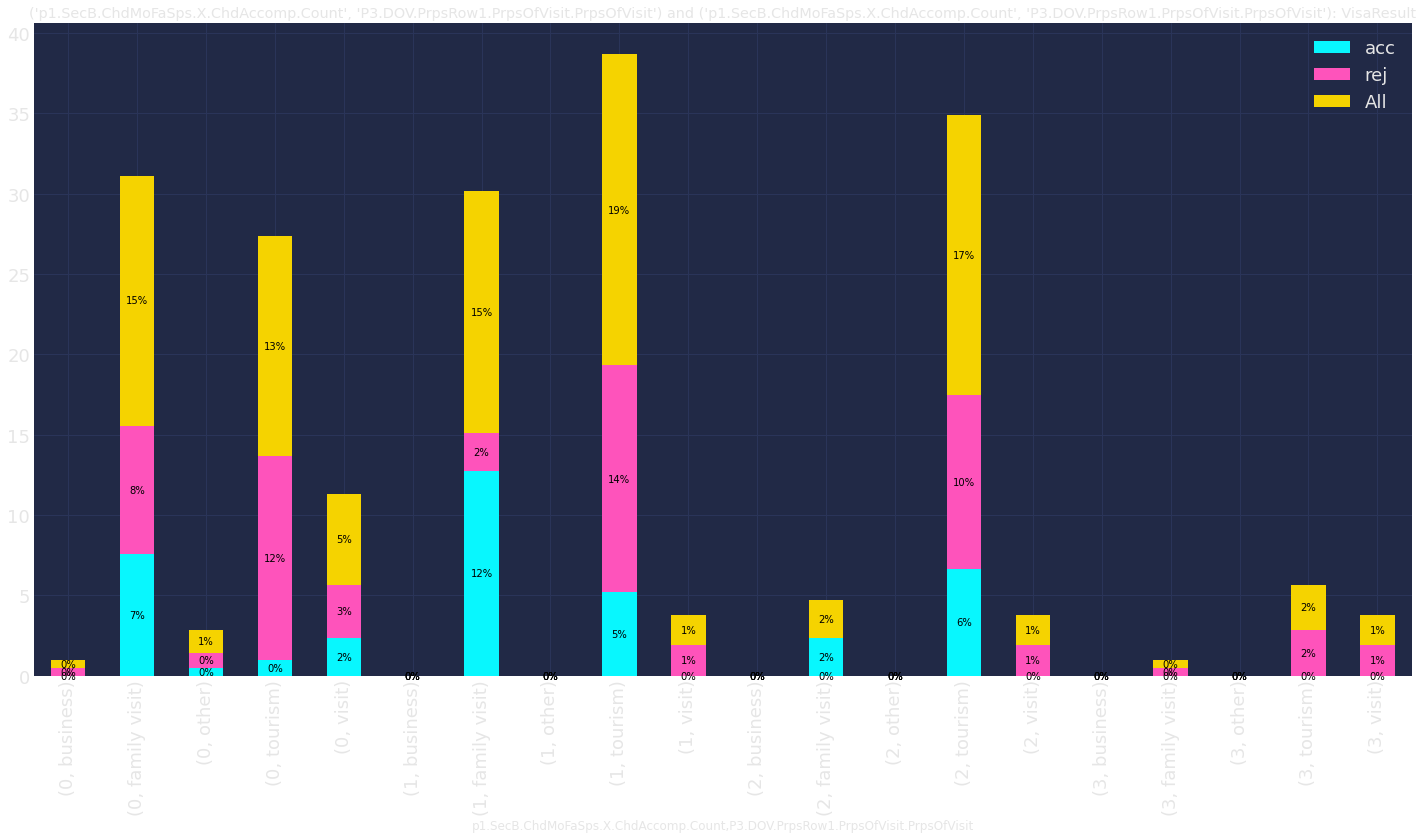

In [238]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

Following groups have higher chance:
1. `family visit` is generally good except with *large=`3`* family size
2. `family visit` chance decreases by increase in number of f1 family size
3. `tourism` chance increases by increasing the number of accompanying people
4. `visit` only is viable if you are going with `0` accompanying, not good if you going to `visit` with f1 member

### p1.SecC.Chd.X.ChdAccomp -> categorical -> rank

Convert the list of tier 1 family members' accompanying status to a single variable depicting how many of them are accompanying the candidate.

In [239]:
from functools import reduce
import re
r = re.compile('p1.SecC.Chd.*.ChdAccomp')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecC.Chd.[0].ChdAccomp',
 'p1.SecC.Chd.[1].ChdAccomp',
 'p1.SecC.Chd.[2].ChdAccomp',
 'p1.SecC.Chd.[3].ChdAccomp',
 'p1.SecC.Chd.[4].ChdAccomp',
 'p1.SecC.Chd.[5].ChdAccomp',
 'p1.SecC.Chd.[6].ChdAccomp']

In [240]:
def accompanying_count(series: pd.Series):
    return reduce(lambda x, y: x + np.sum(np.isin([y], [True, None])), series, False)

# replace rows of previous country of residency to count of them
data['p1.SecC.Chd.X.ChdAccomp.Count'] = data[feature_name].agg(accompanying_count, axis=1)
data = data.rename(
    columns={foreigner_sibling_count.__name__: 'p1.SecC.Chd.X.ChdAccomp.Count'})
# delete redundant columns tnx to newly created 'p1.SecC.Chd.X.ChdAccomp.Count'
data.drop(feature_name, axis=1, inplace=True)

In [241]:
output_name = 'VisaResult'
feature_name = 'p1.SecC.Chd.X.ChdAccomp.Count', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                   acc  \
p1.SecC.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                             business                                  0.000000   
                              family visit                             21.698113   
                              other                                     0.471698   
                              tourism                                  12.735849   
                              visit                                     2.358491   
1                             business                                  0.000000   
                              family visit                              0.943396   
                              other                                     0.000000   
                              tourism                                   0.000000   
                              visit                                     0.000000   

VisaResult                                                                   rej  \
p1.SecC.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                             business                                  0.471698   
                              family visit                              9.905660   
                              other                                     0.943396   
                              tourism                                  38.679245   
                              visit                                     8.490566   
1                             business                                  0.000000   
                              family visit                              0.943396   
                              other                                     0.000000   
                              tourism                                   1.886792   
                              visit                                     0.471698   

VisaResult                                                                   All  
p1.SecC.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                             business                                  0.471698  
                              family visit                             31.603774  
                              other                                     1.415094  
                              tourism                                  51.415094  
                              visit                                    10.849057  
1                             business                                  0.000000  
                              family visit                              1.886792  
                              other                                     0.000000  
                              tourism                                   1.886792  
                              visit                                     0.471698

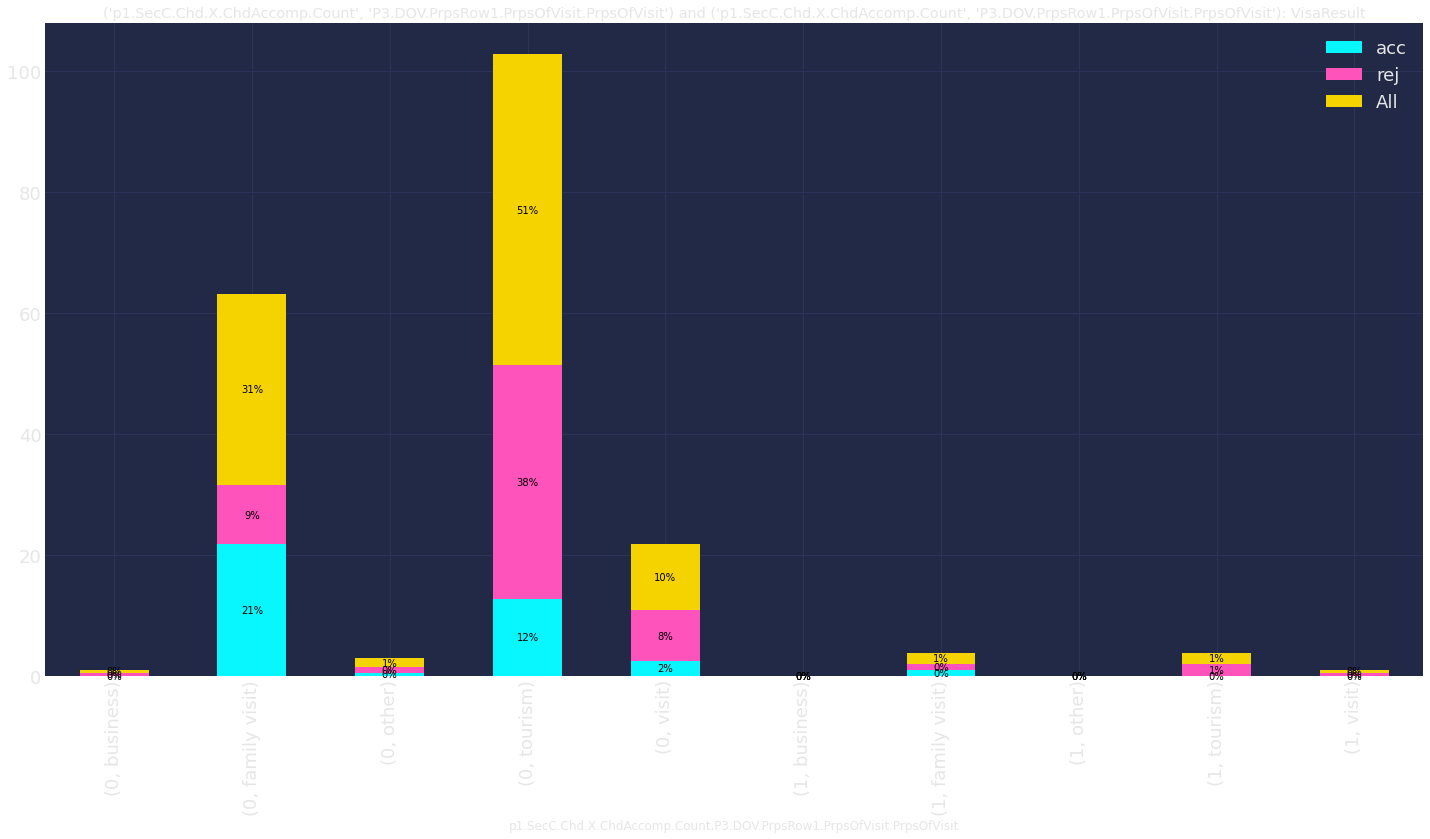

In [242]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

There is not much, except family visit which was already a dominant factor, regardless of the accompanying type and number. 

### p1.SecA.Sps.SpsDOB.Period -> continuous

In [243]:
output_name = 'VisaResult'
feature_name = ['p1.SecA.Sps.SpsDOB.Period', 'p1.SecA.Mo.MoDOB.Period', 'p1.SecA.Fa.FaDOB.Period']
data[feature_name].isna().sum()

p1.SecA.Sps.SpsDOB.Period    0
p1.SecA.Mo.MoDOB.Period      0
p1.SecA.Fa.FaDOB.Period      0
dtype: int64

In [244]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

We have deceased people and their age has been calculated from the day the data has been gathered. I.e. If someone died 30 years before the data was gathered, I still calculate the age like the person is still alive (when a bug makes a lot of copium!). Here, we set max age to 85 (❁´◡`❁).

In [245]:
data[feature_name] = data[feature_name].applymap(lambda x: 85. if x > 85 else x)

       p1.SecA.Sps.SpsDOB.Period  p1.SecA.Mo.MoDOB.Period  \
count                 298.000000               298.000000   
mean                   35.161690                61.707474   
std                    22.558734                22.381942   
min                     0.000000                 0.000000   
25%                    27.738356                57.422603   
50%                    37.652055                66.598630   
75%                    49.545205                74.417808   
max                    84.306849                85.000000   

       p1.SecA.Fa.FaDOB.Period  
count               298.000000  
mean                 63.301756  
std                  26.379887  
min                   0.000000  
25%                  61.304795  
50%                  70.664384  
75%                  82.060959  
max                  85.000000  


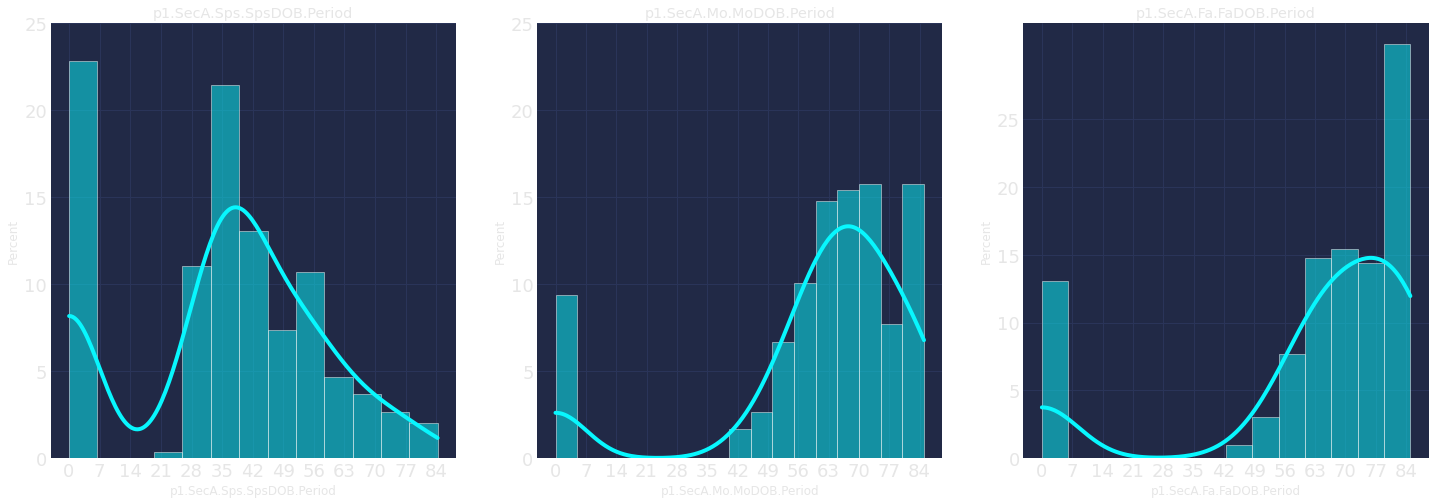

In [246]:
print(data[feature_name].describe())

f, ax = plt.subplots(1, 3, figsize=(22, 8))
for i, c in enumerate(feature_name):
    sns.histplot(data[c], ax=ax[i], kde=True, stat='percent')
    ax[i].set_title('{}'.format(c))
    ax[i].set_xticks(range(0, 90, 7), rotation='vertical', ha='right')
    ax[i].set_yticks(range(0, 30, 5))
plt.show()

### p1.SecB.Chd.[X].ChdDOB.Period and p1.SecB.Chd.[X].ChdMStatus and p1.SecB.Chd.[X].ChdRel

In [247]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecB.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecB.Chd.[0].ChdDOB.Period',
 'p1.SecB.Chd.[1].ChdDOB.Period',
 'p1.SecB.Chd.[2].ChdDOB.Period',
 'p1.SecB.Chd.[3].ChdDOB.Period']

In [248]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [249]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecB.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecB.Chd.[0].ChdMStatus',
 'p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[1].ChdMStatus',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdMStatus',
 'p1.SecB.Chd.[2].ChdRel',
 'p1.SecB.Chd.[3].ChdMStatus',
 'p1.SecB.Chd.[3].ChdRel']

I am going to use above features to find "ghost" and "incomplete" kids and fill them out properly. So, none of them should be `None`.

In [250]:
assert data[feature_name].isna().sum().sum() == 0

#### Fill `None`s of p1.SecB.Chd.[X].ChdDOB.Period

In [251]:
r = re.compile('p1.SecB.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
data[list(data.columns.values[mask])].isna().sum()

p1.SecB.Chd.[0].ChdDOB.Period    5
p1.SecB.Chd.[1].ChdDOB.Period    3
p1.SecB.Chd.[2].ChdDOB.Period    0
p1.SecB.Chd.[3].ChdDOB.Period    0
dtype: int64

Note that there are two types of `None`s originally:
1. Ghost children: Where child doest not exist at the first place and we filled `ChdRel = 'OTHER'` and `ChdMStatus = 9`, and `ChdDOB.Period = 0`. Already done when loading data.
2. Incomplete children: Where child exists but `ChdDOB.Period` is `None`. We like to fill this by other children if exists (already done when loading data), but when there is no other child or all children are missing `ChdDOB.Period`, we have to use statistical measure over all dataset to fill it. E.g. average difference of children's age from their parents decreased from missing cases' parent age.

In [252]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period'
    print(data.loc[(data[feature_name[i*2]] == 9) & (data[feature_name[i*2+1]] == 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

0
0
0
0


We have no instances of case (1) that has not been handled already.

In [253]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period'
    print(data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

3
2
0
0


In [254]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    print(data[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
          (data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

     p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
40                          6.0                    SON   
261                         6.0               DAUGHTER   
280                         6.0                    SON   

     p1.SecB.Chd.[0].ChdDOB.Period  
40                             NaN  
261                            NaN  
280                            NaN  
     p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
40                          6.0               DAUGHTER   
261                         6.0               DAUGHTER   

     p1.SecB.Chd.[1].ChdDOB.Period  
40                             NaN  
261                            NaN  
Empty DataFrame
Columns: [p1.SecB.Chd.[2].ChdMStatus, p1.SecB.Chd.[2].ChdRel, p1.SecB.Chd.[2].ChdDOB.Period]
Index: []
Empty DataFrame
Columns: [p1.SecB.Chd.[3].ChdMStatus, p1.SecB.Chd.[3].ChdRel, p1.SecB.Chd.[3].ChdDOB.Period]
Index: []


As we can see, case (2) is existence here. Now, I fill it!

In [255]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecB.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecB.Chd.[0].ChdMStatus',
 'p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[1].ChdMStatus',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdMStatus',
 'p1.SecB.Chd.[2].ChdRel',
 'p1.SecB.Chd.[3].ChdMStatus',
 'p1.SecB.Chd.[3].ChdRel']

In [256]:
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    aggregator_feature_name = 'P1.PD.DOBYear.Period'
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    print('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    na_parent_age = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

median difference of parents age from "0"th child: 28.938356164383556
median difference of parents age from "1"th child: 31.83698630136986
median difference of parents age from "2"th child: 28.564383561643837
median difference of parents age from "3"th child: 33.45890410958904


In [257]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[38, 256, 273]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[38, 256]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

     p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
40                          6.0                    SON   
261                         6.0               DAUGHTER   
280                         6.0                    SON   

     p1.SecB.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
40                        7.130137             36.068493  
261                      15.938356             44.876712  
280                       1.000000             27.991781  
     p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
40                          6.0               DAUGHTER   
261                         6.0               DAUGHTER   

     p1.SecB.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
40                        4.231507             36.068493  
261                      13.039726             44.876712  


So I managed to clap the cheeks of those who didn't fill out their damn children's age.

#### Fill `None`s of p1.SecB.Chd.[X].ChdDOB.Period (not case 1 or 2)

In [258]:
r = re.compile('p1.SecB.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
data[list(data.columns.values[mask])].isna().sum()

p1.SecB.Chd.[0].ChdDOB.Period    2
p1.SecB.Chd.[1].ChdDOB.Period    1
p1.SecB.Chd.[2].ChdDOB.Period    0
p1.SecB.Chd.[3].ChdDOB.Period    0
dtype: int64

In [259]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    print(data[(data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

     p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
43                          6.0                  OTHER   
124                         6.0                  OTHER   

     p1.SecB.Chd.[0].ChdDOB.Period  
43                             NaN  
124                            NaN  
    p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
43                         6.0                  OTHER   

    p1.SecB.Chd.[1].ChdDOB.Period  
43                            NaN  
Empty DataFrame
Columns: [p1.SecB.Chd.[2].ChdMStatus, p1.SecB.Chd.[2].ChdRel, p1.SecB.Chd.[2].ChdDOB.Period]
Index: []
Empty DataFrame
Columns: [p1.SecB.Chd.[3].ChdMStatus, p1.SecB.Chd.[3].ChdRel, p1.SecB.Chd.[3].ChdDOB.Period]
Index: []


In [260]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[41, 120]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[41]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

     p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
43                          6.0                  OTHER   
124                         6.0                  OTHER   

     p1.SecB.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
43                             NaN             46.939726  
124                            NaN             25.989041  
    p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
43                         6.0                  OTHER   

    p1.SecB.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
43                            NaN             46.939726  


In [261]:
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    aggregator_feature_name = 'P1.PD.DOBYear.Period'
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    print('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    na_parent_age = data.loc[(data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    data.loc[(data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

median difference of parents age from "0"th child: 29.467123287671228
median difference of parents age from "1"th child: 32.25068493150685
median difference of parents age from "2"th child: 28.564383561643837
median difference of parents age from "3"th child: 33.45890410958904


In [262]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[41, 120]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[41]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

     p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
43                          6.0                  OTHER   
124                         6.0                  OTHER   

     p1.SecB.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
43                       17.472603             46.939726  
124                       1.000000             25.989041  
    p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
43                         6.0                  OTHER   

    p1.SecB.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
43                      14.689041             46.939726  


### p1.SecB.Chd.[X].ChdRel -> categorical

Since there are some `other` in `ChdRel` here that are not "ghost case", we use `ChdDOB.Period` that have been already cleaned and filled based on conditions to detect "ghost" case from "incomplete" case. Hence, in this section, we just rely on non-zero cases of `ChdDOB.Period` to find out if child exists or not!

In [263]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecB.Chd\..*\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdRel',
 'p1.SecB.Chd.[3].ChdRel']

In [264]:
for f in feature_name:
    print(data[f].unique())

dic = {
    'DOUGHTER': 'daughter',
    'my daughter': 'daughter',
    'STEPDAUGHTER': 'step daughter',
    'STEP SON': 'step son',
    'SISTER': 'daughter',
    'BOY': 'son',
    'STEP DAUGHTER': 'step daughter',
    'STEP-SON': 'step son',
    'OTHER': 'other'
}

for f in feature_name:
    data[f] = data[f].apply(lambda x: dic[x] if x in dic.keys() else x.lower())

print('--- cleaned ---\n')
for f in feature_name:
    print(data[f].unique())

['DAUGHTER' 'SON' 'OTHER' 'son' 'Daughter' 'DOUGHTER' 'my daughter'
 'STEPDAUGHTER' 'daughter' 'STEP SON' 'SISTER' 'BOY']
['SON' 'OTHER' 'DAUGHTER' 'daughter' 'Daughter' 'DOUGHTER' 'son' 'SISTER']
['SON' 'OTHER' 'son' 'DAUGHTER' 'SISTER' 'STEP DAUGHTER' 'STEP-SON'
 'DOUGHTER']
['OTHER' 'SON' 'DAUGHTER' 'SISTER' 'STEP-SON']
--- cleaned ---

['daughter' 'son' 'other' 'step daughter' 'step son']
['son' 'other' 'daughter']
['son' 'other' 'daughter' 'step daughter' 'step son']
['other' 'son' 'daughter' 'step son']


In [265]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecB.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecB.Chd.[0].ChdDOB.Period',
 'p1.SecB.Chd.[1].ChdDOB.Period',
 'p1.SecB.Chd.[2].ChdDOB.Period',
 'p1.SecB.Chd.[3].ChdDOB.Period']

In [266]:
# aggregate into a single number
def rel_count(series: pd.Series):
    return reduce(lambda x, y: x + np.sum(y != 0.), series, 0.)

# replace rows of previous country of residency to count of them
aggregator_feature_name = 'p1.SecB.Chd.X.ChdRel.ChdCount'
data[aggregator_feature_name] = data[feature_name].agg(rel_count, axis=1)
data[aggregator_feature_name] = data[aggregator_feature_name].astype(int)
data = data.rename(columns={rel_count.__name__: aggregator_feature_name})

In [267]:
data[[*feature_name, aggregator_feature_name]]

,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecB.Chd.X.ChdRel.ChdCount
0,35.498630,34.482192,7.350685,0.000000,3
1,18.671233,0.000000,0.000000,0.000000,1
2,2.378082,0.000000,0.000000,0.000000,1
3,0.000000,0.000000,0.000000,0.000000,0
4,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...
300,21.821918,0.000000,0.000000,0.000000,1
301,7.065753,0.000000,0.000000,0.000000,1
302,46.950685,45.402740,40.783562,31.778082,4
303,0.000000,0.000000,0.000000,0.000000,0


#### Filling None "ghost case" `other` Randomly

This part is about converting `OTHER` as child-parent relation into `SON` or `DAUGHTER`. Possible methods:
1. Should I even do it? There is no context information to infer and filling it statistically is not rational
2. Biased random fill:
   1. with 50% chance if no kid or all kids are `OTHER`
   2. 75% to be boy if more than half of the kids are *girl*
   3. 25% to be boy if more than half of the kids are *boy*
3. Pure random fill: Just use %50 for any `OTHER` case <- **CURRENT IMPL.** 

I may wanna convert these into `['son', 'daughter', 'other']` or `['son', 'daughter', 'step', 'other']`

In [268]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecB.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
r = re.compile('p1.SecB.Chd\.\[.*\]\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
target_feature_name = list(data.columns.values[mask])
print(feature_name)
print(target_feature_name)

['p1.SecB.Chd.[0].ChdDOB.Period', 'p1.SecB.Chd.[1].ChdDOB.Period', 'p1.SecB.Chd.[2].ChdDOB.Period', 'p1.SecB.Chd.[3].ChdDOB.Period']
['p1.SecB.Chd.[0].ChdRel', 'p1.SecB.Chd.[1].ChdRel', 'p1.SecB.Chd.[2].ChdRel', 'p1.SecB.Chd.[3].ChdRel']


In [269]:
for f, tf in zip(feature_name, target_feature_name):
    f, tf = feature_name[i], target_feature_name[i]
    rng = np.random.default_rng(SEED)
    random_child = 'son' if rng.random() > 0.5 else 'daughter'
    data.loc[(data[f] != 0) & (data[tf] == 'other'), tf] = random_child

data[[*feature_name, *target_feature_name]].sample(5)

,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[3].ChdRel
23,3.098630,0.00000,0.0,0.0,daughter,other,other,other
119,0.556164,0.00000,0.0,0.0,son,other,other,other
290,0.000000,0.00000,0.0,0.0,other,other,other,other
297,25.161644,21.19726,0.0,0.0,daughter,son,other,other
29,1.479452,0.00000,0.0,0.0,son,other,other,other


In [270]:
data.sample()

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.SecA.App.ChdMStatus,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count,p1.SecC.Chd.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdAccomp.Count,p1.SecC.Chd.X.ChdAccomp.Count,p1.SecB.Chd.X.ChdRel.ChdCount
18,False,Female,1.107154,1.0,1.429856,1.429856,False,TURKEY,3.0,False,family visit,10000.0,f1,ukn,False,<NA>,1.0,1.107154,1.107154,1.107154,False,False,False,66.706849,0.0,0.0,28.0,41.747945,0.0,55.966667,42.0,0.0,41.687671,0.0,0.0,5.0,7.0,9.0,6.0,son,5.0,son,9.0,other,9.0,other,5.0,BROTHER,5.0,BROTHER,5.0,SISTER,5.0,BROTHER,9.0,OTHER,9.0,OTHER,9.0,OTHER,70.093151,85.0,85.0,39.989041,33.635616,0.0,0.0,25376.0,23217.0,22330.0,21614.0,23134.25,23134.25,23134.25,acc,0,0,0,0,1,2


In [271]:
output_name = 'VisaResult'
feature_name = 'p1.SecB.ChdMoFaSps.X.ChdAccomp.Count', 'p1.SecB.Chd.X.ChdRel.ChdCount'
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                               acc  \
p1.SecB.ChdMoFaSps.X.ChdAccomp.Count p1.SecB.Chd.X.ChdRel.ChdCount             
0                                    0                              2.830189   
                                     1                              1.886792   
                                     2                              4.245283   
                                     3                              0.943396   
                                     4                              1.415094   
1                                    0                              3.301887   
                                     1                              2.358491   
                                     2                              7.075472   
                                     3                              1.886792   
                                     4                              3.301887   
2                                    0                              1.415094   
                                     1                              4.716981   
                                     2                              0.943396   
                                     3                              1.886792   
                                     4                              0.000000   
3                                    0                              0.000000   
                                     1                              0.000000   
                                     2                              0.000000   
                                     3                              0.000000   
                                     4                              0.000000   

VisaResult                                                                rej  \
p1.SecB.ChdMoFaSps.X.ChdAccomp.Count p1.SecB.Chd.X.ChdRel.ChdCount              
0                                    0                              15.566038   
                                     1                               5.660377   
                                     2                               3.301887   
                                     3                               0.943396   
                                     4                               0.000000   
1                                    0                              10.849057   
                                     1                               1.886792   
                                     2                               3.301887   
                                     3                               0.943396   
                                     4                               1.415094   
2                                    0                               2.830189   
                                     1                               8.490566   
                                     2                               1.415094   
                                     3                               0.000000   
                                     4                               0.000000   
3                                    0                               0.000000   
                                     1                               0.000000   
                                     2                               5.188679   
                                     3                               0.000000   
                                     4                               0.000000   

VisaResult                                                                All  
p1.SecB.ChdMoFaSps.X.ChdAccomp.Count p1.SecB.Chd.X.ChdRel.ChdCount             
0                                    0                              18.396226  
                                     1                               7.547170  
                                     2                               7.547170  
                                     3                  

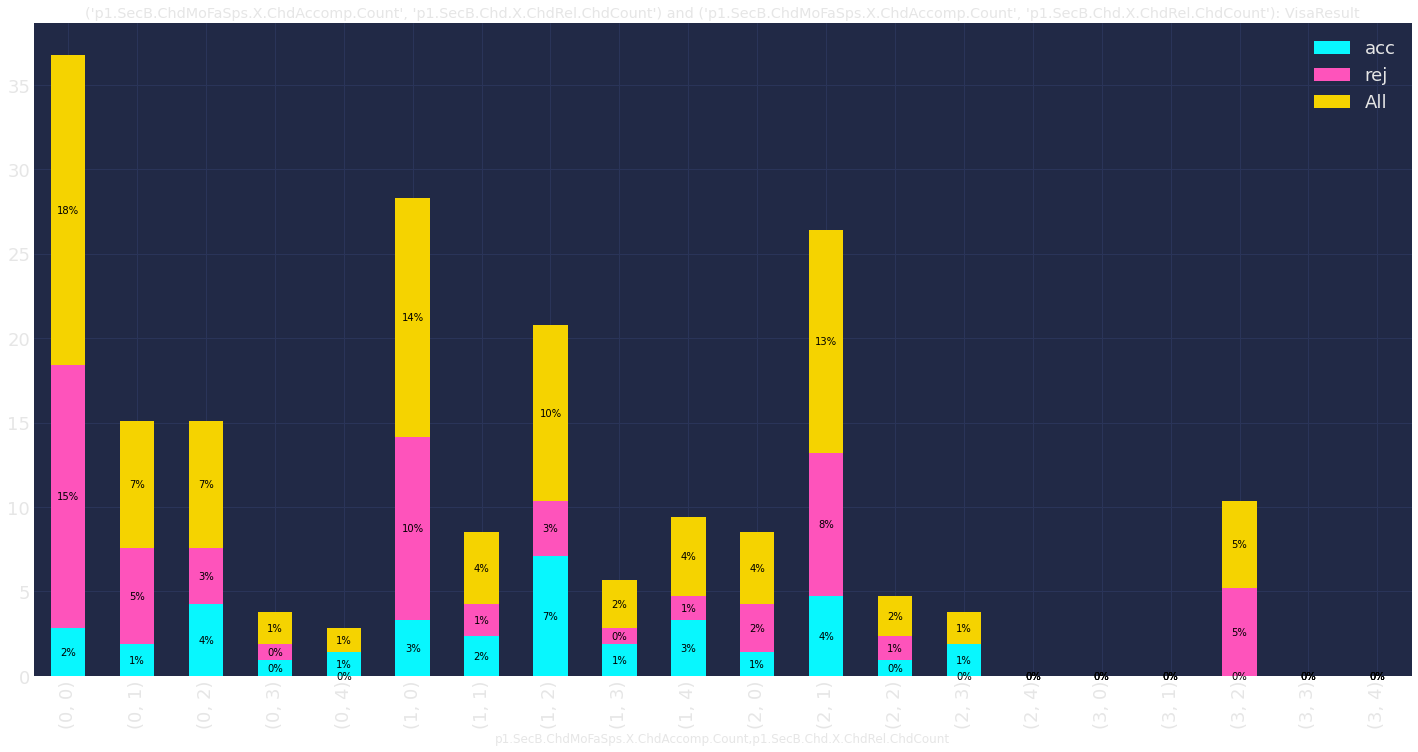

In [272]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

### p1.SecC.Chd.[X].ChdDOB.Period and p1.SecC.Chd.[X].ChdMStatus and p1.SecC.Chd.[X].ChdRel

In [273]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecC.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecC.Chd.[0].ChdDOB.Period',
 'p1.SecC.Chd.[1].ChdDOB.Period',
 'p1.SecC.Chd.[2].ChdDOB.Period',
 'p1.SecC.Chd.[3].ChdDOB.Period',
 'p1.SecC.Chd.[4].ChdDOB.Period',
 'p1.SecC.Chd.[5].ChdDOB.Period',
 'p1.SecC.Chd.[6].ChdDOB.Period']

In [274]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [275]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecC.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecC.Chd.[0].ChdMStatus',
 'p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[1].ChdMStatus',
 'p1.SecC.Chd.[1].ChdRel',
 'p1.SecC.Chd.[2].ChdMStatus',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdMStatus',
 'p1.SecC.Chd.[3].ChdRel',
 'p1.SecC.Chd.[4].ChdMStatus',
 'p1.SecC.Chd.[4].ChdRel',
 'p1.SecC.Chd.[5].ChdMStatus',
 'p1.SecC.Chd.[5].ChdRel',
 'p1.SecC.Chd.[6].ChdMStatus',
 'p1.SecC.Chd.[6].ChdRel']

I am going to use above features to find "ghost" and "incomplete" siblings and fill them out properly. So, none of them should be `None`.

In [276]:
assert data[feature_name].isna().sum().sum() == 0

#### Fill `None`s of p1.SecC.Chd.[X].ChdDOB.Period

In [277]:
r = re.compile('p1.SecC.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
data[list(data.columns.values[mask])].isna().sum()

p1.SecC.Chd.[0].ChdDOB.Period    22
p1.SecC.Chd.[1].ChdDOB.Period    22
p1.SecC.Chd.[2].ChdDOB.Period    22
p1.SecC.Chd.[3].ChdDOB.Period    22
p1.SecC.Chd.[4].ChdDOB.Period    22
p1.SecC.Chd.[5].ChdDOB.Period    22
p1.SecC.Chd.[6].ChdDOB.Period    22
dtype: int64

Note that there are two types of `None`s originally:
1. Ghost siblings: Where sibling doest not exist at the first place and we filled `ChdRel = 'OTHER'` and `ChdMStatus = 9`, and `ChdDOB.Period = 0`. Already done when loading data.
2. Incomplete siblings: Where sibling exists but `ChdDOB.Period` is `None`. We like to fill this by other siblings if exist (already done when loading data), but when there is no other sibling or all siblings are missing `ChdDOB.Period`, we have to use statistical measure over all dataset to fill it. E.g. average difference of sibling's age from the main applicant decreased from missing cases' main applicant's age.

In [278]:
# ghost siblings' age must be zero
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period'
    data.loc[(data[feature_name[i*2]] == 9) & (data[feature_name[i*2+1]] == 'OTHER'), target_feature_name] = 0.

In [279]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period'
    print(data.loc[(data[feature_name[i*2]] == 9) & (data[feature_name[i*2+1]] == 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

0
0
0
0
0
0
0


We have no instances of case (1) that has not been handled already.

In [280]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period'
    print(data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

8
7
4
3
3
3
3


In [281]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    print(data[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
          (data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

     p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
87                          5.0                 SISTER   
97                          7.0                 SISTER   
170                         5.0                 SISTER   
219                         5.0                BROTHER   
261                         5.0                BROTHER   
265                         5.0                BROTHER   
280                         5.0                BROTHER   
300                         3.0                BROTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  
87                             NaN  
97                             NaN  
170                            NaN  
219                            NaN  
261                            NaN  
265                            NaN  
280                            NaN  
300                            NaN  
     p1.SecC.Chd.[1].ChdMStatus p1.SecC.Chd.[1].ChdRel  \
87                          5.0                 SISTER   
97                          

As we can see, case (2) is existence here. Now, I fill it!

In [282]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecC.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecC.Chd.[0].ChdMStatus',
 'p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[1].ChdMStatus',
 'p1.SecC.Chd.[1].ChdRel',
 'p1.SecC.Chd.[2].ChdMStatus',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdMStatus',
 'p1.SecC.Chd.[3].ChdRel',
 'p1.SecC.Chd.[4].ChdMStatus',
 'p1.SecC.Chd.[4].ChdRel',
 'p1.SecC.Chd.[5].ChdMStatus',
 'p1.SecC.Chd.[5].ChdRel',
 'p1.SecC.Chd.[6].ChdMStatus',
 'p1.SecC.Chd.[6].ChdRel']

In [283]:
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    aggregator_feature_name = 'P1.PD.DOBYear.Period'
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    print('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    na_parent_age = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

median difference of parents age from "0"th child: -4.671232876712331
median difference of parents age from "1"th child: -3.7630136986301395
median difference of parents age from "2"th child: 0.027397260273971824
median difference of parents age from "3"th child: 3.6068493150685015
median difference of parents age from "4"th child: 8.279452054794518
median difference of parents age from "5"th child: 11.38082191780822
median difference of parents age from "6"th child: 13.801369863013697


In [284]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[85, 166, 273]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[85, 166, 273]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 2  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[85, 166]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

     p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
87                          5.0                 SISTER   
170                         5.0                 SISTER   
280                         5.0                BROTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
87                       49.676712             45.005479  
170                      62.139726             57.468493  
280                      32.663014             27.991781  
     p1.SecC.Chd.[1].ChdMStatus p1.SecC.Chd.[1].ChdRel  \
87                          5.0                 SISTER   
170                         5.0                 SISTER   
280                         6.0                BROTHER   

     p1.SecC.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
87                       48.768493             45.005479  
170                      61.231507             57.468493  
280                      31.754795             27.991781  
     p1.SecC.Chd.[2].ChdMStatus p1.SecC.Chd.[2].ChdRel  \
87  

So I managed to clap the cheeks of those who didn't fill out their damn children's age.

#### Fill `None`s of p1.SecC.Chd.[X].ChdDOB.Period (not case 1 or 2)

In [285]:
r = re.compile('p1.SecC.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
data[list(data.columns.values[mask])].isna().sum()

p1.SecC.Chd.[0].ChdDOB.Period    1
p1.SecC.Chd.[1].ChdDOB.Period    0
p1.SecC.Chd.[2].ChdDOB.Period    0
p1.SecC.Chd.[3].ChdDOB.Period    0
p1.SecC.Chd.[4].ChdDOB.Period    0
p1.SecC.Chd.[5].ChdDOB.Period    0
p1.SecC.Chd.[6].ChdDOB.Period    0
dtype: int64

In [286]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    print(data[(data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

     p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
133                         6.0                  OTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  
133                            NaN  
Empty DataFrame
Columns: [p1.SecC.Chd.[1].ChdMStatus, p1.SecC.Chd.[1].ChdRel, p1.SecC.Chd.[1].ChdDOB.Period]
Index: []
Empty DataFrame
Columns: [p1.SecC.Chd.[2].ChdMStatus, p1.SecC.Chd.[2].ChdRel, p1.SecC.Chd.[2].ChdDOB.Period]
Index: []
Empty DataFrame
Columns: [p1.SecC.Chd.[3].ChdMStatus, p1.SecC.Chd.[3].ChdRel, p1.SecC.Chd.[3].ChdDOB.Period]
Index: []
Empty DataFrame
Columns: [p1.SecC.Chd.[4].ChdMStatus, p1.SecC.Chd.[4].ChdRel, p1.SecC.Chd.[4].ChdDOB.Period]
Index: []
Empty DataFrame
Columns: [p1.SecC.Chd.[5].ChdMStatus, p1.SecC.Chd.[5].ChdRel, p1.SecC.Chd.[5].ChdDOB.Period]
Index: []
Empty DataFrame
Columns: [p1.SecC.Chd.[6].ChdMStatus, p1.SecC.Chd.[6].ChdRel, p1.SecC.Chd.[6].ChdDOB.Period]
Index: []


In [287]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[129]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

     p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
133                         6.0                  OTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
133                            NaN             33.819178  


In [288]:
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    aggregator_feature_name = 'P1.PD.DOBYear.Period'
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    print('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    na_parent_age = data.loc[(data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    data.loc[(data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

median difference of parents age from "0"th child: -4.679452054794524
median difference of parents age from "1"th child: -3.7630136986301395
median difference of parents age from "2"th child: 0.027397260273971824
median difference of parents age from "3"th child: 3.5986301369863085
median difference of parents age from "4"th child: 8.128767123287666
median difference of parents age from "5"th child: 11.342465753424662
median difference of parents age from "6"th child: 13.198630136986296


In [289]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
print(data.iloc[[129]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

     p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
133                         6.0                  OTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
133                       38.49863             33.819178  


### p1.SecC.Chd.[X].ChdRel -> categorical

Since there are some `other` in `ChdRel` here that are not "ghost case", we use `ChdDOB.Period` that have been already cleaned and filled based on conditions to detect "ghost" case from "incomplete" case. Hence, in this section, we just rely on non-zero cases of `ChdDOB.Period` to find out if sibling exists or not!

In [290]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecC.Chd\..*\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[1].ChdRel',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdRel',
 'p1.SecC.Chd.[4].ChdRel',
 'p1.SecC.Chd.[5].ChdRel',
 'p1.SecC.Chd.[6].ChdRel']

In [291]:
for f in feature_name:
    print(data[f].unique())

dic = {
    'BROTHER': 'brother',
    'SISTER': 'sister',
    'SISTRE': 'sister',
    'SITER': 'sister',
    'NROTHER': 'brother',
    'BRITHER': 'brother',
    'BROTEHR': 'brother',
    'STEP-BROTEHR': 'step brother',
    'BRTHER': 'brother',
    'Siser': 'sister',
    'OTHER': 'other',
}

for f in feature_name:
    data[f] = data[f].apply(lambda x: dic[x] if x in dic.keys() else x.lower())

print('--- cleaned ---\n')
for f in feature_name:
    print(data[f].unique())

['BROTHER' 'SISTER' 'sister' 'OTHER' 'brother' 'Brother' 'Sister'
 'STEP-BROTEHR' 'BRITHER']
['BROTHER' 'OTHER' 'SISTER' 'sister' 'Brother' 'SISTRE' 'Sister' 'NROTHER'
 'STEP-BROTEHR']
['SISTER' 'BROTHER' 'OTHER' 'brother' 'Brother' 'Sister' 'BRITHER'
 'BROTEHR']
['BROTHER' 'OTHER' 'SISTER' 'sister' 'Brother' 'Sister' 'BROTEHR']
['BROTHER' 'OTHER' 'SISTER' 'Brother' 'Sister' 'SITER']
['BROTHER' 'OTHER' 'SISTER' 'Brother' 'SITER' 'Sister' 'BRTHER']
['OTHER' 'BROTHER' 'Siser' 'SISTER']
--- cleaned ---

['brother' 'sister' 'other' 'step brother']
['brother' 'other' 'sister' 'step brother']
['sister' 'brother' 'other']
['brother' 'other' 'sister']
['brother' 'other' 'sister']
['brother' 'other' 'sister']
['other' 'brother' 'sister']


In [292]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecC.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name

['p1.SecC.Chd.[0].ChdDOB.Period',
 'p1.SecC.Chd.[1].ChdDOB.Period',
 'p1.SecC.Chd.[2].ChdDOB.Period',
 'p1.SecC.Chd.[3].ChdDOB.Period',
 'p1.SecC.Chd.[4].ChdDOB.Period',
 'p1.SecC.Chd.[5].ChdDOB.Period',
 'p1.SecC.Chd.[6].ChdDOB.Period']

In [293]:
# aggregate into a single number
def rel_count(series: pd.Series):
    return reduce(lambda x, y: x + np.sum(y != 0.), series, 0.)

# replace rows of previous country of residency to count of them
aggregator_feature_name = 'p1.SecC.Chd.X.ChdRel.ChdCount'
data[aggregator_feature_name] = data[feature_name].agg(rel_count, axis=1)
data[aggregator_feature_name] = data[aggregator_feature_name].astype(int)
data = data.rename(columns={rel_count.__name__: aggregator_feature_name})

In [294]:
data[[*feature_name, aggregator_feature_name]]

,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,p1.SecC.Chd.X.ChdRel.ChdCount
0,71.304110,67.994521,65.808219,60.942466,56.709589,53.227397,0.000000,6
1,53.369863,50.561644,44.410959,0.000000,0.000000,0.000000,0.000000,3
2,26.347945,20.895890,12.646575,0.000000,0.000000,0.000000,0.000000,3
3,38.391781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,27.547945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...
300,47.013699,46.105479,0.000000,0.000000,0.000000,0.000000,0.000000,2
301,43.298630,31.287671,0.000000,0.000000,0.000000,0.000000,0.000000,2
302,72.438356,68.147945,66.306849,61.690411,57.317808,79.528767,73.980822,7
303,39.994521,32.378082,28.989041,0.000000,0.000000,0.000000,0.000000,3


#### Filling None "ghost case" `other` Randomly

This part is about converting `OTHER` as sibling-main relation into `brother` or `sister`. Possible methods:
1. Should I even do it? There is no context information to infer and filling it statistically is not rational
2. Biased random fill:
   1. with 50% chance if no sibling or all siblings are `other`
   2. 75% to be `brother` if more than half of the siblings are `sister`
   3. 25% to be `brother` if more than half of the siblings are `brother`
3. Pure random fill: Just use %50 for any `other` case <- **CURRENT IMPL.** 

I may wanna convert these into `['brother', 'sister', 'other']` or `['brother', 'sister', 'step', 'other']`

In [295]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecC.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
r = re.compile('p1.SecC.Chd\.\[.*\]\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
target_feature_name = list(data.columns.values[mask])
print(feature_name)
print(target_feature_name)

['p1.SecC.Chd.[0].ChdDOB.Period', 'p1.SecC.Chd.[1].ChdDOB.Period', 'p1.SecC.Chd.[2].ChdDOB.Period', 'p1.SecC.Chd.[3].ChdDOB.Period', 'p1.SecC.Chd.[4].ChdDOB.Period', 'p1.SecC.Chd.[5].ChdDOB.Period', 'p1.SecC.Chd.[6].ChdDOB.Period']
['p1.SecC.Chd.[0].ChdRel', 'p1.SecC.Chd.[1].ChdRel', 'p1.SecC.Chd.[2].ChdRel', 'p1.SecC.Chd.[3].ChdRel', 'p1.SecC.Chd.[4].ChdRel', 'p1.SecC.Chd.[5].ChdRel', 'p1.SecC.Chd.[6].ChdRel']


In [296]:
data[[*feature_name, *target_feature_name]].sample(5, random_state=SEED)

,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[6].ChdRel
146,50.413699,44.657534,40.408219,0.000000,0.000000,0.0,0.0,sister,sister,brother,other,other,other,other
234,38.923288,37.923288,33.920548,31.920548,0.000000,0.0,0.0,brother,brother,brother,sister,other,other,other
287,55.816438,54.323288,51.284932,49.663014,40.249315,0.0,0.0,sister,sister,brother,sister,sister,other,other
197,41.134247,34.868493,0.000000,0.000000,0.000000,0.0,0.0,sister,brother,other,other,other,other,other
69,89.939726,0.000000,0.000000,0.000000,0.000000,0.0,0.0,sister,other,other,other,other,other,other


In [297]:
for f, tf in zip(feature_name, target_feature_name):
    f, tf = feature_name[i], target_feature_name[i]
    rng = np.random.default_rng(SEED)
    random_child = 'brother' if rng.random() > 0.5 else 'sister'
    data.loc[(data[f] != 0) & (data[tf] == 'other'), tf] = random_child

In [298]:
data[[*feature_name, *target_feature_name]].sample(5, random_state=SEED)

,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[6].ChdRel
146,50.413699,44.657534,40.408219,0.000000,0.000000,0.0,0.0,sister,sister,brother,other,other,other,other
234,38.923288,37.923288,33.920548,31.920548,0.000000,0.0,0.0,brother,brother,brother,sister,other,other,other
287,55.816438,54.323288,51.284932,49.663014,40.249315,0.0,0.0,sister,sister,brother,sister,sister,other,other
197,41.134247,34.868493,0.000000,0.000000,0.000000,0.0,0.0,sister,brother,other,other,other,other,other
69,89.939726,0.000000,0.000000,0.000000,0.000000,0.0,0.0,sister,other,other,other,other,other,other


In [299]:
output_name = 'VisaResult'
feature_name = 'p1.SecC.Chd.X.ChdRel.ChdCount', 'p1.SecC.Chd.X.ChdAccomp.Count'
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                        acc  \
p1.SecC.Chd.X.ChdRel.ChdCount p1.SecC.Chd.X.ChdAccomp.Count             
0                             0                              3.301887   
                              1                              0.000000   
1                             0                              4.716981   
                              1                              0.000000   
2                             0                              4.716981   
                              1                              0.000000   
3                             0                              6.132075   
                              1                              0.000000   
4                             0                              5.188679   
                              1                              0.943396   
5                             0                              6.132075   
                              1                              0.000000   
6                             0                              2.358491   
                              1                              0.000000   
7                             0                              4.716981   
                              1                              0.000000   

VisaResult                                                         rej  \
p1.SecC.Chd.X.ChdRel.ChdCount p1.SecC.Chd.X.ChdAccomp.Count              
0                             0                               1.886792   
                              1                               0.000000   
1                             0                              16.037736   
                              1                               3.301887   
2                             0                              10.849057   
                              1                               0.000000   
3                             0                               7.547170   
                              1                               0.000000   
4                             0                               8.018868   
                              1                               0.000000   
5                             0                               6.603774   
                              1                               0.000000   
6                             0                               4.245283   
                              1                               0.000000   
7                             0                               3.301887   
                              1                               0.000000   

VisaResult                                                         All  
p1.SecC.Chd.X.ChdRel.ChdCount p1.SecC.Chd.X.ChdAccomp.Count             
0                             0                               5.188679  
                              1                               0.000000  
1                             0                              20.754717  
                              1                               3.301887  
2                             0                              15.566038  
                              1                               0.000000  
3                             0                              13.679245  
                              1                               0.000000  
4                             0                              13.207547  
                              1                               0.943396  
5                             0                              12.735849  
                              1                               0.000000  
6                             0                               6.603774  
                              1                               0.000000  
7                             0                               8.018868  
                              1                               0.000000

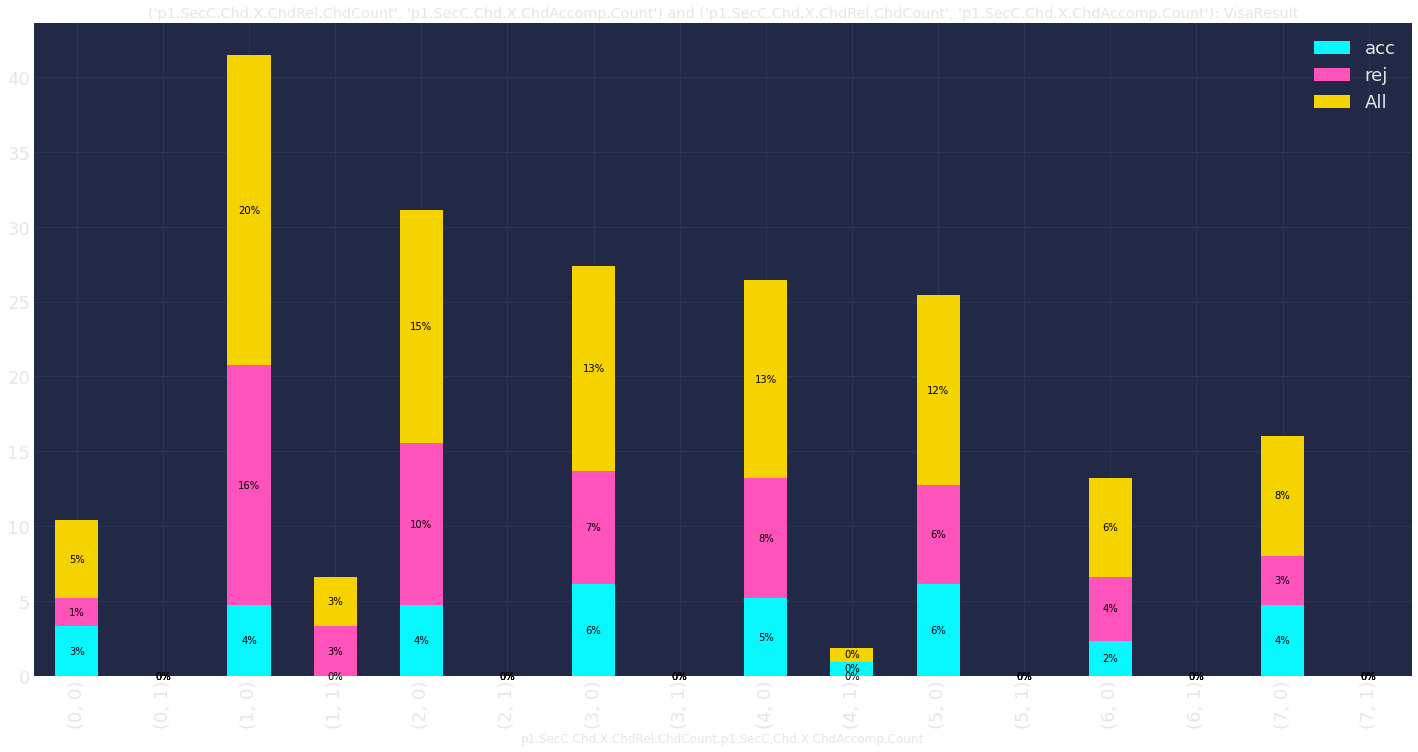

In [300]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

Insights:
1. There is almost no case where someone got visa when going with siblings except very rare cases
2. By increase in number of siblings, the rejection rate decreases considerably. This might be just a correlation behavior since usually people with higher number of siblings (>3 especially) are from traditional families that marry sooner (higher marriage period), are older (zoomers all are alone), have more children, etc. Hence, more likely to go back. This is clearly visible for cases with 5 or more siblings that almost acceptance rate surpasses %50.


### p1.SecA.Fa.ChdMStatus and p1.SecA.Fa.FaDOB.Period

In [301]:
output_name = 'VisaResult'
feature_name = ['p1.SecA.Fa.ChdMStatus', 'p1.SecA.Fa.FaDOB.Period']

In [302]:
print(data[(data[feature_name[0]] == 9) & (data[feature_name[1]] == 0.)].shape[0])

28


For some weird reason, %10 (28/298) of our applicants have provided zero info about their fathers but it seems irrational to think they don't have a known father, so assuming they haven't provided the info, makes sense.

To fill this, we can follow similar path as children and siblings' age, and just fill `0`s with the average difference of age of mothers from fathers (given social trends about age, `fathers > mothers`)

In [303]:
output_name = 'VisaResult'

from functools import reduce
import re
r = re.compile('p1.SecA.(Fa|Mo)\..*(ChdMStatus|Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
father_feature_name = [v for v in feature_name if 'Fa' in v]
mother_feature_name = [v for v in feature_name if 'Mo' in v]
print(feature_name)
print(father_feature_name)
print(mother_feature_name)

['p1.SecA.Mo.ChdMStatus', 'p1.SecA.Fa.ChdMStatus', 'p1.SecA.Mo.MoDOB.Period', 'p1.SecA.Fa.FaDOB.Period']
['p1.SecA.Fa.ChdMStatus', 'p1.SecA.Fa.FaDOB.Period']
['p1.SecA.Mo.ChdMStatus', 'p1.SecA.Mo.MoDOB.Period']


#### Fill Cases With **One** of Mother or Father Age Missing

In [304]:
print(data[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0) & (
    data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] != 0)][feature_name])
print(data[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] != 0) & (
    data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0)][feature_name])

     p1.SecA.Mo.ChdMStatus  p1.SecA.Fa.ChdMStatus  p1.SecA.Mo.MoDOB.Period  \
114                    7.0                    1.0                85.000000   
202                    5.0                    5.0                54.419178   
223                    7.0                    5.0                67.131507   

     p1.SecA.Fa.FaDOB.Period  
114                      0.0  
202                      0.0  
223                      0.0  
Empty DataFrame
Columns: [p1.SecA.Mo.ChdMStatus, p1.SecA.Fa.ChdMStatus, p1.SecA.Mo.MoDOB.Period, p1.SecA.Fa.FaDOB.Period]
Index: []


In [305]:
father_age_median = data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] != 0),  father_feature_name[1]].median()
mother_age_median = data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] != 0),  mother_feature_name[1]].median()
average_difference = father_age_median - mother_age_median  # mostly positive
print('median difference of fathers age from mothers: {}'.format(average_difference))

# fill fathers with no age with available mothers's age
na_mother_age = data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0) & (data[mother_feature_name[1]] != 0), mother_feature_name[1]]
fill_age = na_mother_age + average_difference
# print(data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0 & (data[mother_feature_name[1]] != 0)),  father_feature_name[1]], fill_age)
data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0 & (data[mother_feature_name[1]] != 0)),  father_feature_name[1]] = fill_age

# fill mothers with no age with available fathers's age
na_father_age = data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0) & (data[father_feature_name[1]] != 0), father_feature_name[1]]
fill_age = na_father_age + average_difference
# print(data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0) & (data[father_feature_name[1]] != 0),  mother_feature_name[1]], fill_age)
data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0) & (data[father_feature_name[1]] != 0),  mother_feature_name[1]] = fill_age

median difference of fathers age from mothers: 2.628767123287659


In [306]:
print(data.iloc[[110, 198, 219]][feature_name])

     p1.SecA.Mo.ChdMStatus  p1.SecA.Fa.ChdMStatus  p1.SecA.Mo.MoDOB.Period  \
114                    7.0                    1.0                85.000000   
202                    5.0                    5.0                54.419178   
223                    7.0                    5.0                67.131507   

     p1.SecA.Fa.FaDOB.Period  
114                87.628767  
202                57.047945  
223                69.760274  


#### Fill Cases With **Both** of Mother or Father Age Missing

These group of people are probably dead!

In [307]:
aggregator_feature_name = 'P1.PD.DOBYear.Period'
data[(data[father_feature_name[0]] == 9) & (data[father_feature_name[1]] == 0) & (
    data[mother_feature_name[0]] == 9) & (data[mother_feature_name[1]] == 0)][[*feature_name, aggregator_feature_name]]

,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.ChdMStatus,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,P1.PD.DOBYear.Period
5,9.0,9.0,0.0,0.0,51.652055
21,9.0,9.0,0.0,0.0,59.687671
30,9.0,9.0,0.0,0.0,61.671233
31,9.0,9.0,0.0,0.0,57.290411
46,9.0,9.0,0.0,0.0,86.594521
69,9.0,9.0,0.0,0.0,84.827397
73,9.0,9.0,0.0,0.0,75.076712
75,9.0,9.0,0.0,0.0,28.775342
87,9.0,9.0,0.0,0.0,45.005479
95,9.0,9.0,0.0,0.0,73.446575


In [308]:
data2 = data.copy()

In [309]:
# dead people that have age 
cond = (data[father_feature_name[0]] == 9) & (
    data[father_feature_name[1]] != 0)

# average difference of medians of applicants' age from their parents' age (only for applicants with dead parents)
# since I capped to 85, mean and median are 85 too
father_age_median = data.loc[cond, father_feature_name[1]].median()
# since I capped to 85, mean and median are 85 too
mother_age_median = data.loc[cond,  mother_feature_name[1]].median()
app_age_median = data.loc[cond, aggregator_feature_name].median()

app_father_age_diff = father_age_median - app_age_median
app_mother_age_diff = mother_age_median - app_age_median
# here, it's mostly positive, because the median 
average_difference = father_age_median - mother_age_median
print('median difference of dead fathers age from dead mothers: {}\n \
       median age of dead fathers: {}\nmedian age of dead mothers: {}\n'.format(
    average_difference, father_age_median, mother_age_median))

# apps with both parents dead
cond = (data[father_feature_name[0]] == 9) & (data[father_feature_name[1]] == 0) & (
    data[mother_feature_name[0]] == 9) & (data[mother_feature_name[1]] == 0)
# fill deads' age
na_app_age = data.loc[cond, aggregator_feature_name]
print(na_app_age.shape)
# fill dead fathers' age
data.loc[cond, father_feature_name[1]] = na_app_age + app_father_age_diff
# fill dead mothers' age
data.loc[cond, mother_feature_name[1]] = na_app_age + app_mother_age_diff

median difference of dead fathers age from dead mothers: 8.358904109589048
        median age of dead fathers: 82.33972602739726
median age of dead mothers: 73.98082191780821

(16,)


In [310]:
index = data2[(data2[father_feature_name[0]] == 9) & (data2[father_feature_name[1]] == 0) & (
    data2[mother_feature_name[0]] == 9) & (data2[mother_feature_name[1]] == 0)][[*feature_name, aggregator_feature_name]].index
data.loc[index, [*feature_name, aggregator_feature_name]]

,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.ChdMStatus,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,P1.PD.DOBYear.Period
5,9.0,9.0,78.693151,87.052055,51.652055
21,9.0,9.0,86.728767,95.087671,59.687671
30,9.0,9.0,88.712329,97.071233,61.671233
31,9.0,9.0,84.331507,92.690411,57.290411
46,9.0,9.0,113.635616,121.994521,86.594521
69,9.0,9.0,111.868493,120.227397,84.827397
73,9.0,9.0,102.117808,110.476712,75.076712
75,9.0,9.0,55.816438,64.175342,28.775342
87,9.0,9.0,72.046575,80.405479,45.005479
95,9.0,9.0,100.487671,108.846575,73.446575


#### Age With No Marital Status
People who have their parents have a valid age field but no martial status dedicated which probably is the indication for dead case which that they should be left as it is. For other cases that people actually forgot to fill, we can follow these approaches:
1. Fill it with their mother's status:
   1. mother widowed (`8`)-> father (dead) -> don't change (`9`)
   2. mother single (`7`) -> father other -> don't change (`9`)
   3. mother married/divorced/all other cases -> father same as mother
2. Leave it! **<- CURRENT IMPL.**

In [311]:
print(data[(data[feature_name[0]] == 9) & (data[feature_name[1]] != 0.)].shape[0])

62


In [312]:
data[(data[father_feature_name[0]] == 9) & (data[father_feature_name[1]] != 0) & (
    data[mother_feature_name[0]] == 9) & (data[mother_feature_name[1]] != 0)][[*feature_name]]

,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.ChdMStatus,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period
3,9.0,9.0,61.501370,67.282192
5,9.0,9.0,78.693151,87.052055
16,9.0,9.0,71.934247,79.810959
17,9.0,9.0,85.000000,85.000000
19,9.0,9.0,66.167123,85.000000
...,...,...,...,...
289,9.0,9.0,85.000000,85.000000
291,9.0,9.0,85.000000,69.764384
292,9.0,9.0,85.000000,85.000000
300,9.0,9.0,70.602740,76.693151


57 out of 62 cases have dead father and dead mother. So, it means that almost all cases where marital status is missed, probably person is dead and filling it with other values might not seem appropriate.

TODO: until occupation fields are incorporated which contain `deceased` for people who are actually dead.

In [313]:
data.sample(5)

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.SecA.App.ChdMStatus,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count,p1.SecC.Chd.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdAccomp.Count,p1.SecC.Chd.X.ChdAccomp.Count,p1.SecB.Chd.X.ChdRel.ChdCount,p1.SecC.Chd.X.ChdRel.ChdCount
26,False,Male,1.107154,1.0,1.429856,1.429856,False,TURKEY,6.0,False,family visit,5000.0,f1,ukn,True,master,3.177804,1.107154,1.107154,1.107154,False,False,False,32.608219,0.0,0.0,90.0,5.402740,0.000000,32.733333,32.0,6.005479,13.597260,0.000000,0.0,5.0,5.0,5.0,9.0,other,9.0,other,9.0,other,9.0,other,5.0,sister,5.0,brother,9.0,other,9.0,other,9.0,other,9.0,other,9.0,other,31.794521,62.172603,66.747945,0.000000,0.00000,0.0,0.0,34.830137,27.090411,0.000000,0.000000,0.000000,0.000000,0.000000,rej,0,1,0,0,0,0,2
231,False,Female,1.107154,1.0,1.429856,1.429856,False,TURKEY,3.0,False,tourism,10000.0,hotel,hotel,True,phd,3.177804,1.107154,1.107154,1.107154,False,False,False,42.290411,0.0,0.0,30.0,12.194521,0.000000,61.366667,19.0,7.005479,15.271233,0.000000,0.0,5.0,5.0,5.0,6.0,daughter,9.0,other,9.0,other,9.0,other,5.0,sister,5.0,brother,9.0,other,9.0,other,9.0,other,9.0,other,9.0,other,44.410959,65.380822,67.539726,7.558904,0.00000,0.0,0.0,40.153425,40.153425,0.000000,0.000000,0.000000,0.000000,0.000000,rej,0,0,0,2,0,1,2
138,False,Female,1.107154,1.0,1.429856,1.429856,False,TURKEY,6.0,False,visit,10000.0,hotel,hotel,True,diploma,3.177804,1.107154,1.107154,1.107154,False,False,False,40.854795,0.0,0.0,30.0,11.457534,0.000000,53.300000,12.0,2.002740,7.832877,9.832877,0.0,5.0,5.0,5.0,6.0,daughter,6.0,daughter,9.0,other,9.0,other,5.0,brother,6.0,sister,5.0,sister,6.0,sister,9.0,other,9.0,other,9.0,other,40.846575,64.871233,66.871233,9.734247,2.49589,0.0,0.0,42.854795,36.852055,33.849315,48.860274,0.000000,0.000000,0.000000,no idea,0,0,0,1,0,2,4
198,False,Male,1.107154,1.0,1.429856,1.429856,False,TURKEY,3.0,True,family visit,9000.0,f1,ukn,False,<NA>,1.000000,1.107154,1.107154,1.107154,False,False,False,53.391781,0.0,0.0,31.0,0.000000,21.978082,60.100000,19.0,0.00

In [314]:
data.describe()

,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.CWA.Row2.Status,P3.DOV.PrpsRow1.Funds.Funds,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.SecA.App.ChdMStatus,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[3].ChdMStatus,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[6].ChdMStatus,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,P1.PD.PrevCOR.Row.Count,p1.SecC.Chd.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdAccomp.Count,p1.SecC.Chd.X.ChdAccomp.Count,p1.SecB.Chd.X.ChdRel.ChdCount,p1.SecC.Chd.X.ChdRel.ChdCount
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,284.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,291.000000,290.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,1.111291,1.010067,1.436077,1.432910,4.295302,9065.436242,2.493399,1.112209,1.111946,1.107149,43.473835,28.137584,1.214765,44.605634,14.450841,1.619316,48.403691,21.701342,2.603025,12.777742,3.166710,0.789326,5.328859,6.231544,6.637584,6.936242,7.748322,8.614094,8.832215,5.573826,6.211409,6.808725,7.520134,8.030201,8.419463,8.664430,35.161690,68.021475,71.094913,12.964511,8.569500,3.393997,1.584775,45.084470,35.926823,27.127204,19.351062,13.035005,7.227901,4.556121,0.046980,0.010067,0.036913,0.986577,0.030201,1.211409,3.238255
std,0.071408,0.129357,0.103711,0.052714,1.576355,2039.982499,1.042642,0.072555,0.072274,0.000091,13.304900,180.428907,20.970097,25.734842,14.073723,7.221360,14.904153,21.093700,2.485945,11.722280,6.570424,2.576763,0.931621,1.690759,2.040713,1.659366,1.616543,1.108007,0.764557,1.242995,1.724922,1.978076,1.866215,1.684479,1.414889,1.104693,22.558734,14.968758,18.907474,15.302095,14.358631,10.481685,7.170411,17.446186,23.588209,25.243366,24.916080,22.558912,17.998329,14.666866,0.227283,0.129357,0.221671,0.921034,0.171429,1.136598,2.000071
min,1.107154,1.000000,1.000000,1.429856,1.000000,1000.000000,1.000000,1.105588,1.105588,1.105588,17.808219,0.000000,0.000000,28.000000,0.000000,0.000000,5.066667,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,3.000000,5.000000,5.000000,5.000000,1.000000,3.000000,3.000000,5.000000,5.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.107154,1.000000,1.429856,1.429856,3.000000,8000.000000,1.000000,1.107154,1.107154,1.107154,34.471918,0.000000,0.000000,30.000000,1.067123,0.000000,39.341667,13.000000,0.000000,3.93835

## Optimized Datatype

1. **Preference**: I have my own preferences in some valid data types, i.e. `float32` instead of `float64`
   1. continuous data represented as `floatx` to `float32`

2. **Validate**: Some data types are not valid and cannot be used, so it has to be converted:
    1. categorical data represented as `integer` to Pandas `category`
    2. categorical data represented as `string` to Pandas `category`


In [315]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 82 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    object 
 1   P1.PD.Sex.Sex                                          298 non-null    object 
 2   P1.PD.CurrCOR.Row2.Country                             298 non-null    float64
 3   P1.PD.CurrCOR.Row2.Status                              298 non-null    float64
 4   P1.PD.PrevCOR.Row2.Country                             298 non-null    float64
 5   P1.PD.PrevCOR.Row3.Country                             298 non-null    float64
 6   P1.PD.SameAsCORIndicator                               298 non-null    object 
 7   P1.PD.CWA.Row2.Country                                 298 non-null    object 
 8   P1.PD.CWA.Row2.Status                             

In [316]:
unique_counts = pd.DataFrame.from_records([(col, data[col].nunique()) for col in data.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts.transpose()

,0,22,21,20,19,14,9,25,6,1,2,79,5,75,77,42,44,51,53,54,41,57,59,76,55,40,3,8,78,49,47,56,45,18,52,15,50,48,17,43,39,38,35,58,10,74,7,80,13,12,37,36,46,16,81,4,11,66,26,24,34,65,28,73,31,30,72,33,71,64,70,63,27,69,62,68,29,60,61,67,32,23
Column_Name,P1.PD.AliasName.AliasNameIndicator.AliasNameIn...,P3.BGI2.PrevApply,P3.refuseDeport,P3.noAuthStay,P3.Occ.OccRow3.Country.Country,P3.Edu.EduIndicator,P2.MS.SecA.PrevMarrIndicator,P1.PD.PrevCOR.Row3.Period,P1.PD.SameAsCORIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,p1.SecC.Chd.X.ChdAccomp.Count,P1.PD.PrevCOR.Row3.Country,P1.PD.PrevCOR.Row.Count,p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[3].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[4].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.X.ChdCOB.ForeignerCount,p1.SecC.Chd.[4].ChdRel,p1.SecB.Chd.[1].ChdMStatus,P1.PD.CurrCOR.Row2.Status,P1.PD.CWA.Row2.Status,p1.SecB.ChdMoFaSps.X.ChdAccomp.Count,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[5].ChdMStatus,p1.SecB.Chd.[3].ChdRel,P3.Occ.OccRow2.Country.Country,p1.SecC.Chd.[3].ChdMStatus,P3.Edu.Edu_Row1.FieldOfStudy,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[1].ChdMStatus,P3.Occ.OccRow1.Country.Country,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdMStatus,p1.SecA.App.ChdMStatus,p1.SecC.Chd.[6].ChdMStatus,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,VisaResult,P1.PD.CWA.Row2.Country,p1.SecB.Chd.X.ChdRel.ChdCount,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.DOV.cntcts_Row1.RelationshipToMe.Relationsh...,p1.SecA.Fa.ChdMStatus,p1.SecA.Mo.ChdMStatus,p1.SecC.Chd.[0].ChdMStatus,P3.Edu.Edu_Row1.Country.Country,p1.SecC.Chd.X.ChdRel.ChdCount,P1.PD.PrevCOR.Row2.Country,P3.DOV.PrpsRow1.Funds.Funds,p1.SecB.Chd.[3].ChdDOB.Period,P1.PD.CWA.Row2.Period,P1.PD.PrevCOR.Row2.Period,P3.Occ.OccRow3.Period,p1.SecB.Chd.[2].ChdDOB.Period,P2.MS.SecA.Period,p1.SecC.Chd.[6].ChdDOB.Period,P3.Edu.Edu_Row1.Period,P3.DOV.PrpsRow1.HLS.Period,p1.SecC.Chd.[5].ChdDOB.Period,P3.Occ.OccRow2.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,P1.MS.SecA.DateOfMarr.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,P3.Occ.OccRow1.Period,P1.PD.DOBYear.Period
Num_Unique,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,8,10,11,11,12,14,19,23,24,30,35,39,46,51,82,91,119,141,160,170,212,222,223,227,250,277,281,288


### To `category`

In [317]:
feature_name = [
    'P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator', 'P3.BGI2.PrevApply', 'P3.refuseDeport', 'P3.noAuthStay', 'P3.Edu.EduIndicator', 
    'P2.MS.SecA.PrevMarrIndicator', 'P1.PD.SameAsCORIndicator', 'P1.PD.Sex.Sex', 'p1.SecB.Chd.[2].ChdMStatus', 'p1.SecB.Chd.[3].ChdMStatus', 
    'p1.SecC.Chd.[2].ChdRel', 'p1.SecC.Chd.[3].ChdRel', 'p1.SecC.Chd.[4].ChdMStatus', 'p1.SecB.Chd.[1].ChdMStatus', 'p1.SecC.Chd.[5].ChdRel',
    'p1.SecC.Chd.[6].ChdRel', 'p1.SecC.Chd.[4].ChdRel', 'p1.SecB.Chd.[1].ChdRel', 'P1.PD.CWA.Row2.Status', 'p1.SecC.Chd.[5].ChdMStatus', 'p1.SecC.Chd.[1].ChdRel',
    'p1.SecC.Chd.[0].ChdRel', 'p1.SecB.Chd.[3].ChdRel', 'p1.SecC.Chd.[3].ChdMStatus', 'p1.SecC.Chd.[2].ChdMStatus', 'p1.SecC.Chd.[1].ChdMStatus', 
    'p1.SecB.Chd.[2].ChdRel', 'P3.cntcts_Row2.Relationship.RelationshipToMe', 'p1.SecB.Chd.[0].ChdMStatus', 'p1.SecA.App.ChdMStatus', 'p1.SecC.Chd.[6].ChdMStatus',
    'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'VisaResult', 'p1.SecB.Chd.[0].ChdRel', 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe',
    'p1.SecA.Fa.ChdMStatus', 'p1.SecA.Mo.ChdMStatus', 'p1.SecC.Chd.[0].ChdMStatus', 'P1.PD.CurrCOR.Row2.Status', 'P1.PD.CWA.Row2.Country'
]

data[feature_name].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    object 
 1   P3.BGI2.PrevApply                                      298 non-null    object 
 2   P3.refuseDeport                                        298 non-null    object 
 3   P3.noAuthStay                                          298 non-null    object 
 4   P3.Edu.EduIndicator                                    298 non-null    object 
 5   P2.MS.SecA.PrevMarrIndicator                           298 non-null    object 
 6   P1.PD.SameAsCORIndicator                               298 non-null    object 
 7   P1.PD.Sex.Sex                                          298 non-null    object 
 8   p1.SecB.Chd.[2].ChdMStatus                        

#### convert all those containing 'Status' to `int` from `float64`

In [318]:
feature_name_status = [c for c in feature_name if 'Status' in c]
# float to int since status is categorical
data[feature_name_status] = data[feature_name_status].astype(int)
# int to categorical
data[feature_name_status] = data[feature_name_status].astype('category')

#### convert `object` to `category`

In [319]:
feature_name_obj = list(set(feature_name) - set(feature_name_status))
for c in feature_name_obj:  # all have to be type of `object`
    assert (data[c].dtype == 'object') or (data[c].dtype == 'category')

data[feature_name_obj] = data[feature_name_obj].astype('category')

In [320]:
data[feature_name].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    category
 1   P3.BGI2.PrevApply                                      298 non-null    category
 2   P3.refuseDeport                                        298 non-null    category
 3   P3.noAuthStay                                          298 non-null    category
 4   P3.Edu.EduIndicator                                    298 non-null    category
 5   P2.MS.SecA.PrevMarrIndicator                           298 non-null    category
 6   P1.PD.SameAsCORIndicator                               298 non-null    category
 7   P1.PD.Sex.Sex                                          298 non-null    category
 8   p1.SecB.Chd.[2].ChdMStatus              

### To `32` bit (`float` and `int`)

In [321]:
feature_name_continuous = list(set(data.columns.values) - set(feature_name))
data[feature_name_continuous].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   P3.Occ.OccRow2.Period                       298 non-null    float64
 1   P1.PD.CWA.Row2.Period                       284 non-null    float64
 2   P1.PD.PrevCOR.Row2.Period                   298 non-null    float64
 3   p1.SecB.Chd.[1].ChdDOB.Period               298 non-null    float64
 4   P3.Occ.OccRow2.Country.Country              298 non-null    float64
 5   p1.SecB.Chd.X.ChdRel.ChdCount               298 non-null    int64  
 6   p1.SecC.Chd.[6].ChdDOB.Period               298 non-null    float64
 7   P3.Occ.OccRow1.Country.Country              298 non-null    float64
 8   p1.SecC.Chd.[5].ChdDOB.Period               298 non-null    float64
 9   P3.Edu.Edu_Row1.Country.Country             298 non-null    float64
 10  P1.PD.CurrCOR.

In [322]:
for c in feature_name_continuous:
    if data[c].dtype == 'int64':
        data[c] = data[c].astype(np.int32)
    if data[c].dtype == 'float64':
        data[c] = data[c].astype(np.float32)
data[feature_name_continuous].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   P3.Occ.OccRow2.Period                       298 non-null    float32
 1   P1.PD.CWA.Row2.Period                       284 non-null    float32
 2   P1.PD.PrevCOR.Row2.Period                   298 non-null    float32
 3   p1.SecB.Chd.[1].ChdDOB.Period               298 non-null    float32
 4   P3.Occ.OccRow2.Country.Country              298 non-null    float32
 5   p1.SecB.Chd.X.ChdRel.ChdCount               298 non-null    int32  
 6   p1.SecC.Chd.[6].ChdDOB.Period               298 non-null    float32
 7   P3.Occ.OccRow1.Country.Country              298 non-null    float32
 8   p1.SecC.Chd.[5].ChdDOB.Period               298 non-null    float32
 9   P3.Edu.Edu_Row1.Country.Country             298 non-null    float32
 10  P1.PD.CurrCOR.

In [323]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 82 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    category
 1   P1.PD.Sex.Sex                                          298 non-null    category
 2   P1.PD.CurrCOR.Row2.Country                             298 non-null    float32 
 3   P1.PD.CurrCOR.Row2.Status                              298 non-null    category
 4   P1.PD.PrevCOR.Row2.Country                             298 non-null    float32 
 5   P1.PD.PrevCOR.Row3.Country                             298 non-null    float32 
 6   P1.PD.SameAsCORIndicator                               298 non-null    category
 7   P1.PD.CWA.Row2.Country                                 298 non-null    category
 8   P1.PD.CWA.Row2.Status                   

In [324]:
s1 = time.process_time_ns() - s0
print('Total runtime: {}'.format(s1/1e9))

Total runtime: 38.077345


## Save Data to Disc
**Save preprocessed data to disc, as a baseline. Why:**
1. All type casting, feature engineering, visualization, etc all needed to be added to the main package to ensure reproducibility as being part of the same end to end pipeline
2. During the transition happening at step (1), we check the correct implementation by comparing to this saved data
3. I am tired af of EDA and all software engineering and cheeky if else pleb approaches of data analysis, doing some new stuff like weak supervision for converting non/weak labeled data to absolute one would add some fun
4. It's not gonna cost anything, so why not!


**Tracking:**
1. This data need to be tracked by DVC too
2. Consider this data, `dev` version with a new unique tag (i.e. if last tag is `v1.0.2`, we use `v1.1.0-dev`) and use following format for commit message `EDA of [previous_production_tag_version]`, i.e. `EDA of v1.0.2`
3. After all implementation in this notebook have been merged into original codebase cleanly, we rerun data generation pipeline and create the production ready data which will be tracked and tagged with `v1.1.0` (same as step 2 but without `-dev`)

The reason for this is the step 3 of previous part and we want to track the snorkel procedure too.

In [325]:
dataset_path = '../raw-dataset/all-dev.pkl'  # Don't change the name, 
data.to_pickle(dataset_path)

## Load Data For Comparison

In [326]:
from pandas import testing as tm

dataset_path = '../raw-dataset/all-dev.pkl'  # Don't change the name, 
data_original = pd.read_pickle(dataset_path)

In [327]:
tm.assert_frame_equal(data, data_original, check_exact=False, rtol=1e-4, atol=1e-5)

In [328]:
data

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.FieldOfStudy,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.SecA.App.ChdMStatus,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count,p1.SecC.Chd.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount,p1.SecB.ChdMoFaSps.X.ChdAccomp.Count,p1.SecC.Chd.X.ChdAccomp.Count,p1.SecB.Chd.X.ChdRel.ChdCount,p1.SecC.Chd.X.ChdRel.ChdCount
0,False,Female,1.107154,1,1.429856,1.429856,True,TURKEY,6,False,family visit,10000.0,f1,ukn,False,<NA>,1.000000,1.107154,1.107154,1.107154,False,False,False,51.556164,0.0,0.0,30.0,36.643837,0.000000,33.966667,31.0,0.00000,7.005479,3.0,14.010959,5,5,5,5,daughter,6,son,6,son,9,other,5,brother,5,brother,5,sister,5,brother,5,brother,3,brother,9,other,60.071232,85.000000,85.000000,35.498631,34.482193,7.350685,0.000000,71.304108,67.994522,65.808220,60.942467,56.709591,53.227398,0.00000,acc,0,0,0,2,0,3,6
1,True,Female,1.107154,1,1.429856,1.429856,False,TURKEY,3,False,tourism,10000.0,ukn,ukn,True,master,3.177804,1.107154,1.107154,1.107154,False,False,False,48.553425,0.0,0.0,31.0,22.438356,0.000000,53.099998,22.0,3.00274,9.526028,1.0,5.002740,5,5,5,6,daughter,9,other,9,other,9,other,5,brother,5,brother,3,sister,9,other,9,other,9,other,9,other,47.336987,76.287674,81.972603,18.671232,0.000000,0.000000,0.000000,53.369862,50.561646,44.410957,0.000000,0.000000,0.000000,0.00000,acc,0,0,0,2,0,1,3
2,False,Female,1.107154,1,1.429856,1.429856,False,TURKEY,6,False,tourism,10000.0,hotel,hotel,False,<NA>,1.000000,1.107154,1.107154,1.107154,False,False,False,26.989040,0.0,0.0,30.0,5.391781,0.000000,59.333332,13.0,0.00000,4.975342,0.0,0.000000,5,5,5,6,son,9,other,9,other,9,other,5,sister,6,brother,6,brother,9,other,9,other,9,other,9,other,28.145205,45.139725,54.082191,2.378082,0.000000,0.000000,0.000000,26.347944,20.895891,12.646575,0.000000,0.000000,0.000000,0.00000,rej,0,0,0,0,0,1,3
3,False,Female,1.107154,1,1.429856,1.429856,False,OTHER,3,False,tourism,10000.0,hotel,hotel,True,bachelor,3.177804,1.107154,1.107154,1.107154,False,False,False,34.449314,0.0,0.0,30.0,12.635616,0.000000,45.066666,15.0,5.00274,6.430137,0.0,0.000000,5,9,9,9,other,9,other,9,other,9,other,9,sister